In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(22001)

yuima = importr("yuima")
n_stvol_sim_string = """
n_stvol = function(random_seed, num_sim,
                    mu11, mu21, mu22, mu31, mu41, mu42, 
                    sigma11, sigma12, sigma13, sigma14,
                    sigma21, sigma22, sigma23, sigma24,
                    sigma31, sigma32, sigma33, sigma34,
                    sigma41, sigma42, sigma43, sigma44,
                    xinit_vec, vinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11-(1/2)*(v1)^2", "mu21-mu22*v1", "mu31-(1/2)*(v2)^2", "mu41-mu42*v2")
  diffusion = matrix(c("sigma11*v1", "sigma12*v1", "sigma13*v1", "sigma14*v1", 
                       "sigma21", "sigma22", "sigma23", "sigma24", 
                       "sigma31*v2", "sigma32*v2", "sigma33*v2", "sigma34*v2", 
                       "sigma41", "sigma42", "sigma43", "sigma44"), 
                     4, 4, byrow=TRUE)
  
  stvol_model = setModel(drift=drift, diffusion=diffusion,
                          time.variable = "t",
                          state.variable=c("X1", "v1", "X2", "v2"),
                          solve.variable=c("X1", "v1", "X2", "v2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    stvol_sim = simulate(stvol_model, 
                          true.par=list(
                            mu11=mu11, mu21=mu21, mu22=mu22, mu31=mu31, mu41=mu41, mu42=mu42,  
                            sigma11=sigma11, sigma12=sigma12, sigma13=sigma13, sigma14=sigma14,
                            sigma21=sigma21, sigma22=sigma22, sigma23=sigma23, sigma24=sigma24,
                            sigma31=sigma31, sigma32=sigma32, sigma33=sigma33, sigma34=sigma34,
                            sigma41=sigma41, sigma42=sigma42, sigma43=sigma43, sigma44=sigma44), 
                          xinit=c(xinit_vec[[i]][1], vinit_vec[[i]][1], xinit_vec[[i]][2], vinit_vec[[i]][2]), 
                          sampling=newsamp)
    original_data = stvol_sim@data@original.data
    one_sim_stvol = data.frame(original_data[,1], original_data[,3])
    colnames(one_sim_stvol) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_stvol
  }
  return(n_sim_data)
}
"""

n_stvol_sim = SignatureTranslatedAnonymousPackage(n_stvol_sim_string, "n_stvol_sim")
def n_stvol_simulation(random_seed, num_sim,
                        mu11, mu21, mu22, mu31, mu41, mu42, 
                        sigma11, sigma12, sigma13, sigma14,
                        sigma21, sigma22, sigma23, sigma24,
                        sigma31, sigma32, sigma33, sigma34,
                        sigma41, sigma42, sigma43, sigma44,
                        xinit_vec, vinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_stvol_sim.n_stvol(random_seed=random_seed, num_sim=num_sim,
                              mu11=mu11, mu21=mu21, mu22=mu22, mu31=mu31, mu41=mu41, mu42=mu42,  
                              sigma11=sigma11, sigma12=sigma12, sigma13=sigma13, sigma14=sigma14,
                              sigma21=sigma21, sigma22=sigma22, sigma23=sigma23, sigma24=sigma24,
                              sigma31=sigma31, sigma32=sigma32, sigma33=sigma33, sigma34=sigma34,
                              sigma41=sigma41, sigma42=sigma42, sigma43=sigma43, sigma44=sigma44,
                              xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef
    
    




    
    





def loss_function(params):
    
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_stvol_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], 
        mu21=params[1], mu22=params[2], 
        mu31=params[3], 
        mu41=params[4], mu42=params[5],  
        sigma11=params[6],  sigma12=params[7],  sigma13=params[8],  sigma14=params[9],
        sigma21=params[10], sigma22=params[11], sigma23=params[12], sigma24=params[13],
        sigma31=params[14], sigma32=params[15], sigma33=params[16], sigma34=params[17],
        sigma41=params[18], sigma42=params[19], sigma43=params[20], sigma44=params[21],
        xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_log_price=n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_return=n_sim_return, n_price=n_sim_price)


    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)
    loss = np.sum(sum_loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss


real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
vinit_vec = []
for i in range(int(real_price.shape[1]/2)):

    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
    init_pair_volatility = [np.std(real_return.iloc[:, 2*i]/100), np.std(real_return.iloc[:, 2*i+1]/100)]
    init_pair_volatility = FloatVector(init_pair_volatility)
    vinit_vec.append(init_pair_volatility)


num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats




initial0 = [0.1, 
            1, 1, 
            0.1, 
            1, 1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(0, None), 
                       (None, None), (None, None), 
                       (0, None), 
                       (None, None), (None, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1] 0.1 1.0 1.0 0.1 1.0 1.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
[20] 0.1 0.1 0.1

return_mean1                           24.579290
return_mean2                           22.950342
return_sd1                            272.068326
return_sd2                            289.730545
return_skew1                          168.026917
return_skew2                          168.026917
return_kurtosis1                     1005.660094
return_kurtosis2                     1516.535022
return_autocorrelation_ts1_lag1        20.518839
return_autocorrelation_ts1_lag2        21.028420
return_autocorrelation_ts1_lag3        19.649696
return_autocorrelation_ts2_lag1        20.236835
return_autocorrelation_ts2_lag2        20.745451
return_autocorrelation_ts2_lag3        20.420796
return_correlation_ts1_lag_0          168.107709
return_correlation_ts1_lag_1           18.604514
return_correlation_ts1_lag_2           19.960430
return_correlation_ts1_lag_3           21.196094
return_correlation_

return_mean1                           72.195504
return_mean2                           22.902441
return_sd1                            274.763038
return_sd2                            292.433625
return_skew1                          163.474136
return_skew2                          163.474136
return_kurtosis1                     1022.809993
return_kurtosis2                     1520.894300
return_autocorrelation_ts1_lag1        21.548599
return_autocorrelation_ts1_lag2        19.716971
return_autocorrelation_ts1_lag3        21.098077
return_autocorrelation_ts2_lag1        20.971891
return_autocorrelation_ts2_lag2        20.259359
return_autocorrelation_ts2_lag3        20.343165
return_correlation_ts1_lag_0          168.107222
return_correlation_ts1_lag_1           21.384971
return_correlation_ts1_lag_2           19.624643
return_correlation_ts1_lag_3           21.327133
return_correlation_ts2_lag_1           21.378096
return_correlation_ts2_lag_2           19.739632
return_correlation_t

return_mean1                           21.637178
return_mean2                           23.064038
return_sd1                            272.336380
return_sd2                            289.997183
return_skew1                          160.245936
return_skew2                          160.245936
return_kurtosis1                     1013.809204
return_kurtosis2                     1497.148112
return_autocorrelation_ts1_lag1        20.853257
return_autocorrelation_ts1_lag2        21.484513
return_autocorrelation_ts1_lag3        20.521817
return_autocorrelation_ts2_lag1        18.975478
return_autocorrelation_ts2_lag2        20.867228
return_autocorrelation_ts2_lag3        19.209611
return_correlation_ts1_lag_0          168.108281
return_correlation_ts1_lag_1           20.426537
return_correlation_ts1_lag_2           20.207293
return_correlation_ts1_lag_3           20.165283
return_correlation_ts2_lag_1           20.068583
return_correlation_ts2_lag_2           19.666707
return_correlation_t

return_mean1                           21.157004
return_mean2                           23.321131
return_sd1                            273.659153
return_sd2                            291.320898
return_skew1                          156.655192
return_skew2                          156.655192
return_kurtosis1                      980.367239
return_kurtosis2                     1486.867445
return_autocorrelation_ts1_lag1        22.245256
return_autocorrelation_ts1_lag2        20.729395
return_autocorrelation_ts1_lag3        21.553108
return_autocorrelation_ts2_lag1        21.408482
return_autocorrelation_ts2_lag2        20.079643
return_autocorrelation_ts2_lag3        21.293863
return_correlation_ts1_lag_0          168.107811
return_correlation_ts1_lag_1           21.951335
return_correlation_ts1_lag_2           19.869965
return_correlation_ts1_lag_3           22.228914
return_correlation_ts2_lag_1           21.357166
return_correlation_ts2_lag_2           20.280247
return_correlation_t

return_mean1                           21.976967
return_mean2                           23.482094
return_sd1                            273.023296
return_sd2                            290.690148
return_skew1                          165.730110
return_skew2                          165.730110
return_kurtosis1                     1003.334718
return_kurtosis2                     1486.397796
return_autocorrelation_ts1_lag1        21.508430
return_autocorrelation_ts1_lag2        20.945282
return_autocorrelation_ts1_lag3        22.092088
return_autocorrelation_ts2_lag1        21.288777
return_autocorrelation_ts2_lag2        19.937382
return_autocorrelation_ts2_lag3        21.365915
return_correlation_ts1_lag_0          168.107842
return_correlation_ts1_lag_1           21.385171
return_correlation_ts1_lag_2           20.283780
return_correlation_ts1_lag_3           21.799881
return_correlation_ts2_lag_1           22.654963
return_correlation_ts2_lag_2           20.045172
return_correlation_t

return_mean1                           92.047295
return_mean2                           23.105031
return_sd1                            119.404122
return_sd2                            287.850034
return_skew1                          159.513884
return_skew2                          159.513884
return_kurtosis1                     1002.004840
return_kurtosis2                     1512.329485
return_autocorrelation_ts1_lag1        20.705781
return_autocorrelation_ts1_lag2        21.940957
return_autocorrelation_ts1_lag3        20.248167
return_autocorrelation_ts2_lag1        19.683047
return_autocorrelation_ts2_lag2        20.923718
return_autocorrelation_ts2_lag3        19.259173
return_correlation_ts1_lag_0          164.667121
return_correlation_ts1_lag_1           20.203354
return_correlation_ts1_lag_2           19.995224
return_correlation_ts1_lag_3           21.448514
return_correlation_ts2_lag_1           21.265522
return_correlation_ts2_lag_2           18.766126
return_correlation_t

return_mean1                           36.078537
return_mean2                           23.481939
return_sd1                            119.688937
return_sd2                            292.690623
return_skew1                          161.919741
return_skew2                          161.919741
return_kurtosis1                      994.174962
return_kurtosis2                     1488.927663
return_autocorrelation_ts1_lag1        19.188712
return_autocorrelation_ts1_lag2        20.771189
return_autocorrelation_ts1_lag3        19.425956
return_autocorrelation_ts2_lag1        20.361527
return_autocorrelation_ts2_lag2        21.332805
return_autocorrelation_ts2_lag3        20.043347
return_correlation_ts1_lag_0          166.485333
return_correlation_ts1_lag_1           19.789946
return_correlation_ts1_lag_2           19.990230
return_correlation_ts1_lag_3           20.574377
return_correlation_ts2_lag_1           21.275257
return_correlation_ts2_lag_2           20.419970
return_correlation_t

return_mean1                           41.355020
return_mean2                           23.160559
return_sd1                            105.602516
return_sd2                            291.178815
return_skew1                          162.698198
return_skew2                          162.698198
return_kurtosis1                     1004.935912
return_kurtosis2                     1507.859260
return_autocorrelation_ts1_lag1        20.265721
return_autocorrelation_ts1_lag2        20.704689
return_autocorrelation_ts1_lag3        20.377921
return_autocorrelation_ts2_lag1        21.323987
return_autocorrelation_ts2_lag2        20.212919
return_autocorrelation_ts2_lag3        19.686158
return_correlation_ts1_lag_0          166.347211
return_correlation_ts1_lag_1           19.626380
return_correlation_ts1_lag_2           20.249783
return_correlation_ts1_lag_3           21.101291
return_correlation_ts2_lag_1           18.526217
return_correlation_ts2_lag_2           20.416371
return_correlation_t

return_mean1                           40.084496
return_mean2                           22.987072
return_sd1                            107.980031
return_sd2                            291.234811
return_skew1                          156.918164
return_skew2                          156.918164
return_kurtosis1                      985.771839
return_kurtosis2                     1501.026268
return_autocorrelation_ts1_lag1        21.312390
return_autocorrelation_ts1_lag2        22.020105
return_autocorrelation_ts1_lag3        17.930067
return_autocorrelation_ts2_lag1        21.661303
return_autocorrelation_ts2_lag2        20.759361
return_autocorrelation_ts2_lag3        20.095006
return_correlation_ts1_lag_0          166.282881
return_correlation_ts1_lag_1           21.564047
return_correlation_ts1_lag_2           21.235779
return_correlation_ts1_lag_3           20.270556
return_correlation_ts2_lag_1           22.279704
return_correlation_ts2_lag_2           21.089452
return_correlation_t

return_mean1                           25.967074
return_mean2                           22.659512
return_sd1                            166.304261
return_sd2                            290.842599
return_skew1                          157.672759
return_skew2                          157.672759
return_kurtosis1                     1053.853229
return_kurtosis2                     1508.478783
return_autocorrelation_ts1_lag1        21.205245
return_autocorrelation_ts1_lag2        20.559534
return_autocorrelation_ts1_lag3        18.223218
return_autocorrelation_ts2_lag1        21.654722
return_autocorrelation_ts2_lag2        20.366804
return_autocorrelation_ts2_lag3        19.387641
return_correlation_ts1_lag_0          166.539740
return_correlation_ts1_lag_1           20.043131
return_correlation_ts1_lag_2           20.162006
return_correlation_ts1_lag_3           19.949655
return_correlation_ts2_lag_1           20.584610
return_correlation_ts2_lag_2           21.082056
return_correlation_t

return_mean1                           44.345482
return_mean2                           23.540064
return_sd1                            100.192206
return_sd2                            288.855409
return_skew1                          157.792046
return_skew2                          157.792046
return_kurtosis1                      999.654012
return_kurtosis2                     1486.807496
return_autocorrelation_ts1_lag1        21.229331
return_autocorrelation_ts1_lag2        21.462324
return_autocorrelation_ts1_lag3        20.577713
return_autocorrelation_ts2_lag1        19.735854
return_autocorrelation_ts2_lag2        20.269448
return_autocorrelation_ts2_lag3        22.131835
return_correlation_ts1_lag_0          166.143694
return_correlation_ts1_lag_1           20.013123
return_correlation_ts1_lag_2           19.750497
return_correlation_ts1_lag_3           22.952611
return_correlation_ts2_lag_1           20.270928
return_correlation_ts2_lag_2           21.271401
return_correlation_t

return_mean1                           41.960289
return_mean2                           23.060261
return_sd1                            106.534536
return_sd2                            291.838261
return_skew1                          160.685259
return_skew2                          160.685259
return_kurtosis1                      972.158816
return_kurtosis2                     1514.627191
return_autocorrelation_ts1_lag1        18.603277
return_autocorrelation_ts1_lag2        21.488063
return_autocorrelation_ts1_lag3        20.870183
return_autocorrelation_ts2_lag1        18.966415
return_autocorrelation_ts2_lag2        20.086335
return_autocorrelation_ts2_lag3        20.455053
return_correlation_ts1_lag_0          166.313299
return_correlation_ts1_lag_1           17.909721
return_correlation_ts1_lag_2           19.799942
return_correlation_ts1_lag_3           21.941202
return_correlation_ts2_lag_1           20.252595
return_correlation_ts2_lag_2           20.306176
return_correlation_t

return_mean1                           42.289390
return_mean2                           23.690339
return_sd1                            108.222536
return_sd2                            291.090349
return_skew1                          159.092557
return_skew2                          159.092557
return_kurtosis1                      985.173839
return_kurtosis2                     1512.719081
return_autocorrelation_ts1_lag1        22.440786
return_autocorrelation_ts1_lag2        20.701369
return_autocorrelation_ts1_lag3        20.130930
return_autocorrelation_ts2_lag1        21.215049
return_autocorrelation_ts2_lag2        19.907437
return_autocorrelation_ts2_lag3        21.225686
return_correlation_ts1_lag_0          166.285754
return_correlation_ts1_lag_1           21.466503
return_correlation_ts1_lag_2           19.189913
return_correlation_ts1_lag_3           21.175951
return_correlation_ts2_lag_1           21.756511
return_correlation_ts2_lag_2           19.820117
return_correlation_t

return_mean1                           40.900008
return_mean2                           24.049922
return_sd1                            105.107641
return_sd2                            293.618382
return_skew1                          157.932049
return_skew2                          157.932049
return_kurtosis1                      963.881509
return_kurtosis2                     1492.005845
return_autocorrelation_ts1_lag1        19.796522
return_autocorrelation_ts1_lag2        23.035898
return_autocorrelation_ts1_lag3        21.459704
return_autocorrelation_ts2_lag1        21.102506
return_autocorrelation_ts2_lag2        20.309031
return_autocorrelation_ts2_lag3        20.687655
return_correlation_ts1_lag_0          166.221594
return_correlation_ts1_lag_1           19.567678
return_correlation_ts1_lag_2           21.440267
return_correlation_ts1_lag_3           22.075419
return_correlation_ts2_lag_1           21.082640
return_correlation_ts2_lag_2           20.435939
return_correlation_t

return_mean1                           41.161649
return_mean2                           23.250799
return_sd1                            105.581008
return_sd2                            290.466207
return_skew1                          156.094432
return_skew2                          156.094432
return_kurtosis1                      981.100304
return_kurtosis2                     1499.848363
return_autocorrelation_ts1_lag1        20.679133
return_autocorrelation_ts1_lag2        21.518228
return_autocorrelation_ts1_lag3        20.691428
return_autocorrelation_ts2_lag1        21.144886
return_autocorrelation_ts2_lag2        20.134436
return_autocorrelation_ts2_lag3        19.729966
return_correlation_ts1_lag_0          166.279505
return_correlation_ts1_lag_1           21.231979
return_correlation_ts1_lag_2           19.019049
return_correlation_ts1_lag_3           20.585159
return_correlation_ts2_lag_1           19.674176
return_correlation_ts2_lag_2           17.930941
return_correlation_t

return_mean1                           41.343600
return_mean2                           23.274819
return_sd1                            105.770385
return_sd2                            292.197674
return_skew1                          166.238899
return_skew2                          166.238899
return_kurtosis1                      991.339979
return_kurtosis2                     1493.098338
return_autocorrelation_ts1_lag1        20.878417
return_autocorrelation_ts1_lag2        21.032040
return_autocorrelation_ts1_lag3        18.402373
return_autocorrelation_ts2_lag1        20.604606
return_autocorrelation_ts2_lag2        19.623460
return_autocorrelation_ts2_lag3        19.765948
return_correlation_ts1_lag_0          166.388249
return_correlation_ts1_lag_1           20.262510
return_correlation_ts1_lag_2           18.795212
return_correlation_ts1_lag_3           19.125393
return_correlation_ts2_lag_1           21.272209
return_correlation_ts2_lag_2           19.746397
return_correlation_t

return_mean1                           42.419524
return_mean2                           33.759484
return_sd1                            107.009300
return_sd2                            291.384342
return_skew1                          158.158289
return_skew2                          158.158289
return_kurtosis1                      997.131285
return_kurtosis2                     1514.941996
return_autocorrelation_ts1_lag1        21.137405
return_autocorrelation_ts1_lag2        20.401424
return_autocorrelation_ts1_lag3        19.238742
return_autocorrelation_ts2_lag1        19.581025
return_autocorrelation_ts2_lag2        19.092378
return_autocorrelation_ts2_lag3        19.245320
return_correlation_ts1_lag_0          166.253048
return_correlation_ts1_lag_1           20.586979
return_correlation_ts1_lag_2           18.768712
return_correlation_ts1_lag_3           20.108799
return_correlation_ts2_lag_1           20.347776
return_correlation_ts2_lag_2           19.586030
return_correlation_t

return_mean1                           40.987316
return_mean2                           22.541640
return_sd1                            105.921381
return_sd2                            291.486028
return_skew1                          164.053210
return_skew2                          164.053210
return_kurtosis1                      986.091454
return_kurtosis2                     1502.090726
return_autocorrelation_ts1_lag1        21.520612
return_autocorrelation_ts1_lag2        19.680883
return_autocorrelation_ts1_lag3        20.631771
return_autocorrelation_ts2_lag1        20.378133
return_autocorrelation_ts2_lag2        19.704524
return_autocorrelation_ts2_lag3        19.695366
return_correlation_ts1_lag_0          166.413733
return_correlation_ts1_lag_1           20.580562
return_correlation_ts1_lag_2           19.674410
return_correlation_ts1_lag_3           20.919755
return_correlation_ts2_lag_1           21.251223
return_correlation_ts2_lag_2           18.594643
return_correlation_t

return_mean1                           42.677529
return_mean2                           23.658512
return_sd1                            107.059310
return_sd2                            293.360618
return_skew1                          159.372983
return_skew2                          159.372983
return_kurtosis1                     1027.052614
return_kurtosis2                     1522.088197
return_autocorrelation_ts1_lag1        19.800375
return_autocorrelation_ts1_lag2        22.243204
return_autocorrelation_ts1_lag3        20.077906
return_autocorrelation_ts2_lag1        18.688250
return_autocorrelation_ts2_lag2        19.965035
return_autocorrelation_ts2_lag3        19.293473
return_correlation_ts1_lag_0          166.253995
return_correlation_ts1_lag_1           19.158746
return_correlation_ts1_lag_2           18.774222
return_correlation_ts1_lag_3           20.458706
return_correlation_ts2_lag_1           19.504933
return_correlation_ts2_lag_2           21.181497
return_correlation_t

return_mean1                           42.624233
return_mean2                           23.731728
return_sd1                            101.514914
return_sd2                            290.004528
return_skew1                          157.487992
return_skew2                          157.487992
return_kurtosis1                      982.264362
return_kurtosis2                     1503.738321
return_autocorrelation_ts1_lag1        20.754974
return_autocorrelation_ts1_lag2        20.723604
return_autocorrelation_ts1_lag3        19.778695
return_autocorrelation_ts2_lag1        19.645178
return_autocorrelation_ts2_lag2        22.187085
return_autocorrelation_ts2_lag3        20.412137
return_correlation_ts1_lag_0          166.355122
return_correlation_ts1_lag_1           19.153197
return_correlation_ts1_lag_2           20.587076
return_correlation_ts1_lag_3           20.408299
return_correlation_ts2_lag_1           19.996228
return_correlation_ts2_lag_2           21.251062
return_correlation_t

return_mean1                           42.107741
return_mean2                           24.009626
return_sd1                            105.670757
return_sd2                            291.649233
return_skew1                          159.835976
return_skew2                          159.835976
return_kurtosis1                      997.457754
return_kurtosis2                     1510.765084
return_autocorrelation_ts1_lag1        22.493233
return_autocorrelation_ts1_lag2        19.697590
return_autocorrelation_ts1_lag3        20.629386
return_autocorrelation_ts2_lag1        21.303169
return_autocorrelation_ts2_lag2        20.757342
return_autocorrelation_ts2_lag3        20.623855
return_correlation_ts1_lag_0          166.213036
return_correlation_ts1_lag_1           20.640421
return_correlation_ts1_lag_2           19.393496
return_correlation_ts1_lag_3           21.579899
return_correlation_ts2_lag_1           21.676959
return_correlation_ts2_lag_2           20.141495
return_correlation_t

return_mean1                           41.478921
return_mean2                           23.263373
return_sd1                            105.646041
return_sd2                            293.019013
return_skew1                          159.580802
return_skew2                          159.580802
return_kurtosis1                      990.961669
return_kurtosis2                     1516.062477
return_autocorrelation_ts1_lag1        19.964183
return_autocorrelation_ts1_lag2        22.694153
return_autocorrelation_ts1_lag3        20.933899
return_autocorrelation_ts2_lag1        20.902578
return_autocorrelation_ts2_lag2        19.432565
return_autocorrelation_ts2_lag3        22.290189
return_correlation_ts1_lag_0          166.100964
return_correlation_ts1_lag_1           20.926429
return_correlation_ts1_lag_2           20.834779
return_correlation_ts1_lag_3           21.826738
return_correlation_ts2_lag_1           20.995734
return_correlation_ts2_lag_2           20.328548
return_correlation_t

return_mean1                           43.529847
return_mean2                           23.272476
return_sd1                            105.327087
return_sd2                            290.588423
return_skew1                          158.313604
return_skew2                          158.313604
return_kurtosis1                     1000.986351
return_kurtosis2                     1507.419174
return_autocorrelation_ts1_lag1        20.855333
return_autocorrelation_ts1_lag2        20.189886
return_autocorrelation_ts1_lag3        21.546770
return_autocorrelation_ts2_lag1        21.218917
return_autocorrelation_ts2_lag2        19.624580
return_autocorrelation_ts2_lag3        19.521761
return_correlation_ts1_lag_0          166.307466
return_correlation_ts1_lag_1           21.014358
return_correlation_ts1_lag_2           18.369879
return_correlation_ts1_lag_3           21.943979
return_correlation_ts2_lag_1           20.831967
return_correlation_ts2_lag_2           19.934051
return_correlation_t

return_mean1                           39.942531
return_mean2                           23.313546
return_sd1                            103.015256
return_sd2                            287.982256
return_skew1                          161.788850
return_skew2                          161.788850
return_kurtosis1                     1002.598676
return_kurtosis2                     1482.665222
return_autocorrelation_ts1_lag1        21.739489
return_autocorrelation_ts1_lag2        20.733450
return_autocorrelation_ts1_lag3        19.408004
return_autocorrelation_ts2_lag1        21.616492
return_autocorrelation_ts2_lag2        20.484996
return_autocorrelation_ts2_lag3        22.717095
return_correlation_ts1_lag_0          166.445351
return_correlation_ts1_lag_1           21.364370
return_correlation_ts1_lag_2           19.080513
return_correlation_ts1_lag_3           22.271782
return_correlation_ts2_lag_1           22.597986
return_correlation_ts2_lag_2           20.202700
return_correlation_t

return_mean1                           42.260572
return_mean2                           23.872064
return_sd1                            106.607846
return_sd2                            292.321589
return_skew1                          157.944339
return_skew2                          157.944339
return_kurtosis1                      997.149601
return_kurtosis2                     1519.592912
return_autocorrelation_ts1_lag1        21.832146
return_autocorrelation_ts1_lag2        22.799793
return_autocorrelation_ts1_lag3        19.741159
return_autocorrelation_ts2_lag1        20.612837
return_autocorrelation_ts2_lag2        21.499105
return_autocorrelation_ts2_lag3        19.443852
return_correlation_ts1_lag_0          166.374958
return_correlation_ts1_lag_1           20.975800
return_correlation_ts1_lag_2           21.533133
return_correlation_ts1_lag_3           19.769333
return_correlation_ts2_lag_1           21.116384
return_correlation_ts2_lag_2           21.571103
return_correlation_t

return_mean1                           40.563301
return_mean2                           22.625860
return_sd1                            104.259994
return_sd2                            293.220944
return_skew1                          159.520163
return_skew2                          159.520163
return_kurtosis1                      987.085280
return_kurtosis2                     1485.816147
return_autocorrelation_ts1_lag1        19.528805
return_autocorrelation_ts1_lag2        21.931206
return_autocorrelation_ts1_lag3        21.009083
return_autocorrelation_ts2_lag1        19.150921
return_autocorrelation_ts2_lag2        20.394623
return_autocorrelation_ts2_lag3        23.298740
return_correlation_ts1_lag_0          166.344775
return_correlation_ts1_lag_1           20.661072
return_correlation_ts1_lag_2           20.874185
return_correlation_ts1_lag_3           22.456177
return_correlation_ts2_lag_1           20.110770
return_correlation_ts2_lag_2           21.095100
return_correlation_t

return_mean1                           41.327021
return_mean2                           36.561262
return_sd1                            105.590125
return_sd2                            168.000972
return_skew1                          157.136866
return_skew2                          157.136866
return_kurtosis1                      983.284848
return_kurtosis2                     1502.970849
return_autocorrelation_ts1_lag1        19.621431
return_autocorrelation_ts1_lag2        23.572569
return_autocorrelation_ts1_lag3        19.431529
return_autocorrelation_ts2_lag1        21.033549
return_autocorrelation_ts2_lag2        21.179453
return_autocorrelation_ts2_lag3        22.234468
return_correlation_ts1_lag_0          168.014062
return_correlation_ts1_lag_1           19.909470
return_correlation_ts1_lag_2           21.069885
return_correlation_ts1_lag_3           20.940683
return_correlation_ts2_lag_1           21.561801
return_correlation_ts2_lag_2           22.804578
return_correlation_t

return_mean1                           42.061739
return_mean2                           51.945619
return_sd1                            103.809463
return_sd2                            122.516249
return_skew1                          155.151865
return_skew2                          155.151865
return_kurtosis1                      982.895309
return_kurtosis2                     1504.122117
return_autocorrelation_ts1_lag1        22.110405
return_autocorrelation_ts1_lag2        22.236122
return_autocorrelation_ts1_lag3        20.564866
return_autocorrelation_ts2_lag1        21.122749
return_autocorrelation_ts2_lag2        21.863372
return_autocorrelation_ts2_lag3        20.257473
return_correlation_ts1_lag_0          168.115049
return_correlation_ts1_lag_1           21.961348
return_correlation_ts1_lag_2           20.168832
return_correlation_ts1_lag_3           21.064667
return_correlation_ts2_lag_1           22.397318
return_correlation_ts2_lag_2           21.418151
return_correlation_t

return_mean1                           41.022383
return_mean2                           49.742762
return_sd1                            105.349557
return_sd2                            126.653919
return_skew1                          156.197946
return_skew2                          156.197946
return_kurtosis1                     1005.489482
return_kurtosis2                     1516.748054
return_autocorrelation_ts1_lag1        20.665400
return_autocorrelation_ts1_lag2        21.052121
return_autocorrelation_ts1_lag3        20.091660
return_autocorrelation_ts2_lag1        19.574905
return_autocorrelation_ts2_lag2        21.055718
return_autocorrelation_ts2_lag3        20.838292
return_correlation_ts1_lag_0          168.114009
return_correlation_ts1_lag_1           19.714089
return_correlation_ts1_lag_2           20.732707
return_correlation_ts1_lag_3           21.787859
return_correlation_ts2_lag_1           20.052422
return_correlation_ts2_lag_2           20.947089
return_correlation_t

return_mean1                           41.147053
return_mean2                           49.983139
return_sd1                            106.505481
return_sd2                            129.231982
return_skew1                          166.232872
return_skew2                          166.232872
return_kurtosis1                      985.405313
return_kurtosis2                     1469.483641
return_autocorrelation_ts1_lag1        20.226654
return_autocorrelation_ts1_lag2        21.537185
return_autocorrelation_ts1_lag3        20.046153
return_autocorrelation_ts2_lag1        20.444668
return_autocorrelation_ts2_lag2        22.773941
return_autocorrelation_ts2_lag3        22.154198
return_correlation_ts1_lag_0          168.113727
return_correlation_ts1_lag_1           20.799819
return_correlation_ts1_lag_2           21.500428
return_correlation_ts1_lag_3           21.154831
return_correlation_ts2_lag_1           19.426812
return_correlation_ts2_lag_2           21.244880
return_correlation_t

return_mean1                           40.265185
return_mean2                           31.219439
return_sd1                            106.881390
return_sd2                            186.975549
return_skew1                          159.233145
return_skew2                          159.233145
return_kurtosis1                      996.934460
return_kurtosis2                     1554.491070
return_autocorrelation_ts1_lag1        21.190347
return_autocorrelation_ts1_lag2        20.986064
return_autocorrelation_ts1_lag3        21.939033
return_autocorrelation_ts2_lag1        20.107826
return_autocorrelation_ts2_lag2        19.704636
return_autocorrelation_ts2_lag3        20.852686
return_correlation_ts1_lag_0          167.094951
return_correlation_ts1_lag_1           19.300003
return_correlation_ts1_lag_2           19.669655
return_correlation_ts1_lag_3           22.529732
return_correlation_ts2_lag_1           21.570264
return_correlation_ts2_lag_2           19.816453
return_correlation_t

return_mean1                           39.863020
return_mean2                           55.880733
return_sd1                            108.047746
return_sd2                            115.521702
return_skew1                          164.139995
return_skew2                          164.139995
return_kurtosis1                      992.403391
return_kurtosis2                     1496.390379
return_autocorrelation_ts1_lag1        20.369928
return_autocorrelation_ts1_lag2        21.931272
return_autocorrelation_ts1_lag3        20.887716
return_autocorrelation_ts2_lag1        21.278465
return_autocorrelation_ts2_lag2        20.116744
return_autocorrelation_ts2_lag3        21.165358
return_correlation_ts1_lag_0          168.056928
return_correlation_ts1_lag_1           19.750658
return_correlation_ts1_lag_2           20.652815
return_correlation_ts1_lag_3           20.042336
return_correlation_ts2_lag_1           20.674384
return_correlation_ts2_lag_2           20.242863
return_correlation_t

return_mean1                           40.959893
return_mean2                           56.531873
return_sd1                            105.590062
return_sd2                            112.279139
return_skew1                          162.937746
return_skew2                          162.937746
return_kurtosis1                      987.908378
return_kurtosis2                     1497.145833
return_autocorrelation_ts1_lag1        20.744927
return_autocorrelation_ts1_lag2        21.218982
return_autocorrelation_ts1_lag3        20.300536
return_autocorrelation_ts2_lag1        21.650832
return_autocorrelation_ts2_lag2        20.158673
return_autocorrelation_ts2_lag3        20.582575
return_correlation_ts1_lag_0          168.042293
return_correlation_ts1_lag_1           20.264825
return_correlation_ts1_lag_2           19.538879
return_correlation_ts1_lag_3           20.870421
return_correlation_ts2_lag_1           21.631967
return_correlation_ts2_lag_2           20.204409
return_correlation_t

return_mean1                           41.764427
return_mean2                           57.415840
return_sd1                            106.752610
return_sd2                            114.377079
return_skew1                          163.383468
return_skew2                          163.383468
return_kurtosis1                      990.326584
return_kurtosis2                     1478.915821
return_autocorrelation_ts1_lag1        22.884849
return_autocorrelation_ts1_lag2        20.574080
return_autocorrelation_ts1_lag3        20.128106
return_autocorrelation_ts2_lag1        22.875323
return_autocorrelation_ts2_lag2        21.348835
return_autocorrelation_ts2_lag3        20.416088
return_correlation_ts1_lag_0          168.049644
return_correlation_ts1_lag_1           22.354273
return_correlation_ts1_lag_2           20.564951
return_correlation_ts1_lag_3           21.003482
return_correlation_ts2_lag_1           22.023470
return_correlation_ts2_lag_2           21.186213
return_correlation_t

return_mean1                           42.088439
return_mean2                           58.740895
return_sd1                            106.515340
return_sd2                            114.352555
return_skew1                          163.693140
return_skew2                          163.693140
return_kurtosis1                      989.959713
return_kurtosis2                     1474.636277
return_autocorrelation_ts1_lag1        20.027078
return_autocorrelation_ts1_lag2        22.258888
return_autocorrelation_ts1_lag3        20.107453
return_autocorrelation_ts2_lag1        20.900440
return_autocorrelation_ts2_lag2        23.245201
return_autocorrelation_ts2_lag3        20.114347
return_correlation_ts1_lag_0          168.048561
return_correlation_ts1_lag_1           19.556433
return_correlation_ts1_lag_2           22.182254
return_correlation_ts1_lag_3           19.063631
return_correlation_ts2_lag_1           20.901951
return_correlation_ts2_lag_2           21.185934
return_correlation_t

return_mean1                          124.719790
return_mean2                           57.601717
return_sd1                           1958.019849
return_sd2                            111.192159
return_skew1                          169.769332
return_skew2                          169.769332
return_kurtosis1                      998.511598
return_kurtosis2                     1483.528597
return_autocorrelation_ts1_lag1        19.827404
return_autocorrelation_ts1_lag2        20.803532
return_autocorrelation_ts1_lag3        18.317347
return_autocorrelation_ts2_lag1        20.815300
return_autocorrelation_ts2_lag2        20.453271
return_autocorrelation_ts2_lag3        20.498133
return_correlation_ts1_lag_0           69.620992
return_correlation_ts1_lag_1           20.150852
return_correlation_ts1_lag_2           19.725472
return_correlation_ts1_lag_3           21.815388
return_correlation_ts2_lag_1           22.343053
return_correlation_ts2_lag_2           20.838829
return_correlation_t

return_mean1                           41.302308
return_mean2                           57.006504
return_sd1                             90.113953
return_sd2                            113.892764
return_skew1                          152.254968
return_skew2                          152.254968
return_kurtosis1                      995.154609
return_kurtosis2                     1488.377119
return_autocorrelation_ts1_lag1        22.500965
return_autocorrelation_ts1_lag2        20.657162
return_autocorrelation_ts1_lag3        20.586649
return_autocorrelation_ts2_lag1        21.661122
return_autocorrelation_ts2_lag2        20.682611
return_autocorrelation_ts2_lag3        20.333439
return_correlation_ts1_lag_0          162.966425
return_correlation_ts1_lag_1           21.114968
return_correlation_ts1_lag_2           19.831401
return_correlation_ts1_lag_3           21.604353
return_correlation_ts2_lag_1           21.923932
return_correlation_ts2_lag_2           21.766407
return_correlation_t

return_mean1                           40.697838
return_mean2                           56.524745
return_sd1                             88.108867
return_sd2                            114.042254
return_skew1                          162.349897
return_skew2                          162.349897
return_kurtosis1                      985.675556
return_kurtosis2                     1501.644818
return_autocorrelation_ts1_lag1        20.686162
return_autocorrelation_ts1_lag2        20.224714
return_autocorrelation_ts1_lag3        19.485563
return_autocorrelation_ts2_lag1        20.592487
return_autocorrelation_ts2_lag2        20.727240
return_autocorrelation_ts2_lag3        20.148927
return_correlation_ts1_lag_0          159.597916
return_correlation_ts1_lag_1           19.449081
return_correlation_ts1_lag_2           18.934299
return_correlation_ts1_lag_3           20.185313
return_correlation_ts2_lag_1           18.962613
return_correlation_ts2_lag_2           19.591601
return_correlation_t

return_mean1                           41.481773
return_mean2                           56.537842
return_sd1                             92.976595
return_sd2                            114.303569
return_skew1                          150.829599
return_skew2                          150.829599
return_kurtosis1                     1003.901884
return_kurtosis2                     1497.319411
return_autocorrelation_ts1_lag1        21.637921
return_autocorrelation_ts1_lag2        22.246556
return_autocorrelation_ts1_lag3        19.543938
return_autocorrelation_ts2_lag1        20.342176
return_autocorrelation_ts2_lag2        23.965590
return_autocorrelation_ts2_lag3        19.868226
return_correlation_ts1_lag_0          159.918521
return_correlation_ts1_lag_1           19.982609
return_correlation_ts1_lag_2           21.363356
return_correlation_ts1_lag_3           21.417809
return_correlation_ts2_lag_1           21.907885
return_correlation_ts2_lag_2           22.741226
return_correlation_t

return_mean1                           41.695856
return_mean2                           56.906103
return_sd1                             89.599904
return_sd2                            115.581560
return_skew1                          161.662170
return_skew2                          161.662170
return_kurtosis1                      981.796283
return_kurtosis2                     1481.334835
return_autocorrelation_ts1_lag1        21.853146
return_autocorrelation_ts1_lag2        21.644839
return_autocorrelation_ts1_lag3        20.039580
return_autocorrelation_ts2_lag1        22.050276
return_autocorrelation_ts2_lag2        19.997414
return_autocorrelation_ts2_lag3        19.749227
return_correlation_ts1_lag_0          159.907063
return_correlation_ts1_lag_1           20.702162
return_correlation_ts1_lag_2           20.058038
return_correlation_ts1_lag_3           20.647284
return_correlation_ts2_lag_1           22.296438
return_correlation_ts2_lag_2           21.101958
return_correlation_t

return_mean1                           43.062607
return_mean2                           57.924314
return_sd1                             94.084369
return_sd2                            117.435633
return_skew1                          165.604752
return_skew2                          165.604752
return_kurtosis1                      988.007480
return_kurtosis2                     1496.274452
return_autocorrelation_ts1_lag1        20.467468
return_autocorrelation_ts1_lag2        20.700548
return_autocorrelation_ts1_lag3        19.894744
return_autocorrelation_ts2_lag1        20.989952
return_autocorrelation_ts2_lag2        21.038910
return_autocorrelation_ts2_lag3        20.743268
return_correlation_ts1_lag_0          159.789845
return_correlation_ts1_lag_1           19.663604
return_correlation_ts1_lag_2           21.018076
return_correlation_ts1_lag_3           20.691269
return_correlation_ts2_lag_1           19.896007
return_correlation_ts2_lag_2           20.319438
return_correlation_t

return_mean1                           54.485739
return_mean2                           58.701864
return_sd1                            330.905233
return_sd2                            117.768488
return_skew1                          160.917972
return_skew2                          160.917972
return_kurtosis1                      986.028341
return_kurtosis2                     1506.521840
return_autocorrelation_ts1_lag1        20.452662
return_autocorrelation_ts1_lag2        20.235629
return_autocorrelation_ts1_lag3        20.654130
return_autocorrelation_ts2_lag1        21.557585
return_autocorrelation_ts2_lag2        21.440176
return_autocorrelation_ts2_lag3        21.648371
return_correlation_ts1_lag_0          127.843188
return_correlation_ts1_lag_1           21.095469
return_correlation_ts1_lag_2           21.325404
return_correlation_ts1_lag_3           20.520320
return_correlation_ts2_lag_1           21.839154
return_correlation_ts2_lag_2           21.239325
return_correlation_t

return_mean1                           42.452474
return_mean2                           57.270873
return_sd1                             89.854141
return_sd2                            110.734177
return_skew1                          164.377604
return_skew2                          164.377604
return_kurtosis1                     1004.237733
return_kurtosis2                     1500.974146
return_autocorrelation_ts1_lag1        20.429013
return_autocorrelation_ts1_lag2        20.255265
return_autocorrelation_ts1_lag3        21.441773
return_autocorrelation_ts2_lag1        21.439778
return_autocorrelation_ts2_lag2        20.822365
return_autocorrelation_ts2_lag3        20.218487
return_correlation_ts1_lag_0          159.044035
return_correlation_ts1_lag_1           20.930090
return_correlation_ts1_lag_2           21.060251
return_correlation_ts1_lag_3           22.258485
return_correlation_ts2_lag_1           20.548836
return_correlation_ts2_lag_2           20.583961
return_correlation_t

return_mean1                           42.699962
return_mean2                           58.535195
return_sd1                             85.868029
return_sd2                            113.946965
return_skew1                          161.038548
return_skew2                          161.038548
return_kurtosis1                      992.924682
return_kurtosis2                     1476.459721
return_autocorrelation_ts1_lag1        20.988232
return_autocorrelation_ts1_lag2        20.584346
return_autocorrelation_ts1_lag3        20.587780
return_autocorrelation_ts2_lag1        22.040560
return_autocorrelation_ts2_lag2        20.538693
return_autocorrelation_ts2_lag3        20.693125
return_correlation_ts1_lag_0          154.434582
return_correlation_ts1_lag_1           21.573313
return_correlation_ts1_lag_2           21.154555
return_correlation_ts1_lag_3           22.513668
return_correlation_ts2_lag_1           20.509467
return_correlation_ts2_lag_2           20.238261
return_correlation_t

return_mean1                           42.012241
return_mean2                           56.502725
return_sd1                             90.628732
return_sd2                            114.446696
return_skew1                          164.904060
return_skew2                          164.904060
return_kurtosis1                     1007.964301
return_kurtosis2                     1492.078867
return_autocorrelation_ts1_lag1        20.961929
return_autocorrelation_ts1_lag2        21.170196
return_autocorrelation_ts1_lag3        20.752252
return_autocorrelation_ts2_lag1        21.691431
return_autocorrelation_ts2_lag2        20.364045
return_autocorrelation_ts2_lag3        20.560920
return_correlation_ts1_lag_0          154.205741
return_correlation_ts1_lag_1           19.942294
return_correlation_ts1_lag_2           19.558906
return_correlation_ts1_lag_3           20.212248
return_correlation_ts2_lag_1           22.569334
return_correlation_ts2_lag_2           20.521875
return_correlation_t

return_mean1                          125.239438
return_mean2                           58.865709
return_sd1                           1967.445860
return_sd2                            115.248866
return_skew1                          160.472634
return_skew2                          160.472634
return_kurtosis1                      994.471847
return_kurtosis2                     1473.058931
return_autocorrelation_ts1_lag1        18.945753
return_autocorrelation_ts1_lag2        21.061589
return_autocorrelation_ts1_lag3        20.942023
return_autocorrelation_ts2_lag1        20.354186
return_autocorrelation_ts2_lag2        20.497335
return_autocorrelation_ts2_lag3        20.228346
return_correlation_ts1_lag_0           73.802627
return_correlation_ts1_lag_1           20.261115
return_correlation_ts1_lag_2           19.260801
return_correlation_ts1_lag_3           20.902183
return_correlation_ts2_lag_1           19.352310
return_correlation_ts2_lag_2           20.993438
return_correlation_t

return_mean1                           42.151906
return_mean2                           56.466946
return_sd1                            102.540290
return_sd2                            114.240232
return_skew1                          162.516951
return_skew2                          162.516951
return_kurtosis1                      975.567570
return_kurtosis2                     1472.460463
return_autocorrelation_ts1_lag1        20.949463
return_autocorrelation_ts1_lag2        20.270612
return_autocorrelation_ts1_lag3        21.185831
return_autocorrelation_ts2_lag1        22.055784
return_autocorrelation_ts2_lag2        20.912804
return_autocorrelation_ts2_lag3        22.107900
return_correlation_ts1_lag_0          154.289371
return_correlation_ts1_lag_1           21.569088
return_correlation_ts1_lag_2           20.177932
return_correlation_ts1_lag_3           22.024959
return_correlation_ts2_lag_1           21.751526
return_correlation_ts2_lag_2           20.174482
return_correlation_t

return_mean1                           42.784380
return_mean2                           57.970808
return_sd1                             94.408431
return_sd2                            112.823317
return_skew1                          167.511831
return_skew2                          167.511831
return_kurtosis1                     1004.754997
return_kurtosis2                     1467.033766
return_autocorrelation_ts1_lag1        21.958802
return_autocorrelation_ts1_lag2        20.994479
return_autocorrelation_ts1_lag3        21.049238
return_autocorrelation_ts2_lag1        21.767206
return_autocorrelation_ts2_lag2        22.934133
return_autocorrelation_ts2_lag3        21.725657
return_correlation_ts1_lag_0          154.318500
return_correlation_ts1_lag_1           20.826736
return_correlation_ts1_lag_2           21.766847
return_correlation_ts1_lag_3           20.967279
return_correlation_ts2_lag_1           23.375614
return_correlation_ts2_lag_2           21.526895
return_correlation_t

return_mean1                           43.781867
return_mean2                           58.104185
return_sd1                             96.341774
return_sd2                            112.541582
return_skew1                          157.246710
return_skew2                          157.246710
return_kurtosis1                      985.207132
return_kurtosis2                     1502.382371
return_autocorrelation_ts1_lag1        19.343111
return_autocorrelation_ts1_lag2        21.106441
return_autocorrelation_ts1_lag3        20.026217
return_autocorrelation_ts2_lag1        21.628905
return_autocorrelation_ts2_lag2        20.882167
return_autocorrelation_ts2_lag3        20.488407
return_correlation_ts1_lag_0          154.427304
return_correlation_ts1_lag_1           21.207082
return_correlation_ts1_lag_2           20.887691
return_correlation_ts1_lag_3           20.490097
return_correlation_ts2_lag_1           20.313709
return_correlation_ts2_lag_2           21.193242
return_correlation_t

return_mean1                           44.975226
return_mean2                           56.695568
return_sd1                            181.321083
return_sd2                            115.531548
return_skew1                          164.355847
return_skew2                          164.355847
return_kurtosis1                      993.935256
return_kurtosis2                     1484.046488
return_autocorrelation_ts1_lag1        19.184932
return_autocorrelation_ts1_lag2        20.449329
return_autocorrelation_ts1_lag3        19.531969
return_autocorrelation_ts2_lag1        21.363235
return_autocorrelation_ts2_lag2        20.102455
return_autocorrelation_ts2_lag3        21.105672
return_correlation_ts1_lag_0          150.613921
return_correlation_ts1_lag_1           20.672873
return_correlation_ts1_lag_2           18.290339
return_correlation_ts1_lag_3           21.326119
return_correlation_ts2_lag_1           20.253304
return_correlation_ts2_lag_2           20.686492
return_correlation_t

return_mean1                           42.313594
return_mean2                           58.484038
return_sd1                             93.355817
return_sd2                            111.790142
return_skew1                          158.888361
return_skew2                          158.888361
return_kurtosis1                      986.302365
return_kurtosis2                     1509.977579
return_autocorrelation_ts1_lag1        21.332149
return_autocorrelation_ts1_lag2        21.757269
return_autocorrelation_ts1_lag3        18.919263
return_autocorrelation_ts2_lag1        20.286906
return_autocorrelation_ts2_lag2        21.484699
return_autocorrelation_ts2_lag3        19.588959
return_correlation_ts1_lag_0          133.764219
return_correlation_ts1_lag_1           19.705272
return_correlation_ts1_lag_2           20.933989
return_correlation_ts1_lag_3           19.805064
return_correlation_ts2_lag_1           19.010535
return_correlation_ts2_lag_2           21.522349
return_correlation_t

return_mean1                           40.585795
return_mean2                           55.316241
return_sd1                             92.314753
return_sd2                            114.188847
return_skew1                          147.546520
return_skew2                          147.546520
return_kurtosis1                      995.674174
return_kurtosis2                     1493.104509
return_autocorrelation_ts1_lag1        21.280928
return_autocorrelation_ts1_lag2        21.363073
return_autocorrelation_ts1_lag3        19.789394
return_autocorrelation_ts2_lag1        21.539569
return_autocorrelation_ts2_lag2        21.794271
return_autocorrelation_ts2_lag3        21.572892
return_correlation_ts1_lag_0          131.963413
return_correlation_ts1_lag_1           21.278916
return_correlation_ts1_lag_2           21.612888
return_correlation_ts1_lag_3           20.514648
return_correlation_ts2_lag_1           22.041854
return_correlation_ts2_lag_2           19.738218
return_correlation_t

return_mean1                           47.064785
return_mean2                           55.394188
return_sd1                            131.426655
return_sd2                            109.011658
return_skew1                          164.034836
return_skew2                          164.034836
return_kurtosis1                      990.152823
return_kurtosis2                     1495.297991
return_autocorrelation_ts1_lag1        20.870689
return_autocorrelation_ts1_lag2        21.223109
return_autocorrelation_ts1_lag3        21.682618
return_autocorrelation_ts2_lag1        22.182106
return_autocorrelation_ts2_lag2        20.088883
return_autocorrelation_ts2_lag3        21.076530
return_correlation_ts1_lag_0          128.135645
return_correlation_ts1_lag_1           19.654915
return_correlation_ts1_lag_2           19.954339
return_correlation_ts1_lag_3           22.161069
return_correlation_ts2_lag_1           21.435915
return_correlation_ts2_lag_2           19.678231
return_correlation_t

return_mean1                           44.668862
return_mean2                           57.643107
return_sd1                            111.458667
return_sd2                            115.095651
return_skew1                          159.194345
return_skew2                          159.194345
return_kurtosis1                     1020.781556
return_kurtosis2                     1479.005346
return_autocorrelation_ts1_lag1        21.561570
return_autocorrelation_ts1_lag2        21.499376
return_autocorrelation_ts1_lag3        20.819153
return_autocorrelation_ts2_lag1        21.464593
return_autocorrelation_ts2_lag2        20.147353
return_autocorrelation_ts2_lag3        21.612874
return_correlation_ts1_lag_0          130.580922
return_correlation_ts1_lag_1           19.428344
return_correlation_ts1_lag_2           19.427699
return_correlation_ts1_lag_3           20.661203
return_correlation_ts2_lag_1           22.243475
return_correlation_ts2_lag_2           19.652679
return_correlation_t

return_mean1                           45.746927
return_mean2                           58.224640
return_sd1                            118.423624
return_sd2                            114.122688
return_skew1                          159.493393
return_skew2                          159.493393
return_kurtosis1                     1001.181604
return_kurtosis2                     1492.849840
return_autocorrelation_ts1_lag1        20.950743
return_autocorrelation_ts1_lag2        21.645106
return_autocorrelation_ts1_lag3        20.206595
return_autocorrelation_ts2_lag1        21.764653
return_autocorrelation_ts2_lag2        21.560273
return_autocorrelation_ts2_lag3        19.406145
return_correlation_ts1_lag_0          129.554382
return_correlation_ts1_lag_1           21.054810
return_correlation_ts1_lag_2           21.409383
return_correlation_ts1_lag_3           18.827864
return_correlation_ts2_lag_1           22.071785
return_correlation_ts2_lag_2           20.482062
return_correlation_t

return_mean1                           45.479549
return_mean2                           58.096928
return_sd1                            110.260090
return_sd2                            115.035132
return_skew1                          168.148846
return_skew2                          168.148846
return_kurtosis1                     1022.272215
return_kurtosis2                     1473.616855
return_autocorrelation_ts1_lag1        18.965845
return_autocorrelation_ts1_lag2        20.862066
return_autocorrelation_ts1_lag3        21.486687
return_autocorrelation_ts2_lag1        19.976981
return_autocorrelation_ts2_lag2        20.079361
return_autocorrelation_ts2_lag3        20.302571
return_correlation_ts1_lag_0          129.819334
return_correlation_ts1_lag_1           19.105062
return_correlation_ts1_lag_2           20.052882
return_correlation_ts1_lag_3           20.159678
return_correlation_ts2_lag_1           20.838056
return_correlation_ts2_lag_2           19.946525
return_correlation_t

return_mean1                           49.355954
return_mean2                           57.963629
return_sd1                            126.039621
return_sd2                            112.901171
return_skew1                          166.178371
return_skew2                          166.178371
return_kurtosis1                     1014.536961
return_kurtosis2                     1483.756919
return_autocorrelation_ts1_lag1        20.997160
return_autocorrelation_ts1_lag2        25.187585
return_autocorrelation_ts1_lag3        20.478179
return_autocorrelation_ts2_lag1        20.482290
return_autocorrelation_ts2_lag2        21.229839
return_autocorrelation_ts2_lag3        19.671670
return_correlation_ts1_lag_0          128.488824
return_correlation_ts1_lag_1           20.772532
return_correlation_ts1_lag_2           22.164745
return_correlation_ts1_lag_3           20.778588
return_correlation_ts2_lag_1           19.873587
return_correlation_ts2_lag_2           22.996562
return_correlation_t

return_mean1                           51.151102
return_mean2                           58.487079
return_sd1                            131.991820
return_sd2                            111.075140
return_skew1                          162.880942
return_skew2                          162.880942
return_kurtosis1                     1052.111093
return_kurtosis2                     1489.179179
return_autocorrelation_ts1_lag1        21.639919
return_autocorrelation_ts1_lag2        22.880225
return_autocorrelation_ts1_lag3        19.910422
return_autocorrelation_ts2_lag1        22.410950
return_autocorrelation_ts2_lag2        22.380579
return_autocorrelation_ts2_lag3        21.183367
return_correlation_ts1_lag_0          127.999660
return_correlation_ts1_lag_1           20.910962
return_correlation_ts1_lag_2           22.819149
return_correlation_ts1_lag_3           19.655147
return_correlation_ts2_lag_1           22.157498
return_correlation_ts2_lag_2           21.154725
return_correlation_t

return_mean1                           49.307752
return_mean2                           56.848490
return_sd1                            134.160760
return_sd2                            115.632700
return_skew1                          163.878044
return_skew2                          163.878044
return_kurtosis1                     1020.423303
return_kurtosis2                     1494.930995
return_autocorrelation_ts1_lag1        18.930454
return_autocorrelation_ts1_lag2        22.378149
return_autocorrelation_ts1_lag3        20.030661
return_autocorrelation_ts2_lag1        20.206858
return_autocorrelation_ts2_lag2        20.604934
return_autocorrelation_ts2_lag3        19.993483
return_correlation_ts1_lag_0          127.736498
return_correlation_ts1_lag_1           19.661837
return_correlation_ts1_lag_2           20.175067
return_correlation_ts1_lag_3           21.913534
return_correlation_ts2_lag_1           20.159886
return_correlation_ts2_lag_2           20.088659
return_correlation_t

return_mean1                           50.829765
return_mean2                           57.139686
return_sd1                            138.652124
return_sd2                            112.646081
return_skew1                          168.384586
return_skew2                          168.384586
return_kurtosis1                     1042.285957
return_kurtosis2                     1496.197993
return_autocorrelation_ts1_lag1        20.721424
return_autocorrelation_ts1_lag2        23.469469
return_autocorrelation_ts1_lag3        20.679093
return_autocorrelation_ts2_lag1        20.513316
return_autocorrelation_ts2_lag2        21.048311
return_autocorrelation_ts2_lag3        21.079746
return_correlation_ts1_lag_0          127.212578
return_correlation_ts1_lag_1           20.000842
return_correlation_ts1_lag_2           18.851467
return_correlation_ts1_lag_3           20.880783
return_correlation_ts2_lag_1           21.387014
return_correlation_ts2_lag_2           22.308665
return_correlation_t

return_mean1                           47.367964
return_mean2                           57.732971
return_sd1                            143.753246
return_sd2                            114.834726
return_skew1                          172.057649
return_skew2                          172.057649
return_kurtosis1                     1004.158589
return_kurtosis2                     1482.056044
return_autocorrelation_ts1_lag1        21.467399
return_autocorrelation_ts1_lag2        22.225993
return_autocorrelation_ts1_lag3        21.845064
return_autocorrelation_ts2_lag1        20.078430
return_autocorrelation_ts2_lag2        21.031963
return_autocorrelation_ts2_lag3        21.568917
return_correlation_ts1_lag_0          127.247032
return_correlation_ts1_lag_1           18.889391
return_correlation_ts1_lag_2           21.300663
return_correlation_ts1_lag_3           21.430411
return_correlation_ts2_lag_1           21.572394
return_correlation_ts2_lag_2           21.228771
return_correlation_t

return_mean1                           50.967776
return_mean2                           56.008002
return_sd1                            149.586998
return_sd2                            115.390675
return_skew1                          170.711244
return_skew2                          170.711244
return_kurtosis1                     1031.063152
return_kurtosis2                     1484.830702
return_autocorrelation_ts1_lag1        21.911931
return_autocorrelation_ts1_lag2        21.515090
return_autocorrelation_ts1_lag3        20.410771
return_autocorrelation_ts2_lag1        20.671248
return_autocorrelation_ts2_lag2        21.928593
return_autocorrelation_ts2_lag3        19.766738
return_correlation_ts1_lag_0          126.349952
return_correlation_ts1_lag_1           21.126646
return_correlation_ts1_lag_2           20.976595
return_correlation_ts1_lag_3           20.065761
return_correlation_ts2_lag_1           20.828161
return_correlation_ts2_lag_2           20.830894
return_correlation_t

return_mean1                           65.441458
return_mean2                           57.410547
return_sd1                            174.293289
return_sd2                            114.823386
return_skew1                          175.120288
return_skew2                          175.120288
return_kurtosis1                     1061.021087
return_kurtosis2                     1502.621998
return_autocorrelation_ts1_lag1        23.491935
return_autocorrelation_ts1_lag2        20.065237
return_autocorrelation_ts1_lag3        20.669903
return_autocorrelation_ts2_lag1        20.960789
return_autocorrelation_ts2_lag2        20.819269
return_autocorrelation_ts2_lag3        20.577135
return_correlation_ts1_lag_0          117.734830
return_correlation_ts1_lag_1           19.879576
return_correlation_ts1_lag_2           18.812004
return_correlation_ts1_lag_3           20.820481
return_correlation_ts2_lag_1           21.066805
return_correlation_ts2_lag_2           20.301000
return_correlation_t

return_mean1                           52.485515
return_mean2                           56.119533
return_sd1                            160.106650
return_sd2                            113.583052
return_skew1                          166.252929
return_skew2                          166.252929
return_kurtosis1                     1030.210305
return_kurtosis2                     1486.765259
return_autocorrelation_ts1_lag1        22.606019
return_autocorrelation_ts1_lag2        22.247258
return_autocorrelation_ts1_lag3        22.523997
return_autocorrelation_ts2_lag1        19.787120
return_autocorrelation_ts2_lag2        19.659999
return_autocorrelation_ts2_lag3        20.885240
return_correlation_ts1_lag_0          119.175958
return_correlation_ts1_lag_1           19.479148
return_correlation_ts1_lag_2           20.466333
return_correlation_ts1_lag_3           21.838973
return_correlation_ts2_lag_1           20.575879
return_correlation_ts2_lag_2           21.127911
return_correlation_t

return_mean1                           58.550256
return_mean2                           57.846914
return_sd1                            163.867272
return_sd2                            112.795595
return_skew1                          168.484892
return_skew2                          168.484892
return_kurtosis1                     1077.782993
return_kurtosis2                     1502.431852
return_autocorrelation_ts1_lag1        22.929424
return_autocorrelation_ts1_lag2        23.064940
return_autocorrelation_ts1_lag3        22.449201
return_autocorrelation_ts2_lag1        20.480199
return_autocorrelation_ts2_lag2        24.020299
return_autocorrelation_ts2_lag3        22.546038
return_correlation_ts1_lag_0          121.904409
return_correlation_ts1_lag_1           20.171698
return_correlation_ts1_lag_2           19.903822
return_correlation_ts1_lag_3           22.426817
return_correlation_ts2_lag_1           20.300912
return_correlation_ts2_lag_2           21.247170
return_correlation_t

return_mean1                           55.665058
return_mean2                           59.066502
return_sd1                            167.839811
return_sd2                            110.932716
return_skew1                          168.386004
return_skew2                          168.386004
return_kurtosis1                      997.687402
return_kurtosis2                     1497.613473
return_autocorrelation_ts1_lag1        19.622144
return_autocorrelation_ts1_lag2        20.942779
return_autocorrelation_ts1_lag3        19.941892
return_autocorrelation_ts2_lag1        21.134693
return_autocorrelation_ts2_lag2        23.261989
return_autocorrelation_ts2_lag3        21.214716
return_correlation_ts1_lag_0          122.036482
return_correlation_ts1_lag_1           19.498585
return_correlation_ts1_lag_2           18.595335
return_correlation_ts1_lag_3           18.382025
return_correlation_ts2_lag_1           20.754068
return_correlation_ts2_lag_2           22.568182
return_correlation_t

return_mean1                           56.310470
return_mean2                           55.635546
return_sd1                            171.740224
return_sd2                            113.139317
return_skew1                          177.130598
return_skew2                          177.130598
return_kurtosis1                     1064.966050
return_kurtosis2                     1492.555469
return_autocorrelation_ts1_lag1        22.339984
return_autocorrelation_ts1_lag2        24.694798
return_autocorrelation_ts1_lag3        22.078457
return_autocorrelation_ts2_lag1        19.651243
return_autocorrelation_ts2_lag2        22.223987
return_autocorrelation_ts2_lag3        21.797356
return_correlation_ts1_lag_0          120.080730
return_correlation_ts1_lag_1           21.380692
return_correlation_ts1_lag_2           21.524308
return_correlation_ts1_lag_3           21.875383
return_correlation_ts2_lag_1           21.222254
return_correlation_ts2_lag_2           21.338506
return_correlation_t

return_mean1                           60.340927
return_mean2                           57.050059
return_sd1                            159.502608
return_sd2                            111.473932
return_skew1                          171.552229
return_skew2                          171.552229
return_kurtosis1                     1034.846870
return_kurtosis2                     1502.901061
return_autocorrelation_ts1_lag1        23.122446
return_autocorrelation_ts1_lag2        20.413385
return_autocorrelation_ts1_lag3        20.872808
return_autocorrelation_ts2_lag1        20.725380
return_autocorrelation_ts2_lag2        20.944396
return_autocorrelation_ts2_lag3        22.712365
return_correlation_ts1_lag_0          119.891170
return_correlation_ts1_lag_1           19.524196
return_correlation_ts1_lag_2           20.095965
return_correlation_ts1_lag_3           22.523266
return_correlation_ts2_lag_1           23.362513
return_correlation_ts2_lag_2           19.760532
return_correlation_t

return_mean1                           60.026676
return_mean2                           56.641288
return_sd1                            173.611307
return_sd2                            115.529975
return_skew1                          169.017878
return_skew2                          169.017878
return_kurtosis1                     1048.472450
return_kurtosis2                     1484.009925
return_autocorrelation_ts1_lag1        22.012572
return_autocorrelation_ts1_lag2        23.335896
return_autocorrelation_ts1_lag3        20.899082
return_autocorrelation_ts2_lag1        21.187950
return_autocorrelation_ts2_lag2        20.400685
return_autocorrelation_ts2_lag3        20.423099
return_correlation_ts1_lag_0          115.829320
return_correlation_ts1_lag_1           20.856766
return_correlation_ts1_lag_2           19.722615
return_correlation_ts1_lag_3           18.736057
return_correlation_ts2_lag_1           21.203838
return_correlation_ts2_lag_2           19.565147
return_correlation_t

return_mean1                           62.002947
return_mean2                           58.241489
return_sd1                            175.565934
return_sd2                            116.964065
return_skew1                          180.603426
return_skew2                          180.603426
return_kurtosis1                     1131.634641
return_kurtosis2                     1495.343194
return_autocorrelation_ts1_lag1        22.074221
return_autocorrelation_ts1_lag2        22.121962
return_autocorrelation_ts1_lag3        21.922381
return_autocorrelation_ts2_lag1        20.630013
return_autocorrelation_ts2_lag2        19.605843
return_autocorrelation_ts2_lag3        20.868219
return_correlation_ts1_lag_0          118.581224
return_correlation_ts1_lag_1           18.986024
return_correlation_ts1_lag_2           19.413225
return_correlation_ts1_lag_3           22.482286
return_correlation_ts2_lag_1           21.814212
return_correlation_ts2_lag_2           20.142077
return_correlation_t

return_mean1                           63.643551
return_mean2                           56.393418
return_sd1                            171.855863
return_sd2                            117.823385
return_skew1                          166.997121
return_skew2                          166.997121
return_kurtosis1                     1071.296678
return_kurtosis2                     1488.167611
return_autocorrelation_ts1_lag1        21.691357
return_autocorrelation_ts1_lag2        22.080972
return_autocorrelation_ts1_lag3        21.790584
return_autocorrelation_ts2_lag1        21.802347
return_autocorrelation_ts2_lag2        21.911409
return_autocorrelation_ts2_lag3        20.415559
return_correlation_ts1_lag_0          118.400563
return_correlation_ts1_lag_1           19.066385
return_correlation_ts1_lag_2           20.521231
return_correlation_ts1_lag_3           23.173276
return_correlation_ts2_lag_1           20.813108
return_correlation_ts2_lag_2           21.685886
return_correlation_t

return_mean1                           62.373973
return_mean2                           58.354089
return_sd1                            178.674709
return_sd2                            115.461783
return_skew1                          170.745567
return_skew2                          170.745567
return_kurtosis1                     1031.636234
return_kurtosis2                     1496.539874
return_autocorrelation_ts1_lag1        22.516698
return_autocorrelation_ts1_lag2        23.510909
return_autocorrelation_ts1_lag3        21.943186
return_autocorrelation_ts2_lag1        20.455133
return_autocorrelation_ts2_lag2        21.598079
return_autocorrelation_ts2_lag3        21.846229
return_correlation_ts1_lag_0          120.510493
return_correlation_ts1_lag_1           19.637550
return_correlation_ts1_lag_2           19.462655
return_correlation_ts1_lag_3           20.840255
return_correlation_ts2_lag_1           20.596595
return_correlation_ts2_lag_2           21.461847
return_correlation_t

return_mean1                           63.899369
return_mean2                           56.818204
return_sd1                            175.808140
return_sd2                            113.356760
return_skew1                          176.299793
return_skew2                          176.299793
return_kurtosis1                     1086.129108
return_kurtosis2                     1495.669572
return_autocorrelation_ts1_lag1        20.988835
return_autocorrelation_ts1_lag2        21.971688
return_autocorrelation_ts1_lag3        21.379582
return_autocorrelation_ts2_lag1        19.683003
return_autocorrelation_ts2_lag2        21.134315
return_autocorrelation_ts2_lag3        20.185771
return_correlation_ts1_lag_0          118.223370
return_correlation_ts1_lag_1           20.473122
return_correlation_ts1_lag_2           19.822333
return_correlation_ts1_lag_3           21.279007
return_correlation_ts2_lag_1           20.528559
return_correlation_ts2_lag_2           20.800009
return_correlation_t

return_mean1                           60.990646
return_mean2                          140.478259
return_sd1                            178.966578
return_sd2                           2042.729168
return_skew1                          181.808234
return_skew2                          181.808234
return_kurtosis1                     1075.615953
return_kurtosis2                     1488.819157
return_autocorrelation_ts1_lag1        21.262121
return_autocorrelation_ts1_lag2        21.938453
return_autocorrelation_ts1_lag3        21.769753
return_autocorrelation_ts2_lag1        21.150811
return_autocorrelation_ts2_lag2        20.151958
return_autocorrelation_ts2_lag3        20.261813
return_correlation_ts1_lag_0           99.268300
return_correlation_ts1_lag_1           20.294221
return_correlation_ts1_lag_2           20.928020
return_correlation_ts1_lag_3           21.956902
return_correlation_ts2_lag_1           21.756159
return_correlation_ts2_lag_2           19.068150
return_correlation_t

return_mean1                           63.793477
return_mean2                           56.739162
return_sd1                            179.814476
return_sd2                            120.179538
return_skew1                          174.377296
return_skew2                          174.377296
return_kurtosis1                      980.922694
return_kurtosis2                     1489.870051
return_autocorrelation_ts1_lag1        20.380821
return_autocorrelation_ts1_lag2        23.997658
return_autocorrelation_ts1_lag3        21.539184
return_autocorrelation_ts2_lag1        21.272995
return_autocorrelation_ts2_lag2        22.321903
return_autocorrelation_ts2_lag3        21.188137
return_correlation_ts1_lag_0          112.341765
return_correlation_ts1_lag_1           18.853277
return_correlation_ts1_lag_2           20.925101
return_correlation_ts1_lag_3           21.336302
return_correlation_ts2_lag_1           21.133152
return_correlation_ts2_lag_2           21.226634
return_correlation_t

return_mean1                           68.149949
return_mean2                           57.096539
return_sd1                            202.262785
return_sd2                            118.645390
return_skew1                          174.915825
return_skew2                          174.915825
return_kurtosis1                     1099.458413
return_kurtosis2                     1505.480718
return_autocorrelation_ts1_lag1        22.553308
return_autocorrelation_ts1_lag2        21.456216
return_autocorrelation_ts1_lag3        21.032344
return_autocorrelation_ts2_lag1        21.372661
return_autocorrelation_ts2_lag2        20.693072
return_autocorrelation_ts2_lag3        22.300974
return_correlation_ts1_lag_0          118.594056
return_correlation_ts1_lag_1           20.895537
return_correlation_ts1_lag_2           19.913647
return_correlation_ts1_lag_3           20.152371
return_correlation_ts2_lag_1           20.412547
return_correlation_ts2_lag_2           20.371001
return_correlation_t

return_mean1                           65.779836
return_mean2                           58.040097
return_sd1                            181.945080
return_sd2                            118.961239
return_skew1                          178.108682
return_skew2                          178.108682
return_kurtosis1                     1009.494180
return_kurtosis2                     1485.992081
return_autocorrelation_ts1_lag1        19.813487
return_autocorrelation_ts1_lag2        22.709003
return_autocorrelation_ts1_lag3        21.844308
return_autocorrelation_ts2_lag1        20.593019
return_autocorrelation_ts2_lag2        21.600392
return_autocorrelation_ts2_lag3        20.733834
return_correlation_ts1_lag_0          111.821166
return_correlation_ts1_lag_1           19.250258
return_correlation_ts1_lag_2           20.245290
return_correlation_ts1_lag_3           20.366307
return_correlation_ts2_lag_1           20.656778
return_correlation_ts2_lag_2           21.946849
return_correlation_t

return_mean1                           63.095902
return_mean2                           57.247248
return_sd1                            173.989654
return_sd2                            119.118730
return_skew1                          176.483129
return_skew2                          176.483129
return_kurtosis1                     1077.573698
return_kurtosis2                     1484.243164
return_autocorrelation_ts1_lag1        21.931929
return_autocorrelation_ts1_lag2        21.783297
return_autocorrelation_ts1_lag3        22.799205
return_autocorrelation_ts2_lag1        21.002394
return_autocorrelation_ts2_lag2        21.319350
return_autocorrelation_ts2_lag3        21.364018
return_correlation_ts1_lag_0          115.486908
return_correlation_ts1_lag_1           20.510893
return_correlation_ts1_lag_2           19.469729
return_correlation_ts1_lag_3           20.845867
return_correlation_ts2_lag_1           21.479060
return_correlation_ts2_lag_2           22.022704
return_correlation_t

return_mean1                           62.051154
return_mean2                           56.923849
return_sd1                            185.788021
return_sd2                            120.803473
return_skew1                          171.908958
return_skew2                          171.908958
return_kurtosis1                     1014.670501
return_kurtosis2                     1501.071015
return_autocorrelation_ts1_lag1        23.107712
return_autocorrelation_ts1_lag2        22.298804
return_autocorrelation_ts1_lag3        21.247601
return_autocorrelation_ts2_lag1        21.641920
return_autocorrelation_ts2_lag2        19.664724
return_autocorrelation_ts2_lag3        21.131222
return_correlation_ts1_lag_0          110.200848
return_correlation_ts1_lag_1           19.876918
return_correlation_ts1_lag_2           20.017315
return_correlation_ts1_lag_3           20.079855
return_correlation_ts2_lag_1           21.308700
return_correlation_ts2_lag_2           19.911771
return_correlation_t

return_mean1                           64.538444
return_mean2                           57.598340
return_sd1                            189.254630
return_sd2                            103.262465
return_skew1                          183.771102
return_skew2                          183.771102
return_kurtosis1                     1048.550692
return_kurtosis2                     1505.104550
return_autocorrelation_ts1_lag1        22.745331
return_autocorrelation_ts1_lag2        22.049251
return_autocorrelation_ts1_lag3        22.125046
return_autocorrelation_ts2_lag1        20.058959
return_autocorrelation_ts2_lag2        21.705553
return_autocorrelation_ts2_lag3        21.169196
return_correlation_ts1_lag_0          100.007090
return_correlation_ts1_lag_1           20.715885
return_correlation_ts1_lag_2           20.364314
return_correlation_ts1_lag_3           20.322278
return_correlation_ts2_lag_1           20.122246
return_correlation_ts2_lag_2           21.740995
return_correlation_t

return_mean1                           62.314595
return_mean2                           58.491449
return_sd1                            164.513576
return_sd2                            102.567827
return_skew1                          168.131256
return_skew2                          168.131256
return_kurtosis1                     1022.817919
return_kurtosis2                     1491.047985
return_autocorrelation_ts1_lag1        21.313509
return_autocorrelation_ts1_lag2        22.444187
return_autocorrelation_ts1_lag3        21.983163
return_autocorrelation_ts2_lag1        19.804148
return_autocorrelation_ts2_lag2        21.010636
return_autocorrelation_ts2_lag3        22.017481
return_correlation_ts1_lag_0           95.905631
return_correlation_ts1_lag_1           19.392987
return_correlation_ts1_lag_2           20.223680
return_correlation_ts1_lag_3           21.117054
return_correlation_ts2_lag_1           20.955855
return_correlation_ts2_lag_2           21.969198
return_correlation_t

return_mean1                           69.377471
return_mean2                           57.613064
return_sd1                            178.465572
return_sd2                            107.739101
return_skew1                          174.114968
return_skew2                          174.114968
return_kurtosis1                     1074.779226
return_kurtosis2                     1490.647992
return_autocorrelation_ts1_lag1        20.876111
return_autocorrelation_ts1_lag2        21.604316
return_autocorrelation_ts1_lag3        20.694580
return_autocorrelation_ts2_lag1        20.857004
return_autocorrelation_ts2_lag2        21.736302
return_autocorrelation_ts2_lag3        19.580842
return_correlation_ts1_lag_0           91.891476
return_correlation_ts1_lag_1           19.151072
return_correlation_ts1_lag_2           22.651971
return_correlation_ts1_lag_3           19.423188
return_correlation_ts2_lag_1           21.388125
return_correlation_ts2_lag_2           19.239251
return_correlation_t

return_mean1                           57.962561
return_mean2                           57.203335
return_sd1                            173.362266
return_sd2                            101.020182
return_skew1                          176.727175
return_skew2                          176.727175
return_kurtosis1                     1085.441991
return_kurtosis2                     1488.756256
return_autocorrelation_ts1_lag1        21.936319
return_autocorrelation_ts1_lag2        21.103510
return_autocorrelation_ts1_lag3        20.111959
return_autocorrelation_ts2_lag1        21.074204
return_autocorrelation_ts2_lag2        21.381490
return_autocorrelation_ts2_lag3        20.154165
return_correlation_ts1_lag_0           94.263705
return_correlation_ts1_lag_1           19.642751
return_correlation_ts1_lag_2           19.649231
return_correlation_ts1_lag_3           20.021338
return_correlation_ts2_lag_1           21.428857
return_correlation_ts2_lag_2           21.688176
return_correlation_t

return_mean1                           68.221294
return_mean2                           64.876150
return_sd1                            186.207036
return_sd2                            378.003695
return_skew1                          176.735223
return_skew2                          176.735223
return_kurtosis1                     1035.650839
return_kurtosis2                     1479.724608
return_autocorrelation_ts1_lag1        21.477353
return_autocorrelation_ts1_lag2        21.934465
return_autocorrelation_ts1_lag3        21.052299
return_autocorrelation_ts2_lag1        19.674016
return_autocorrelation_ts2_lag2        19.273983
return_autocorrelation_ts2_lag3        21.864489
return_correlation_ts1_lag_0          113.008685
return_correlation_ts1_lag_1           21.288074
return_correlation_ts1_lag_2           19.441853
return_correlation_ts1_lag_3           20.193671
return_correlation_ts2_lag_1           21.648125
return_correlation_ts2_lag_2           19.341396
return_correlation_t

return_mean1                           64.692106
return_mean2                           58.000285
return_sd1                            186.204494
return_sd2                            110.898487
return_skew1                          175.555477
return_skew2                          175.555477
return_kurtosis1                     1058.033417
return_kurtosis2                     1480.216928
return_autocorrelation_ts1_lag1        22.357070
return_autocorrelation_ts1_lag2        22.331837
return_autocorrelation_ts1_lag3        22.458226
return_autocorrelation_ts2_lag1        20.867611
return_autocorrelation_ts2_lag2        20.341679
return_autocorrelation_ts2_lag3        20.102034
return_correlation_ts1_lag_0           99.245955
return_correlation_ts1_lag_1           20.790130
return_correlation_ts1_lag_2           20.557799
return_correlation_ts1_lag_3           20.660035
return_correlation_ts2_lag_1           19.634697
return_correlation_ts2_lag_2           21.229187
return_correlation_t

return_mean1                           61.459360
return_mean2                           58.669717
return_sd1                            177.297957
return_sd2                            108.293698
return_skew1                          180.463843
return_skew2                          180.463843
return_kurtosis1                     1020.328761
return_kurtosis2                     1476.882359
return_autocorrelation_ts1_lag1        21.197379
return_autocorrelation_ts1_lag2        21.315001
return_autocorrelation_ts1_lag3        22.154811
return_autocorrelation_ts2_lag1        20.102133
return_autocorrelation_ts2_lag2        21.742613
return_autocorrelation_ts2_lag3        20.463847
return_correlation_ts1_lag_0           98.478253
return_correlation_ts1_lag_1           19.885694
return_correlation_ts1_lag_2           19.397666
return_correlation_ts1_lag_3           21.594488
return_correlation_ts2_lag_1           20.929761
return_correlation_ts2_lag_2           20.338567
return_correlation_t

return_mean1                           64.867339
return_mean2                           58.057151
return_sd1                            187.721589
return_sd2                            108.500841
return_skew1                          179.073630
return_skew2                          179.073630
return_kurtosis1                     1068.431915
return_kurtosis2                     1473.970271
return_autocorrelation_ts1_lag1        21.304142
return_autocorrelation_ts1_lag2        22.935130
return_autocorrelation_ts1_lag3        20.252553
return_autocorrelation_ts2_lag1        21.200066
return_autocorrelation_ts2_lag2        21.727931
return_autocorrelation_ts2_lag3        20.851479
return_correlation_ts1_lag_0           97.722841
return_correlation_ts1_lag_1           20.354630
return_correlation_ts1_lag_2           20.500510
return_correlation_ts1_lag_3           22.038377
return_correlation_ts2_lag_1           21.160910
return_correlation_ts2_lag_2           20.599382
return_correlation_t

return_mean1                           62.397299
return_mean2                          143.626978
return_sd1                            180.166124
return_sd2                           2058.895123
return_skew1                          183.477853
return_skew2                          183.477853
return_kurtosis1                     1067.799401
return_kurtosis2                     1494.378344
return_autocorrelation_ts1_lag1        21.685024
return_autocorrelation_ts1_lag2        22.403624
return_autocorrelation_ts1_lag3        21.384228
return_autocorrelation_ts2_lag1        18.912791
return_autocorrelation_ts2_lag2        19.575404
return_autocorrelation_ts2_lag3        18.958803
return_correlation_ts1_lag_0           47.562486
return_correlation_ts1_lag_1           20.218718
return_correlation_ts1_lag_2           19.317387
return_correlation_ts1_lag_3           22.405309
return_correlation_ts2_lag_1           20.991953
return_correlation_ts2_lag_2           17.364172
return_correlation_t

return_mean1                           65.322797
return_mean2                           56.459413
return_sd1                            188.925918
return_sd2                            106.637282
return_skew1                          169.916179
return_skew2                          169.916179
return_kurtosis1                     1060.659384
return_kurtosis2                     1487.288767
return_autocorrelation_ts1_lag1        21.667660
return_autocorrelation_ts1_lag2        21.486973
return_autocorrelation_ts1_lag3        22.154277
return_autocorrelation_ts2_lag1        22.018973
return_autocorrelation_ts2_lag2        21.285121
return_autocorrelation_ts2_lag3        21.174044
return_correlation_ts1_lag_0          100.988916
return_correlation_ts1_lag_1           21.297263
return_correlation_ts1_lag_2           20.431902
return_correlation_ts1_lag_3           22.034855
return_correlation_ts2_lag_1           22.132239
return_correlation_ts2_lag_2           20.576686
return_correlation_t

return_mean1                           61.367493
return_mean2                           56.684808
return_sd1                            168.810174
return_sd2                            117.939036
return_skew1                          179.176031
return_skew2                          179.176031
return_kurtosis1                     1019.226823
return_kurtosis2                     1499.699502
return_autocorrelation_ts1_lag1        23.119746
return_autocorrelation_ts1_lag2        22.302050
return_autocorrelation_ts1_lag3        21.313239
return_autocorrelation_ts2_lag1        21.168390
return_autocorrelation_ts2_lag2        21.574932
return_autocorrelation_ts2_lag3        21.370950
return_correlation_ts1_lag_0           94.301987
return_correlation_ts1_lag_1           20.734225
return_correlation_ts1_lag_2           19.923179
return_correlation_ts1_lag_3           21.203351
return_correlation_ts2_lag_1           22.858866
return_correlation_ts2_lag_2           21.678767
return_correlation_t

return_mean1                           64.807038
return_mean2                           58.082542
return_sd1                            184.041910
return_sd2                            119.558971
return_skew1                          173.104096
return_skew2                          173.104096
return_kurtosis1                     1011.148256
return_kurtosis2                     1483.177582
return_autocorrelation_ts1_lag1        21.175208
return_autocorrelation_ts1_lag2        21.925502
return_autocorrelation_ts1_lag3        21.994152
return_autocorrelation_ts2_lag1        19.532317
return_autocorrelation_ts2_lag2        22.741846
return_autocorrelation_ts2_lag3        20.486817
return_correlation_ts1_lag_0           95.315784
return_correlation_ts1_lag_1           17.962975
return_correlation_ts1_lag_2           20.777989
return_correlation_ts1_lag_3           19.808981
return_correlation_ts2_lag_1           20.099735
return_correlation_ts2_lag_2           20.502105
return_correlation_t

return_mean1                           62.686817
return_mean2                           56.944530
return_sd1                            180.598741
return_sd2                            118.029947
return_skew1                          172.970816
return_skew2                          172.970816
return_kurtosis1                     1033.121716
return_kurtosis2                     1501.689623
return_autocorrelation_ts1_lag1        23.110541
return_autocorrelation_ts1_lag2        24.671269
return_autocorrelation_ts1_lag3        20.422762
return_autocorrelation_ts2_lag1        20.133213
return_autocorrelation_ts2_lag2        19.000323
return_autocorrelation_ts2_lag3        21.363903
return_correlation_ts1_lag_0           94.008096
return_correlation_ts1_lag_1           20.783168
return_correlation_ts1_lag_2           19.741616
return_correlation_ts1_lag_3           20.995904
return_correlation_ts2_lag_1           21.480708
return_correlation_ts2_lag_2           21.265231
return_correlation_t

return_mean1                           62.340418
return_mean2                           58.482789
return_sd1                            168.838546
return_sd2                            110.170438
return_skew1                          173.272242
return_skew2                          173.272242
return_kurtosis1                     1071.521960
return_kurtosis2                     1486.984427
return_autocorrelation_ts1_lag1        21.775987
return_autocorrelation_ts1_lag2        22.715903
return_autocorrelation_ts1_lag3        22.881566
return_autocorrelation_ts2_lag1        21.718368
return_autocorrelation_ts2_lag2        21.465351
return_autocorrelation_ts2_lag3        19.485040
return_correlation_ts1_lag_0           94.221840
return_correlation_ts1_lag_1           20.483297
return_correlation_ts1_lag_2           21.442123
return_correlation_ts1_lag_3           20.816539
return_correlation_ts2_lag_1           20.741588
return_correlation_ts2_lag_2           20.962760
return_correlation_t

return_mean1                           67.806462
return_mean2                           99.270583
return_sd1                            181.741388
return_sd2                            236.365093
return_skew1                          171.936674
return_skew2                          171.936674
return_kurtosis1                     1047.078263
return_kurtosis2                     1531.173067
return_autocorrelation_ts1_lag1        22.415051
return_autocorrelation_ts1_lag2        21.463219
return_autocorrelation_ts1_lag3        22.053253
return_autocorrelation_ts2_lag1        21.853778
return_autocorrelation_ts2_lag2        22.081523
return_autocorrelation_ts2_lag3        22.556288
return_correlation_ts1_lag_0           88.984400
return_correlation_ts1_lag_1           18.735724
return_correlation_ts1_lag_2           20.244674
return_correlation_ts1_lag_3           19.732348
return_correlation_ts2_lag_1           20.241392
return_correlation_ts2_lag_2           19.710855
return_correlation_t

return_mean1                           66.591296
return_mean2                           57.781464
return_sd1                            188.371875
return_sd2                            123.773908
return_skew1                          179.022137
return_skew2                          179.022137
return_kurtosis1                     1033.657439
return_kurtosis2                     1469.955117
return_autocorrelation_ts1_lag1        21.278041
return_autocorrelation_ts1_lag2        22.483144
return_autocorrelation_ts1_lag3        21.788919
return_autocorrelation_ts2_lag1        20.190023
return_autocorrelation_ts2_lag2        20.069093
return_autocorrelation_ts2_lag3        20.971695
return_correlation_ts1_lag_0           94.079952
return_correlation_ts1_lag_1           19.655299
return_correlation_ts1_lag_2           20.223470
return_correlation_ts1_lag_3           21.245271
return_correlation_ts2_lag_1           20.920833
return_correlation_ts2_lag_2           20.240406
return_correlation_t

return_mean1                           68.834257
return_mean2                           59.162338
return_sd1                            194.060189
return_sd2                            118.688455
return_skew1                          178.680712
return_skew2                          178.680712
return_kurtosis1                     1064.612591
return_kurtosis2                     1492.023845
return_autocorrelation_ts1_lag1        21.584720
return_autocorrelation_ts1_lag2        22.323594
return_autocorrelation_ts1_lag3        20.829297
return_autocorrelation_ts2_lag1        20.223877
return_autocorrelation_ts2_lag2        21.405847
return_autocorrelation_ts2_lag3        20.255222
return_correlation_ts1_lag_0           93.739675
return_correlation_ts1_lag_1           19.573453
return_correlation_ts1_lag_2           19.777404
return_correlation_ts1_lag_3           21.953835
return_correlation_ts2_lag_1           20.159811
return_correlation_ts2_lag_2           19.917561
return_correlation_t

return_mean1                           66.310546
return_mean2                           59.903777
return_sd1                            182.351769
return_sd2                            122.269987
return_skew1                          165.085155
return_skew2                          165.085155
return_kurtosis1                     1026.117706
return_kurtosis2                     1478.682294
return_autocorrelation_ts1_lag1        23.971827
return_autocorrelation_ts1_lag2        23.896307
return_autocorrelation_ts1_lag3        20.569710
return_autocorrelation_ts2_lag1        20.308127
return_autocorrelation_ts2_lag2        20.722284
return_autocorrelation_ts2_lag3        19.239577
return_correlation_ts1_lag_0           92.569340
return_correlation_ts1_lag_1           20.723979
return_correlation_ts1_lag_2           20.003742
return_correlation_ts1_lag_3           20.968761
return_correlation_ts2_lag_1           23.285716
return_correlation_ts2_lag_2           20.487481
return_correlation_t

return_mean1                           63.679316
return_mean2                           59.276618
return_sd1                            178.451640
return_sd2                            112.279489
return_skew1                          174.348092
return_skew2                          174.348092
return_kurtosis1                     1027.331821
return_kurtosis2                     1499.759855
return_autocorrelation_ts1_lag1        20.764214
return_autocorrelation_ts1_lag2        23.021679
return_autocorrelation_ts1_lag3        20.223463
return_autocorrelation_ts2_lag1        19.835085
return_autocorrelation_ts2_lag2        20.285065
return_autocorrelation_ts2_lag3        21.632650
return_correlation_ts1_lag_0           93.785461
return_correlation_ts1_lag_1           19.378930
return_correlation_ts1_lag_2           19.652149
return_correlation_ts1_lag_3           20.947113
return_correlation_ts2_lag_1           20.745083
return_correlation_ts2_lag_2           20.276257
return_correlation_t

return_mean1                           63.421946
return_mean2                           56.148598
return_sd1                            172.261677
return_sd2                            121.314722
return_skew1                          179.839225
return_skew2                          179.839225
return_kurtosis1                     1051.394077
return_kurtosis2                     1490.397975
return_autocorrelation_ts1_lag1        21.728738
return_autocorrelation_ts1_lag2        22.639208
return_autocorrelation_ts1_lag3        19.855217
return_autocorrelation_ts2_lag1        21.069691
return_autocorrelation_ts2_lag2        18.611130
return_autocorrelation_ts2_lag3        21.304027
return_correlation_ts1_lag_0           94.838780
return_correlation_ts1_lag_1           19.611188
return_correlation_ts1_lag_2           19.405761
return_correlation_ts1_lag_3           20.378216
return_correlation_ts2_lag_1           21.751917
return_correlation_ts2_lag_2           19.154639
return_correlation_t

return_mean1                           59.796433
return_mean2                          148.619072
return_sd1                            170.464200
return_sd2                            323.156677
return_skew1                          180.481527
return_skew2                          180.481527
return_kurtosis1                     1075.007706
return_kurtosis2                     1499.558698
return_autocorrelation_ts1_lag1        22.353558
return_autocorrelation_ts1_lag2        21.723024
return_autocorrelation_ts1_lag3        21.173323
return_autocorrelation_ts2_lag1        21.965724
return_autocorrelation_ts2_lag2        23.783138
return_autocorrelation_ts2_lag3        24.422831
return_correlation_ts1_lag_0           87.705800
return_correlation_ts1_lag_1           19.368131
return_correlation_ts1_lag_2           18.740922
return_correlation_ts1_lag_3           22.112493
return_correlation_ts2_lag_1           20.193240
return_correlation_ts2_lag_2           19.915688
return_correlation_t

return_mean1                           61.267115
return_mean2                           73.961789
return_sd1                            176.035127
return_sd2                            197.118829
return_skew1                          179.742237
return_skew2                          179.742237
return_kurtosis1                     1062.175834
return_kurtosis2                     1491.397996
return_autocorrelation_ts1_lag1        20.859650
return_autocorrelation_ts1_lag2        23.974075
return_autocorrelation_ts1_lag3        22.971646
return_autocorrelation_ts2_lag1        19.859869
return_autocorrelation_ts2_lag2        21.563043
return_autocorrelation_ts2_lag3        21.018913
return_correlation_ts1_lag_0           92.547445
return_correlation_ts1_lag_1           18.797168
return_correlation_ts1_lag_2           19.887115
return_correlation_ts1_lag_3           21.689712
return_correlation_ts2_lag_1           22.076693
return_correlation_ts2_lag_2           22.665574
return_correlation_t

return_mean1                           67.518804
return_mean2                           72.423220
return_sd1                            178.190765
return_sd2                            196.165160
return_skew1                          181.670964
return_skew2                          181.670964
return_kurtosis1                     1085.545220
return_kurtosis2                     1493.095913
return_autocorrelation_ts1_lag1        23.589328
return_autocorrelation_ts1_lag2        23.054319
return_autocorrelation_ts1_lag3        21.225625
return_autocorrelation_ts2_lag1        21.050675
return_autocorrelation_ts2_lag2        21.477427
return_autocorrelation_ts2_lag3        22.087417
return_correlation_ts1_lag_0           91.950803
return_correlation_ts1_lag_1           20.847602
return_correlation_ts1_lag_2           20.241974
return_correlation_ts1_lag_3           21.100084
return_correlation_ts2_lag_1           21.381805
return_correlation_ts2_lag_2           23.279963
return_correlation_t

return_mean1                           64.715889
return_mean2                           79.254363
return_sd1                            188.421905
return_sd2                            205.463709
return_skew1                          179.997515
return_skew2                          179.997515
return_kurtosis1                     1053.214069
return_kurtosis2                     1524.670599
return_autocorrelation_ts1_lag1        22.361379
return_autocorrelation_ts1_lag2        22.178527
return_autocorrelation_ts1_lag3        20.692659
return_autocorrelation_ts2_lag1        22.593785
return_autocorrelation_ts2_lag2        21.489711
return_autocorrelation_ts2_lag3        22.376205
return_correlation_ts1_lag_0           89.051972
return_correlation_ts1_lag_1           20.303072
return_correlation_ts1_lag_2           22.042461
return_correlation_ts1_lag_3           20.722882
return_correlation_ts2_lag_1           21.595230
return_correlation_ts2_lag_2           19.895964
return_correlation_t

return_mean1                           66.881618
return_mean2                           81.542993
return_sd1                            168.822025
return_sd2                            194.359433
return_skew1                          173.106738
return_skew2                          173.106738
return_kurtosis1                     1062.949431
return_kurtosis2                     1487.502900
return_autocorrelation_ts1_lag1        20.438984
return_autocorrelation_ts1_lag2        21.577490
return_autocorrelation_ts1_lag3        22.209439
return_autocorrelation_ts2_lag1        23.410267
return_autocorrelation_ts2_lag2        22.194533
return_autocorrelation_ts2_lag3        21.228285
return_correlation_ts1_lag_0           94.398585
return_correlation_ts1_lag_1           19.790185
return_correlation_ts1_lag_2           20.676813
return_correlation_ts1_lag_3           21.246226
return_correlation_ts2_lag_1           21.382602
return_correlation_ts2_lag_2           20.957562
return_correlation_t

return_mean1                           60.466542
return_mean2                           70.665262
return_sd1                            172.017805
return_sd2                            194.403631
return_skew1                          170.565982
return_skew2                          170.565982
return_kurtosis1                     1028.830569
return_kurtosis2                     1525.813301
return_autocorrelation_ts1_lag1        23.009747
return_autocorrelation_ts1_lag2        22.870472
return_autocorrelation_ts1_lag3        21.097117
return_autocorrelation_ts2_lag1        22.657243
return_autocorrelation_ts2_lag2        22.335165
return_autocorrelation_ts2_lag3        22.556448
return_correlation_ts1_lag_0           88.564855
return_correlation_ts1_lag_1           21.222449
return_correlation_ts1_lag_2           20.040603
return_correlation_ts1_lag_3           20.926041
return_correlation_ts2_lag_1           20.988650
return_correlation_ts2_lag_2           21.232906
return_correlation_t

return_mean1                           65.687356
return_mean2                           80.809078
return_sd1                            186.702992
return_sd2                            205.041079
return_skew1                          185.547583
return_skew2                          185.547583
return_kurtosis1                     1109.649711
return_kurtosis2                     1507.844038
return_autocorrelation_ts1_lag1        22.550276
return_autocorrelation_ts1_lag2        21.084052
return_autocorrelation_ts1_lag3        21.171136
return_autocorrelation_ts2_lag1        21.085346
return_autocorrelation_ts2_lag2        23.155358
return_autocorrelation_ts2_lag3        20.693355
return_correlation_ts1_lag_0           92.667852
return_correlation_ts1_lag_1           19.476194
return_correlation_ts1_lag_2           20.788808
return_correlation_ts1_lag_3           20.837531
return_correlation_ts2_lag_1           21.794852
return_correlation_ts2_lag_2           21.439032
return_correlation_t

return_mean1                           67.751446
return_mean2                           88.650563
return_sd1                            191.634506
return_sd2                            218.008503
return_skew1                          171.467039
return_skew2                          171.467039
return_kurtosis1                     1039.678578
return_kurtosis2                     1484.031942
return_autocorrelation_ts1_lag1        21.647328
return_autocorrelation_ts1_lag2        21.562862
return_autocorrelation_ts1_lag3        21.379817
return_autocorrelation_ts2_lag1        20.456677
return_autocorrelation_ts2_lag2        21.465243
return_autocorrelation_ts2_lag3        20.384094
return_correlation_ts1_lag_0           92.600091
return_correlation_ts1_lag_1           20.120588
return_correlation_ts1_lag_2           19.759963
return_correlation_ts1_lag_3           21.786165
return_correlation_ts2_lag_1           20.783783
return_correlation_ts2_lag_2           20.833211
return_correlation_t

return_mean1                           62.520137
return_mean2                           81.767719
return_sd1                            173.991088
return_sd2                            224.968618
return_skew1                          179.568532
return_skew2                          179.568532
return_kurtosis1                     1044.704894
return_kurtosis2                     1456.500832
return_autocorrelation_ts1_lag1        21.541053
return_autocorrelation_ts1_lag2        22.821422
return_autocorrelation_ts1_lag3        20.900954
return_autocorrelation_ts2_lag1        21.802904
return_autocorrelation_ts2_lag2        23.679513
return_autocorrelation_ts2_lag3        21.876010
return_correlation_ts1_lag_0           92.340680
return_correlation_ts1_lag_1           19.298483
return_correlation_ts1_lag_2           21.877122
return_correlation_ts1_lag_3           21.617056
return_correlation_ts2_lag_1           22.842265
return_correlation_ts2_lag_2           22.442022
return_correlation_t

return_mean1                           69.453425
return_mean2                           84.226323
return_sd1                            194.868537
return_sd2                            225.324233
return_skew1                          177.894356
return_skew2                          177.894356
return_kurtosis1                     1034.469321
return_kurtosis2                     1463.531391
return_autocorrelation_ts1_lag1        21.940564
return_autocorrelation_ts1_lag2        21.535592
return_autocorrelation_ts1_lag3        21.319386
return_autocorrelation_ts2_lag1        22.326820
return_autocorrelation_ts2_lag2        21.477207
return_autocorrelation_ts2_lag3        21.397018
return_correlation_ts1_lag_0           93.468463
return_correlation_ts1_lag_1           19.078830
return_correlation_ts1_lag_2           20.445365
return_correlation_ts1_lag_3           21.863760
return_correlation_ts2_lag_1           22.841280
return_correlation_ts2_lag_2           22.017215
return_correlation_t

return_mean1                           66.211469
return_mean2                           86.259584
return_sd1                            177.648974
return_sd2                            222.269777
return_skew1                          183.020244
return_skew2                          183.020244
return_kurtosis1                     1058.430012
return_kurtosis2                     1491.520116
return_autocorrelation_ts1_lag1        25.269892
return_autocorrelation_ts1_lag2        23.183980
return_autocorrelation_ts1_lag3        21.861584
return_autocorrelation_ts2_lag1        21.817872
return_autocorrelation_ts2_lag2        22.162825
return_autocorrelation_ts2_lag3        22.174679
return_correlation_ts1_lag_0           95.839165
return_correlation_ts1_lag_1           22.499040
return_correlation_ts1_lag_2           23.864245
return_correlation_ts1_lag_3           23.105506
return_correlation_ts2_lag_1           22.485926
return_correlation_ts2_lag_2           20.535902
return_correlation_t

return_mean1                           66.448921
return_mean2                           91.212301
return_sd1                            191.715675
return_sd2                            223.309732
return_skew1                          181.746530
return_skew2                          181.746530
return_kurtosis1                     1099.230628
return_kurtosis2                     1513.596109
return_autocorrelation_ts1_lag1        22.192471
return_autocorrelation_ts1_lag2        22.443428
return_autocorrelation_ts1_lag3        22.049175
return_autocorrelation_ts2_lag1        20.060320
return_autocorrelation_ts2_lag2        21.208516
return_autocorrelation_ts2_lag3        22.050033
return_correlation_ts1_lag_0           97.705723
return_correlation_ts1_lag_1           18.884149
return_correlation_ts1_lag_2           20.513725
return_correlation_ts1_lag_3           21.856995
return_correlation_ts2_lag_1           22.773029
return_correlation_ts2_lag_2           21.111165
return_correlation_t

return_mean1                           65.754192
return_mean2                           87.569107
return_sd1                            190.084900
return_sd2                            241.120300
return_skew1                          188.415330
return_skew2                          188.415330
return_kurtosis1                     1100.110181
return_kurtosis2                     1540.711999
return_autocorrelation_ts1_lag1        22.028817
return_autocorrelation_ts1_lag2        23.047054
return_autocorrelation_ts1_lag3        22.071002
return_autocorrelation_ts2_lag1        20.713138
return_autocorrelation_ts2_lag2        23.955061
return_autocorrelation_ts2_lag3        20.980344
return_correlation_ts1_lag_0           94.466588
return_correlation_ts1_lag_1           22.090512
return_correlation_ts1_lag_2           20.827555
return_correlation_ts1_lag_3           23.639306
return_correlation_ts2_lag_1           23.956934
return_correlation_ts2_lag_2           22.064140
return_correlation_t

return_mean1                           63.314270
return_mean2                           83.445788
return_sd1                            179.945952
return_sd2                            215.556086
return_skew1                          172.673385
return_skew2                          172.673385
return_kurtosis1                     1023.840876
return_kurtosis2                     1557.246214
return_autocorrelation_ts1_lag1        21.825863
return_autocorrelation_ts1_lag2        20.945753
return_autocorrelation_ts1_lag3        20.799775
return_autocorrelation_ts2_lag1        22.872904
return_autocorrelation_ts2_lag2        19.980056
return_autocorrelation_ts2_lag3        20.491346
return_correlation_ts1_lag_0           96.297951
return_correlation_ts1_lag_1           20.317527
return_correlation_ts1_lag_2           20.155496
return_correlation_ts1_lag_3           21.768474
return_correlation_ts2_lag_1           20.819271
return_correlation_ts2_lag_2           21.445067
return_correlation_t

return_mean1                           62.418776
return_mean2                           84.773173
return_sd1                            184.353838
return_sd2                            229.669864
return_skew1                          167.373571
return_skew2                          167.373571
return_kurtosis1                     1035.281598
return_kurtosis2                     1480.837191
return_autocorrelation_ts1_lag1        21.895226
return_autocorrelation_ts1_lag2        23.154634
return_autocorrelation_ts1_lag3        23.354593
return_autocorrelation_ts2_lag1        21.817177
return_autocorrelation_ts2_lag2        23.617894
return_autocorrelation_ts2_lag3        22.346743
return_correlation_ts1_lag_0           97.895023
return_correlation_ts1_lag_1           18.833581
return_correlation_ts1_lag_2           21.653296
return_correlation_ts1_lag_3           22.335974
return_correlation_ts2_lag_1           21.232160
return_correlation_ts2_lag_2           22.115622
return_correlation_t

return_mean1                           64.990376
return_mean2                           89.668164
return_sd1                            178.895882
return_sd2                            229.915739
return_skew1                          172.701925
return_skew2                          172.701925
return_kurtosis1                     1071.405458
return_kurtosis2                     1456.449348
return_autocorrelation_ts1_lag1        22.781263
return_autocorrelation_ts1_lag2        24.770447
return_autocorrelation_ts1_lag3        21.498754
return_autocorrelation_ts2_lag1        21.916020
return_autocorrelation_ts2_lag2        20.693918
return_autocorrelation_ts2_lag3        19.645929
return_correlation_ts1_lag_0           97.731898
return_correlation_ts1_lag_1           21.265526
return_correlation_ts1_lag_2           21.135294
return_correlation_ts1_lag_3           19.970323
return_correlation_ts2_lag_1           22.141750
return_correlation_ts2_lag_2           21.175273
return_correlation_t

return_mean1                          216.571169
return_mean2                           81.996667
return_sd1                            176.641941
return_sd2                            211.932314
return_skew1                          173.859042
return_skew2                          173.859042
return_kurtosis1                     1031.135354
return_kurtosis2                     1496.864002
return_autocorrelation_ts1_lag1        22.191882
return_autocorrelation_ts1_lag2        24.597526
return_autocorrelation_ts1_lag3        21.965132
return_autocorrelation_ts2_lag1        21.615826
return_autocorrelation_ts2_lag2        23.984842
return_autocorrelation_ts2_lag3        22.626388
return_correlation_ts1_lag_0           98.792547
return_correlation_ts1_lag_1           22.492055
return_correlation_ts1_lag_2           23.232511
return_correlation_ts1_lag_3           23.672712
return_correlation_ts2_lag_1           19.724005
return_correlation_ts2_lag_2           23.169938
return_correlation_t

return_mean1                          133.798961
return_mean2                           87.904370
return_sd1                            165.727495
return_sd2                            218.551840
return_skew1                          162.834760
return_skew2                          162.834760
return_kurtosis1                     1049.810855
return_kurtosis2                     1546.534146
return_autocorrelation_ts1_lag1        23.068017
return_autocorrelation_ts1_lag2        22.606448
return_autocorrelation_ts1_lag3        21.680408
return_autocorrelation_ts2_lag1        20.525156
return_autocorrelation_ts2_lag2        21.775406
return_autocorrelation_ts2_lag3        20.623067
return_correlation_ts1_lag_0           97.964778
return_correlation_ts1_lag_1           20.119786
return_correlation_ts1_lag_2           20.995049
return_correlation_ts1_lag_3           21.778421
return_correlation_ts2_lag_1           21.171627
return_correlation_ts2_lag_2           20.046931
return_correlation_t

return_mean1                          126.489142
return_mean2                           88.233394
return_sd1                            172.705908
return_sd2                            223.359243
return_skew1                          181.105588
return_skew2                          181.105588
return_kurtosis1                     1034.817359
return_kurtosis2                     1497.652999
return_autocorrelation_ts1_lag1        22.972352
return_autocorrelation_ts1_lag2        22.440609
return_autocorrelation_ts1_lag3        20.983664
return_autocorrelation_ts2_lag1        21.884507
return_autocorrelation_ts2_lag2        21.850505
return_autocorrelation_ts2_lag3        20.784043
return_correlation_ts1_lag_0           96.184866
return_correlation_ts1_lag_1           20.375771
return_correlation_ts1_lag_2           20.965565
return_correlation_ts1_lag_3           21.483699
return_correlation_ts2_lag_1           22.932272
return_correlation_ts2_lag_2           22.402529
return_correlation_t

return_mean1                          125.796213
return_mean2                           88.541645
return_sd1                            178.112374
return_sd2                            227.230844
return_skew1                          173.688228
return_skew2                          173.688228
return_kurtosis1                     1057.043913
return_kurtosis2                     1473.305213
return_autocorrelation_ts1_lag1        21.498652
return_autocorrelation_ts1_lag2        20.938988
return_autocorrelation_ts1_lag3        22.676324
return_autocorrelation_ts2_lag1        21.302017
return_autocorrelation_ts2_lag2        21.520291
return_autocorrelation_ts2_lag3        19.856267
return_correlation_ts1_lag_0           97.987855
return_correlation_ts1_lag_1           21.327688
return_correlation_ts1_lag_2           20.765068
return_correlation_ts1_lag_3           22.230071
return_correlation_ts2_lag_1           22.574489
return_correlation_ts2_lag_2           19.735928
return_correlation_t

return_mean1                          122.702219
return_mean2                           85.733233
return_sd1                            174.104225
return_sd2                            223.705157
return_skew1                          177.330916
return_skew2                          177.330916
return_kurtosis1                     1004.733588
return_kurtosis2                     1533.256283
return_autocorrelation_ts1_lag1        22.301043
return_autocorrelation_ts1_lag2        24.005512
return_autocorrelation_ts1_lag3        21.499564
return_autocorrelation_ts2_lag1        22.961442
return_autocorrelation_ts2_lag2        22.457564
return_autocorrelation_ts2_lag3        21.145228
return_correlation_ts1_lag_0           98.753794
return_correlation_ts1_lag_1           20.706438
return_correlation_ts1_lag_2           20.826441
return_correlation_ts1_lag_3           21.293536
return_correlation_ts2_lag_1           21.846532
return_correlation_ts2_lag_2           22.372116
return_correlation_t

return_mean1                           94.516831
return_mean2                           85.215990
return_sd1                            171.128477
return_sd2                            221.607053
return_skew1                          175.618925
return_skew2                          175.618925
return_kurtosis1                     1045.707455
return_kurtosis2                     1547.519136
return_autocorrelation_ts1_lag1        21.695515
return_autocorrelation_ts1_lag2        23.097930
return_autocorrelation_ts1_lag3        22.694046
return_autocorrelation_ts2_lag1        22.773198
return_autocorrelation_ts2_lag2        22.053193
return_autocorrelation_ts2_lag3        22.119956
return_correlation_ts1_lag_0           92.403018
return_correlation_ts1_lag_1           20.767661
return_correlation_ts1_lag_2           22.285365
return_correlation_ts1_lag_3           23.224394
return_correlation_ts2_lag_1           21.325837
return_correlation_ts2_lag_2           21.416769
return_correlation_t

return_mean1                          158.675662
return_mean2                           85.617533
return_sd1                            211.458769
return_sd2                            223.670684
return_skew1                          175.508751
return_skew2                          175.508751
return_kurtosis1                     1036.634802
return_kurtosis2                     1551.223299
return_autocorrelation_ts1_lag1        23.405169
return_autocorrelation_ts1_lag2        21.483515
return_autocorrelation_ts1_lag3        21.677921
return_autocorrelation_ts2_lag1        21.428783
return_autocorrelation_ts2_lag2        22.563899
return_autocorrelation_ts2_lag3        23.274546
return_correlation_ts1_lag_0           96.361555
return_correlation_ts1_lag_1           21.082134
return_correlation_ts1_lag_2           19.628647
return_correlation_ts1_lag_3           22.549968
return_correlation_ts2_lag_1           21.298309
return_correlation_ts2_lag_2           20.656475
return_correlation_t

return_mean1                          147.480930
return_mean2                           81.881891
return_sd1                            212.829430
return_sd2                            227.086478
return_skew1                          173.614632
return_skew2                          173.614632
return_kurtosis1                     1015.174353
return_kurtosis2                     1472.772080
return_autocorrelation_ts1_lag1        23.576652
return_autocorrelation_ts1_lag2        22.149507
return_autocorrelation_ts1_lag3        22.529563
return_autocorrelation_ts2_lag1        21.365782
return_autocorrelation_ts2_lag2        21.686974
return_autocorrelation_ts2_lag3        21.880156
return_correlation_ts1_lag_0           94.474021
return_correlation_ts1_lag_1           22.131170
return_correlation_ts1_lag_2           19.858908
return_correlation_ts1_lag_3           21.929892
return_correlation_ts2_lag_1           22.984733
return_correlation_ts2_lag_2           20.543099
return_correlation_t

return_mean1                          146.574921
return_mean2                           85.746462
return_sd1                            198.826204
return_sd2                            230.704004
return_skew1                          175.272945
return_skew2                          175.272945
return_kurtosis1                     1034.468702
return_kurtosis2                     1492.456958
return_autocorrelation_ts1_lag1        22.541988
return_autocorrelation_ts1_lag2        23.004828
return_autocorrelation_ts1_lag3        21.929015
return_autocorrelation_ts2_lag1        22.656852
return_autocorrelation_ts2_lag2        22.108745
return_autocorrelation_ts2_lag3        21.492340
return_correlation_ts1_lag_0           97.603160
return_correlation_ts1_lag_1           21.365838
return_correlation_ts1_lag_2           20.472426
return_correlation_ts1_lag_3           21.256951
return_correlation_ts2_lag_1           20.785198
return_correlation_ts2_lag_2           19.928083
return_correlation_t

return_mean1                           90.606735
return_mean2                           89.590063
return_sd1                            140.710768
return_sd2                            239.435415
return_skew1                          166.745469
return_skew2                          166.745469
return_kurtosis1                      988.576345
return_kurtosis2                     1489.184095
return_autocorrelation_ts1_lag1        19.634716
return_autocorrelation_ts1_lag2        19.358067
return_autocorrelation_ts1_lag3        20.244622
return_autocorrelation_ts2_lag1        21.994199
return_autocorrelation_ts2_lag2        21.397317
return_autocorrelation_ts2_lag3        20.814341
return_correlation_ts1_lag_0           92.818234
return_correlation_ts1_lag_1           18.984256
return_correlation_ts1_lag_2           19.547890
return_correlation_ts1_lag_3           20.569853
return_correlation_ts2_lag_1           22.763803
return_correlation_ts2_lag_2           21.141420
return_correlation_t

return_mean1                           86.726082
return_mean2                           88.217805
return_sd1                            140.453262
return_sd2                            223.539050
return_skew1                          177.127489
return_skew2                          177.127489
return_kurtosis1                     1058.279288
return_kurtosis2                     1489.960263
return_autocorrelation_ts1_lag1        19.010646
return_autocorrelation_ts1_lag2        21.473865
return_autocorrelation_ts1_lag3        21.434906
return_autocorrelation_ts2_lag1        21.468736
return_autocorrelation_ts2_lag2        20.919514
return_autocorrelation_ts2_lag3        21.813586
return_correlation_ts1_lag_0           91.992357
return_correlation_ts1_lag_1           19.112242
return_correlation_ts1_lag_2           20.061784
return_correlation_ts1_lag_3           21.074304
return_correlation_ts2_lag_1           19.855105
return_correlation_ts2_lag_2           19.436214
return_correlation_t

return_mean1                           86.778978
return_mean2                           88.161118
return_sd1                            151.469957
return_sd2                            226.991735
return_skew1                          173.331128
return_skew2                          173.331128
return_kurtosis1                     1052.615082
return_kurtosis2                     1506.084807
return_autocorrelation_ts1_lag1        22.905231
return_autocorrelation_ts1_lag2        21.302865
return_autocorrelation_ts1_lag3        22.682387
return_autocorrelation_ts2_lag1        21.150126
return_autocorrelation_ts2_lag2        23.232045
return_autocorrelation_ts2_lag3        22.291294
return_correlation_ts1_lag_0           90.718032
return_correlation_ts1_lag_1           21.273396
return_correlation_ts1_lag_2           21.220037
return_correlation_ts1_lag_3           22.346823
return_correlation_ts2_lag_1           21.532083
return_correlation_ts2_lag_2           21.475479
return_correlation_t

return_mean1                           87.955415
return_mean2                           86.479957
return_sd1                            137.162783
return_sd2                            212.931986
return_skew1                          174.655401
return_skew2                          174.655401
return_kurtosis1                     1038.126910
return_kurtosis2                     1510.589712
return_autocorrelation_ts1_lag1        20.996719
return_autocorrelation_ts1_lag2        20.827865
return_autocorrelation_ts1_lag3        20.148414
return_autocorrelation_ts2_lag1        19.311319
return_autocorrelation_ts2_lag2        20.282707
return_autocorrelation_ts2_lag3        21.249109
return_correlation_ts1_lag_0           94.229758
return_correlation_ts1_lag_1           19.839101
return_correlation_ts1_lag_2           20.569565
return_correlation_ts1_lag_3           22.556131
return_correlation_ts2_lag_1           20.133267
return_correlation_ts2_lag_2           20.283515
return_correlation_t

return_mean1                           86.905741
return_mean2                          176.512935
return_sd1                            139.794829
return_sd2                            228.481303
return_skew1                          172.020137
return_skew2                          172.020137
return_kurtosis1                     1040.004710
return_kurtosis2                     1498.356861
return_autocorrelation_ts1_lag1        20.519518
return_autocorrelation_ts1_lag2        22.536720
return_autocorrelation_ts1_lag3        21.123133
return_autocorrelation_ts2_lag1        19.772097
return_autocorrelation_ts2_lag2        23.247062
return_autocorrelation_ts2_lag3        21.026374
return_correlation_ts1_lag_0           91.933541
return_correlation_ts1_lag_1           18.710388
return_correlation_ts1_lag_2           22.194982
return_correlation_ts1_lag_3           19.933257
return_correlation_ts2_lag_1           21.182301
return_correlation_ts2_lag_2           21.391746
return_correlation_t

return_mean1                           89.165414
return_mean2                           48.339019
return_sd1                            131.019991
return_sd2                            238.393932
return_skew1                          167.291753
return_skew2                          167.291753
return_kurtosis1                     1012.711176
return_kurtosis2                     1454.830549
return_autocorrelation_ts1_lag1        21.606386
return_autocorrelation_ts1_lag2        21.309447
return_autocorrelation_ts1_lag3        20.612818
return_autocorrelation_ts2_lag1        21.844808
return_autocorrelation_ts2_lag2        20.605343
return_autocorrelation_ts2_lag3        21.132384
return_correlation_ts1_lag_0           93.368503
return_correlation_ts1_lag_1           19.346346
return_correlation_ts1_lag_2           19.798782
return_correlation_ts1_lag_3           20.022189
return_correlation_ts2_lag_1           22.634542
return_correlation_ts2_lag_2           19.670639
return_correlation_t

return_mean1                           88.733755
return_mean2                           49.224424
return_sd1                            147.542316
return_sd2                            224.347282
return_skew1                          170.588738
return_skew2                          170.588738
return_kurtosis1                     1013.001468
return_kurtosis2                     1514.639479
return_autocorrelation_ts1_lag1        21.119697
return_autocorrelation_ts1_lag2        22.864410
return_autocorrelation_ts1_lag3        20.846181
return_autocorrelation_ts2_lag1        23.121147
return_autocorrelation_ts2_lag2        21.205673
return_autocorrelation_ts2_lag3        19.846502
return_correlation_ts1_lag_0           92.226554
return_correlation_ts1_lag_1           20.565052
return_correlation_ts1_lag_2           20.598471
return_correlation_ts1_lag_3           20.254557
return_correlation_ts2_lag_1           20.843148
return_correlation_ts2_lag_2           20.769694
return_correlation_t

return_mean1                           88.498664
return_mean2                           49.403077
return_sd1                            141.331895
return_sd2                            221.710429
return_skew1                          164.626679
return_skew2                          164.626679
return_kurtosis1                     1043.345336
return_kurtosis2                     1482.517351
return_autocorrelation_ts1_lag1        20.968161
return_autocorrelation_ts1_lag2        20.877106
return_autocorrelation_ts1_lag3        23.063121
return_autocorrelation_ts2_lag1        20.222309
return_autocorrelation_ts2_lag2        21.400851
return_autocorrelation_ts2_lag3        20.680138
return_correlation_ts1_lag_0           93.537932
return_correlation_ts1_lag_1           19.452839
return_correlation_ts1_lag_2           19.032496
return_correlation_ts1_lag_3           21.000564
return_correlation_ts2_lag_1           21.540534
return_correlation_ts2_lag_2           20.961058
return_correlation_t

return_mean1                           86.871164
return_mean2                           47.827082
return_sd1                            135.806534
return_sd2                            227.280816
return_skew1                          177.387301
return_skew2                          177.387301
return_kurtosis1                     1029.785618
return_kurtosis2                     1463.829952
return_autocorrelation_ts1_lag1        19.892831
return_autocorrelation_ts1_lag2        20.977598
return_autocorrelation_ts1_lag3        21.137214
return_autocorrelation_ts2_lag1        21.505549
return_autocorrelation_ts2_lag2        20.888942
return_autocorrelation_ts2_lag3        20.486937
return_correlation_ts1_lag_0           91.557292
return_correlation_ts1_lag_1           19.886994
return_correlation_ts1_lag_2           20.050671
return_correlation_ts1_lag_3           22.899388
return_correlation_ts2_lag_1           20.945186
return_correlation_ts2_lag_2           20.284496
return_correlation_t

return_mean1                           87.382993
return_mean2                           55.138912
return_sd1                            142.787521
return_sd2                            190.616432
return_skew1                          178.777067
return_skew2                          178.777067
return_kurtosis1                     1095.574066
return_kurtosis2                     1470.627175
return_autocorrelation_ts1_lag1        21.160000
return_autocorrelation_ts1_lag2        22.421185
return_autocorrelation_ts1_lag3        21.083582
return_autocorrelation_ts2_lag1        20.776978
return_autocorrelation_ts2_lag2        20.415257
return_autocorrelation_ts2_lag3        22.461894
return_correlation_ts1_lag_0           92.270469
return_correlation_ts1_lag_1           18.417296
return_correlation_ts1_lag_2           18.471631
return_correlation_ts1_lag_3           20.656458
return_correlation_ts2_lag_1           19.977888
return_correlation_ts2_lag_2           19.146940
return_correlation_t

return_mean1                           88.811425
return_mean2                           47.357000
return_sd1                            135.910436
return_sd2                            189.425152
return_skew1                          167.313420
return_skew2                          167.313420
return_kurtosis1                     1027.271421
return_kurtosis2                     1514.058592
return_autocorrelation_ts1_lag1        21.149588
return_autocorrelation_ts1_lag2        18.920565
return_autocorrelation_ts1_lag3        22.002836
return_autocorrelation_ts2_lag1        20.127125
return_autocorrelation_ts2_lag2        21.065537
return_autocorrelation_ts2_lag3        22.686957
return_correlation_ts1_lag_0           90.666840
return_correlation_ts1_lag_1           20.176017
return_correlation_ts1_lag_2           19.360851
return_correlation_ts1_lag_3           21.025341
return_correlation_ts2_lag_1           22.036170
return_correlation_ts2_lag_2           18.529141
return_correlation_t

return_mean1                           88.092950
return_mean2                           48.669847
return_sd1                            142.838493
return_sd2                            176.220639
return_skew1                          170.778875
return_skew2                          170.778875
return_kurtosis1                     1000.689298
return_kurtosis2                     1472.778576
return_autocorrelation_ts1_lag1        21.191982
return_autocorrelation_ts1_lag2        20.308891
return_autocorrelation_ts1_lag3        22.475860
return_autocorrelation_ts2_lag1        21.258269
return_autocorrelation_ts2_lag2        22.059573
return_autocorrelation_ts2_lag3        21.300905
return_correlation_ts1_lag_0           86.478012
return_correlation_ts1_lag_1           19.808749
return_correlation_ts1_lag_2           18.882647
return_correlation_ts1_lag_3           22.401342
return_correlation_ts2_lag_1           21.575390
return_correlation_ts2_lag_2           19.966591
return_correlation_t

return_mean1                           87.339327
return_mean2                           49.941395
return_sd1                            152.337904
return_sd2                            182.298688
return_skew1                          174.169209
return_skew2                          174.169209
return_kurtosis1                     1036.560343
return_kurtosis2                     1550.811302
return_autocorrelation_ts1_lag1        21.523706
return_autocorrelation_ts1_lag2        19.630085
return_autocorrelation_ts1_lag3        22.023415
return_autocorrelation_ts2_lag1        21.478120
return_autocorrelation_ts2_lag2        21.135009
return_autocorrelation_ts2_lag3        22.234183
return_correlation_ts1_lag_0           88.618718
return_correlation_ts1_lag_1           20.063960
return_correlation_ts1_lag_2           18.580026
return_correlation_ts1_lag_3           21.173428
return_correlation_ts2_lag_1           18.453054
return_correlation_ts2_lag_2           20.121076
return_correlation_t

return_mean1                           88.189256
return_mean2                           67.895425
return_sd1                            136.616833
return_sd2                            211.555146
return_skew1                          169.488807
return_skew2                          169.488807
return_kurtosis1                     1001.964764
return_kurtosis2                     1479.374674
return_autocorrelation_ts1_lag1        20.272156
return_autocorrelation_ts1_lag2        21.897749
return_autocorrelation_ts1_lag3        22.016770
return_autocorrelation_ts2_lag1        20.882740
return_autocorrelation_ts2_lag2        23.783182
return_autocorrelation_ts2_lag3        22.781516
return_correlation_ts1_lag_0           77.451509
return_correlation_ts1_lag_1           19.799049
return_correlation_ts1_lag_2           21.467954
return_correlation_ts1_lag_3           20.968489
return_correlation_ts2_lag_1           19.813174
return_correlation_ts2_lag_2           20.302732
return_correlation_t

return_mean1                           87.473093
return_mean2                           59.643721
return_sd1                            132.484194
return_sd2                            186.250177
return_skew1                          168.760047
return_skew2                          168.760047
return_kurtosis1                     1043.157801
return_kurtosis2                     1550.167536
return_autocorrelation_ts1_lag1        20.183348
return_autocorrelation_ts1_lag2        20.385198
return_autocorrelation_ts1_lag3        21.856714
return_autocorrelation_ts2_lag1        22.514833
return_autocorrelation_ts2_lag2        21.875926
return_autocorrelation_ts2_lag3        22.412604
return_correlation_ts1_lag_0           84.022661
return_correlation_ts1_lag_1           18.546399
return_correlation_ts1_lag_2           19.029116
return_correlation_ts1_lag_3           22.798907
return_correlation_ts2_lag_1           21.156809
return_correlation_ts2_lag_2           18.934850
return_correlation_t

return_mean1                           88.197619
return_mean2                           58.664582
return_sd1                            142.174957
return_sd2                            185.819228
return_skew1                          174.682053
return_skew2                          174.682053
return_kurtosis1                     1088.679052
return_kurtosis2                     1510.210175
return_autocorrelation_ts1_lag1        21.970702
return_autocorrelation_ts1_lag2        20.140929
return_autocorrelation_ts1_lag3        21.319601
return_autocorrelation_ts2_lag1        21.937556
return_autocorrelation_ts2_lag2        20.343414
return_autocorrelation_ts2_lag3        23.541754
return_correlation_ts1_lag_0           86.384601
return_correlation_ts1_lag_1           20.202837
return_correlation_ts1_lag_2           20.118641
return_correlation_ts1_lag_3           22.647610
return_correlation_ts2_lag_1           21.738584
return_correlation_ts2_lag_2           19.354078
return_correlation_t

return_mean1                           89.610375
return_mean2                           59.127295
return_sd1                            137.563210
return_sd2                            183.999041
return_skew1                          179.169569
return_skew2                          179.169569
return_kurtosis1                     1093.356529
return_kurtosis2                     1504.771326
return_autocorrelation_ts1_lag1        21.637978
return_autocorrelation_ts1_lag2        22.368552
return_autocorrelation_ts1_lag3        21.448814
return_autocorrelation_ts2_lag1        21.150780
return_autocorrelation_ts2_lag2        22.879382
return_autocorrelation_ts2_lag3        22.941991
return_correlation_ts1_lag_0           81.773157
return_correlation_ts1_lag_1           20.382628
return_correlation_ts1_lag_2           21.303200
return_correlation_ts1_lag_3           20.166211
return_correlation_ts2_lag_1           21.452963
return_correlation_ts2_lag_2           20.092737
return_correlation_t

return_mean1                           88.653892
return_mean2                           58.344408
return_sd1                            130.855293
return_sd2                            183.531246
return_skew1                          173.129320
return_skew2                          173.129320
return_kurtosis1                     1071.454910
return_kurtosis2                     1450.578291
return_autocorrelation_ts1_lag1        21.450716
return_autocorrelation_ts1_lag2        21.597194
return_autocorrelation_ts1_lag3        20.785144
return_autocorrelation_ts2_lag1        22.224977
return_autocorrelation_ts2_lag2        22.940871
return_autocorrelation_ts2_lag3        21.624670
return_correlation_ts1_lag_0           74.476495
return_correlation_ts1_lag_1           20.438479
return_correlation_ts1_lag_2           19.427556
return_correlation_ts1_lag_3           20.784405
return_correlation_ts2_lag_1           20.333824
return_correlation_ts2_lag_2           18.546425
return_correlation_t

return_mean1                           86.331553
return_mean2                           58.144999
return_sd1                            132.431300
return_sd2                            189.063110
return_skew1                          168.840052
return_skew2                          168.840052
return_kurtosis1                     1004.972873
return_kurtosis2                     1539.134812
return_autocorrelation_ts1_lag1        22.621871
return_autocorrelation_ts1_lag2        21.197377
return_autocorrelation_ts1_lag3        22.316241
return_autocorrelation_ts2_lag1        23.498137
return_autocorrelation_ts2_lag2        21.732414
return_autocorrelation_ts2_lag3        21.862709
return_correlation_ts1_lag_0           79.831297
return_correlation_ts1_lag_1           21.572786
return_correlation_ts1_lag_2           19.471834
return_correlation_ts1_lag_3           21.608690
return_correlation_ts2_lag_1           21.103786
return_correlation_ts2_lag_2           19.916097
return_correlation_t

return_mean1                           87.851369
return_mean2                           59.968082
return_sd1                            140.198616
return_sd2                            186.497346
return_skew1                          168.535295
return_skew2                          168.535295
return_kurtosis1                     1026.165634
return_kurtosis2                     1536.850661
return_autocorrelation_ts1_lag1        22.033461
return_autocorrelation_ts1_lag2        22.328452
return_autocorrelation_ts1_lag3        20.354355
return_autocorrelation_ts2_lag1        21.803226
return_autocorrelation_ts2_lag2        23.696530
return_autocorrelation_ts2_lag3        20.556557
return_correlation_ts1_lag_0           82.568764
return_correlation_ts1_lag_1           20.159971
return_correlation_ts1_lag_2           19.995915
return_correlation_ts1_lag_3           21.617894
return_correlation_ts2_lag_1           20.782747
return_correlation_ts2_lag_2           22.227714
return_correlation_t

return_mean1                           88.085808
return_mean2                           58.486728
return_sd1                            144.593271
return_sd2                            186.055510
return_skew1                          170.314014
return_skew2                          170.314014
return_kurtosis1                     1005.831082
return_kurtosis2                     1455.337235
return_autocorrelation_ts1_lag1        19.577728
return_autocorrelation_ts1_lag2        19.406471
return_autocorrelation_ts1_lag3        22.323060
return_autocorrelation_ts2_lag1        21.310910
return_autocorrelation_ts2_lag2        20.861842
return_autocorrelation_ts2_lag3        21.832906
return_correlation_ts1_lag_0           83.523646
return_correlation_ts1_lag_1           18.496677
return_correlation_ts1_lag_2           19.421727
return_correlation_ts1_lag_3           20.727347
return_correlation_ts2_lag_1           21.437920
return_correlation_ts2_lag_2           19.078909
return_correlation_t

return_mean1                           88.535425
return_mean2                           58.887737
return_sd1                            137.238524
return_sd2                            190.128306
return_skew1                          172.596063
return_skew2                          172.596063
return_kurtosis1                     1053.928830
return_kurtosis2                     1583.957120
return_autocorrelation_ts1_lag1        20.174275
return_autocorrelation_ts1_lag2        20.967594
return_autocorrelation_ts1_lag3        18.849297
return_autocorrelation_ts2_lag1        21.486143
return_autocorrelation_ts2_lag2        20.854918
return_autocorrelation_ts2_lag3        20.008400
return_correlation_ts1_lag_0           80.405595
return_correlation_ts1_lag_1           16.768446
return_correlation_ts1_lag_2           19.150066
return_correlation_ts1_lag_3           19.898184
return_correlation_ts2_lag_1           21.119409
return_correlation_ts2_lag_2           20.125453
return_correlation_t

return_mean1                           88.325243
return_mean2                           58.911596
return_sd1                            139.231914
return_sd2                            187.852917
return_skew1                          165.532816
return_skew2                          165.532816
return_kurtosis1                     1051.456846
return_kurtosis2                     1519.971171
return_autocorrelation_ts1_lag1        22.461734
return_autocorrelation_ts1_lag2        21.408609
return_autocorrelation_ts1_lag3        21.010471
return_autocorrelation_ts2_lag1        20.537372
return_autocorrelation_ts2_lag2        21.155420
return_autocorrelation_ts2_lag3        23.514085
return_correlation_ts1_lag_0           78.896685
return_correlation_ts1_lag_1           20.825123
return_correlation_ts1_lag_2           19.549722
return_correlation_ts1_lag_3           20.920450
return_correlation_ts2_lag_1           20.120004
return_correlation_ts2_lag_2           21.008379
return_correlation_t

return_mean1                           88.597497
return_mean2                           58.762019
return_sd1                            256.315336
return_sd2                            184.054452
return_skew1                          168.930239
return_skew2                          168.930239
return_kurtosis1                     1073.249730
return_kurtosis2                     1549.565577
return_autocorrelation_ts1_lag1        21.418357
return_autocorrelation_ts1_lag2        20.952705
return_autocorrelation_ts1_lag3        21.733495
return_autocorrelation_ts2_lag1        21.388932
return_autocorrelation_ts2_lag2        21.894193
return_autocorrelation_ts2_lag3        22.119708
return_correlation_ts1_lag_0          104.964347
return_correlation_ts1_lag_1           19.732726
return_correlation_ts1_lag_2           19.412463
return_correlation_ts1_lag_3           21.351104
return_correlation_ts2_lag_1           19.693869
return_correlation_ts2_lag_2           19.841480
return_correlation_t

return_mean1                           88.693261
return_mean2                           58.474311
return_sd1                            298.509109
return_sd2                            191.631538
return_skew1                          175.631282
return_skew2                          175.631282
return_kurtosis1                     1103.153872
return_kurtosis2                     1524.761756
return_autocorrelation_ts1_lag1        19.808525
return_autocorrelation_ts1_lag2        23.330993
return_autocorrelation_ts1_lag3        22.860833
return_autocorrelation_ts2_lag1        21.574122
return_autocorrelation_ts2_lag2        22.883781
return_autocorrelation_ts2_lag3        24.104582
return_correlation_ts1_lag_0          104.690326
return_correlation_ts1_lag_1           19.218785
return_correlation_ts1_lag_2           21.799887
return_correlation_ts1_lag_3           22.624650
return_correlation_ts2_lag_1           19.940058
return_correlation_ts2_lag_2           20.507273
return_correlation_t

return_mean1                           86.124041
return_mean2                           59.646044
return_sd1                            291.846023
return_sd2                            182.395058
return_skew1                          176.733626
return_skew2                          176.733626
return_kurtosis1                      999.946093
return_kurtosis2                     1480.997646
return_autocorrelation_ts1_lag1        21.471481
return_autocorrelation_ts1_lag2        21.992446
return_autocorrelation_ts1_lag3        20.726740
return_autocorrelation_ts2_lag1        21.619776
return_autocorrelation_ts2_lag2        22.623528
return_autocorrelation_ts2_lag3        21.320053
return_correlation_ts1_lag_0          103.622572
return_correlation_ts1_lag_1           18.895205
return_correlation_ts1_lag_2           19.775913
return_correlation_ts1_lag_3           20.521847
return_correlation_ts2_lag_1           20.216675
return_correlation_ts2_lag_2           18.536539
return_correlation_t

return_mean1                           89.499244
return_mean2                           59.433429
return_sd1                            280.293849
return_sd2                            182.765076
return_skew1                          172.945700
return_skew2                          172.945700
return_kurtosis1                     1031.575832
return_kurtosis2                     1469.732756
return_autocorrelation_ts1_lag1        21.105498
return_autocorrelation_ts1_lag2        20.751741
return_autocorrelation_ts1_lag3        20.060265
return_autocorrelation_ts2_lag1        23.423769
return_autocorrelation_ts2_lag2        22.549662
return_autocorrelation_ts2_lag3        22.726903
return_correlation_ts1_lag_0          106.703263
return_correlation_ts1_lag_1           20.482873
return_correlation_ts1_lag_2           19.509604
return_correlation_ts1_lag_3           21.744472
return_correlation_ts2_lag_1           21.485316
return_correlation_ts2_lag_2           20.984987
return_correlation_t

return_mean1                           89.209745
return_mean2                           58.154379
return_sd1                            282.013829
return_sd2                            191.153245
return_skew1                          169.559891
return_skew2                          169.559891
return_kurtosis1                      977.782170
return_kurtosis2                     1464.598096
return_autocorrelation_ts1_lag1        22.055418
return_autocorrelation_ts1_lag2        20.956831
return_autocorrelation_ts1_lag3        21.503904
return_autocorrelation_ts2_lag1        23.066934
return_autocorrelation_ts2_lag2        20.859006
return_autocorrelation_ts2_lag3        23.102712
return_correlation_ts1_lag_0          104.890200
return_correlation_ts1_lag_1           20.715560
return_correlation_ts1_lag_2           18.838585
return_correlation_ts1_lag_3           21.015180
return_correlation_ts2_lag_1           21.522384
return_correlation_ts2_lag_2           19.926054
return_correlation_t

return_mean1                          101.411455
return_mean2                           59.447964
return_sd1                            661.930574
return_sd2                            186.349810
return_skew1                          176.088631
return_skew2                          176.088631
return_kurtosis1                     1067.488003
return_kurtosis2                     1488.267662
return_autocorrelation_ts1_lag1        22.056778
return_autocorrelation_ts1_lag2        21.627311
return_autocorrelation_ts1_lag3        21.445550
return_autocorrelation_ts2_lag1        20.588968
return_autocorrelation_ts2_lag2        23.043113
return_autocorrelation_ts2_lag3        22.025631
return_correlation_ts1_lag_0           87.112288
return_correlation_ts1_lag_1           19.952581
return_correlation_ts1_lag_2           21.208440
return_correlation_ts1_lag_3           20.194245
return_correlation_ts2_lag_1           19.401538
return_correlation_ts2_lag_2           19.361779
return_correlation_t

return_mean1                           89.883046
return_mean2                           59.298434
return_sd1                            323.620892
return_sd2                            188.206058
return_skew1                          160.906726
return_skew2                          160.906726
return_kurtosis1                     1043.667570
return_kurtosis2                     1476.612204
return_autocorrelation_ts1_lag1        21.124382
return_autocorrelation_ts1_lag2        18.683334
return_autocorrelation_ts1_lag3        22.274199
return_autocorrelation_ts2_lag1        21.891214
return_autocorrelation_ts2_lag2        22.406272
return_autocorrelation_ts2_lag3        23.162671
return_correlation_ts1_lag_0          108.518467
return_correlation_ts1_lag_1           20.371057
return_correlation_ts1_lag_2           20.277616
return_correlation_ts1_lag_3           20.258041
return_correlation_ts2_lag_1           20.339692
return_correlation_ts2_lag_2           19.282282
return_correlation_t

return_mean1                           89.763251
return_mean2                           57.103186
return_sd1                            333.570183
return_sd2                            193.848865
return_skew1                          166.906103
return_skew2                          166.906103
return_kurtosis1                     1000.240826
return_kurtosis2                     1506.533507
return_autocorrelation_ts1_lag1        21.730567
return_autocorrelation_ts1_lag2        21.066248
return_autocorrelation_ts1_lag3        22.811198
return_autocorrelation_ts2_lag1        20.859886
return_autocorrelation_ts2_lag2        22.737193
return_autocorrelation_ts2_lag3        22.392927
return_correlation_ts1_lag_0          108.165453
return_correlation_ts1_lag_1           19.550705
return_correlation_ts1_lag_2           19.945993
return_correlation_ts1_lag_3           21.943331
return_correlation_ts2_lag_1           20.633910
return_correlation_ts2_lag_2           21.846444
return_correlation_t

return_mean1                           94.597704
return_mean2                           57.763822
return_sd1                            320.821508
return_sd2                            190.583261
return_skew1                          169.895447
return_skew2                          169.895447
return_kurtosis1                     1026.304245
return_kurtosis2                     1503.677022
return_autocorrelation_ts1_lag1        21.486949
return_autocorrelation_ts1_lag2        21.508925
return_autocorrelation_ts1_lag3        21.461567
return_autocorrelation_ts2_lag1        21.757579
return_autocorrelation_ts2_lag2        21.872127
return_autocorrelation_ts2_lag3        23.318889
return_correlation_ts1_lag_0          109.599634
return_correlation_ts1_lag_1           19.633160
return_correlation_ts1_lag_2           20.504816
return_correlation_ts1_lag_3           21.073658
return_correlation_ts2_lag_1           20.325431
return_correlation_ts2_lag_2           19.253442
return_correlation_t

return_mean1                           90.279800
return_mean2                           58.185672
return_sd1                            340.081331
return_sd2                            173.440723
return_skew1                          170.527391
return_skew2                          170.527391
return_kurtosis1                     1067.830819
return_kurtosis2                     1455.372167
return_autocorrelation_ts1_lag1        22.663747
return_autocorrelation_ts1_lag2        20.254687
return_autocorrelation_ts1_lag3        21.787940
return_autocorrelation_ts2_lag1        22.020299
return_autocorrelation_ts2_lag2        21.511459
return_autocorrelation_ts2_lag3        21.859631
return_correlation_ts1_lag_0          113.248155
return_correlation_ts1_lag_1           20.345131
return_correlation_ts1_lag_2           18.558448
return_correlation_ts1_lag_3           21.453525
return_correlation_ts2_lag_1           21.245324
return_correlation_ts2_lag_2           21.116820
return_correlation_t

return_mean1                           90.012750
return_mean2                           60.099121
return_sd1                            313.731562
return_sd2                            190.891265
return_skew1                          160.464891
return_skew2                          160.464891
return_kurtosis1                     1015.201275
return_kurtosis2                     1507.226006
return_autocorrelation_ts1_lag1        22.234160
return_autocorrelation_ts1_lag2        21.928297
return_autocorrelation_ts1_lag3        20.063897
return_autocorrelation_ts2_lag1        22.344381
return_autocorrelation_ts2_lag2        21.883605
return_autocorrelation_ts2_lag3        21.584327
return_correlation_ts1_lag_0          107.816183
return_correlation_ts1_lag_1           18.691651
return_correlation_ts1_lag_2           19.742587
return_correlation_ts1_lag_3           20.020502
return_correlation_ts2_lag_1           20.507466
return_correlation_ts2_lag_2           20.337289
return_correlation_t

return_mean1                           89.045909
return_mean2                           59.164586
return_sd1                            345.605508
return_sd2                            189.417437
return_skew1                          185.099875
return_skew2                          185.099875
return_kurtosis1                     1025.812555
return_kurtosis2                     1520.740200
return_autocorrelation_ts1_lag1        19.590504
return_autocorrelation_ts1_lag2        19.875092
return_autocorrelation_ts1_lag3        20.787221
return_autocorrelation_ts2_lag1        20.817683
return_autocorrelation_ts2_lag2        22.976010
return_autocorrelation_ts2_lag3        22.319274
return_correlation_ts1_lag_0          122.637561
return_correlation_ts1_lag_1           17.878458
return_correlation_ts1_lag_2           18.506611
return_correlation_ts1_lag_3           21.317430
return_correlation_ts2_lag_1           20.168488
return_correlation_ts2_lag_2           18.176059
return_correlation_t

return_mean1                           87.537185
return_mean2                           58.964851
return_sd1                            379.319595
return_sd2                            190.600256
return_skew1                          165.903483
return_skew2                          165.903483
return_kurtosis1                      995.036485
return_kurtosis2                     1506.089763
return_autocorrelation_ts1_lag1        20.457476
return_autocorrelation_ts1_lag2        20.797351
return_autocorrelation_ts1_lag3        22.993550
return_autocorrelation_ts2_lag1        22.194101
return_autocorrelation_ts2_lag2        20.771675
return_autocorrelation_ts2_lag3        22.738594
return_correlation_ts1_lag_0          129.464795
return_correlation_ts1_lag_1           19.730541
return_correlation_ts1_lag_2           17.571951
return_correlation_ts1_lag_3           20.964417
return_correlation_ts2_lag_1           21.221215
return_correlation_ts2_lag_2           18.820176
return_correlation_t

return_mean1                           92.009329
return_mean2                           59.525852
return_sd1                            388.470456
return_sd2                            184.159895
return_skew1                          167.945228
return_skew2                          167.945228
return_kurtosis1                     1059.115848
return_kurtosis2                     1498.601040
return_autocorrelation_ts1_lag1        21.789021
return_autocorrelation_ts1_lag2        21.357403
return_autocorrelation_ts1_lag3        21.749453
return_autocorrelation_ts2_lag1        21.075367
return_autocorrelation_ts2_lag2        21.183432
return_autocorrelation_ts2_lag3        23.526430
return_correlation_ts1_lag_0          127.510567
return_correlation_ts1_lag_1           19.687780
return_correlation_ts1_lag_2           19.302705
return_correlation_ts1_lag_3           19.369533
return_correlation_ts2_lag_1           20.372707
return_correlation_ts2_lag_2           20.316116
return_correlation_t

return_mean1                           90.170125
return_mean2                           59.075789
return_sd1                            384.642688
return_sd2                            188.560177
return_skew1                          167.972388
return_skew2                          167.972388
return_kurtosis1                     1038.113816
return_kurtosis2                     1555.656595
return_autocorrelation_ts1_lag1        22.091253
return_autocorrelation_ts1_lag2        22.619545
return_autocorrelation_ts1_lag3        21.133267
return_autocorrelation_ts2_lag1        21.584900
return_autocorrelation_ts2_lag2        21.734902
return_autocorrelation_ts2_lag3        22.191742
return_correlation_ts1_lag_0          125.514772
return_correlation_ts1_lag_1           21.788621
return_correlation_ts1_lag_2           19.606038
return_correlation_ts1_lag_3           19.591773
return_correlation_ts2_lag_1           21.130485
return_correlation_ts2_lag_2           20.737225
return_correlation_t

return_mean1                           95.140057
return_mean2                           58.969325
return_sd1                            417.976716
return_sd2                            181.986925
return_skew1                          168.554745
return_skew2                          168.554745
return_kurtosis1                     1017.900588
return_kurtosis2                     1456.559724
return_autocorrelation_ts1_lag1        21.812567
return_autocorrelation_ts1_lag2        19.622883
return_autocorrelation_ts1_lag3        22.722618
return_autocorrelation_ts2_lag1        21.550518
return_autocorrelation_ts2_lag2        20.890159
return_autocorrelation_ts2_lag3        22.115451
return_correlation_ts1_lag_0          124.176552
return_correlation_ts1_lag_1           19.631454
return_correlation_ts1_lag_2           19.761921
return_correlation_ts1_lag_3           21.555365
return_correlation_ts2_lag_1           19.606873
return_correlation_ts2_lag_2           19.773835
return_correlation_t

return_mean1                           93.223385
return_mean2                           57.007933
return_sd1                            438.726176
return_sd2                            179.060069
return_skew1                          183.123231
return_skew2                          183.123231
return_kurtosis1                     1040.612301
return_kurtosis2                     1527.476334
return_autocorrelation_ts1_lag1        22.016051
return_autocorrelation_ts1_lag2        22.248371
return_autocorrelation_ts1_lag3        22.253314
return_autocorrelation_ts2_lag1        21.287037
return_autocorrelation_ts2_lag2        22.214711
return_autocorrelation_ts2_lag3        22.037325
return_correlation_ts1_lag_0          126.399127
return_correlation_ts1_lag_1           19.881206
return_correlation_ts1_lag_2           20.050322
return_correlation_ts1_lag_3           21.016882
return_correlation_ts2_lag_1           22.289802
return_correlation_ts2_lag_2           19.896736
return_correlation_t

return_mean1                           98.686125
return_mean2                           59.245822
return_sd1                            416.844431
return_sd2                            191.247117
return_skew1                          167.581374
return_skew2                          167.581374
return_kurtosis1                     1032.150210
return_kurtosis2                     1537.043898
return_autocorrelation_ts1_lag1        20.376533
return_autocorrelation_ts1_lag2        22.400551
return_autocorrelation_ts1_lag3        20.857687
return_autocorrelation_ts2_lag1        22.279083
return_autocorrelation_ts2_lag2        23.501499
return_autocorrelation_ts2_lag3        21.415220
return_correlation_ts1_lag_0          121.388916
return_correlation_ts1_lag_1           20.018907
return_correlation_ts1_lag_2           21.499103
return_correlation_ts1_lag_3           19.752781
return_correlation_ts2_lag_1           20.678402
return_correlation_ts2_lag_2           19.877353
return_correlation_t

return_mean1                           94.964802
return_mean2                           59.775285
return_sd1                            425.328507
return_sd2                            189.902295
return_skew1                          179.153117
return_skew2                          179.153117
return_kurtosis1                     1092.436731
return_kurtosis2                     1468.416121
return_autocorrelation_ts1_lag1        21.893429
return_autocorrelation_ts1_lag2        21.705481
return_autocorrelation_ts1_lag3        21.968539
return_autocorrelation_ts2_lag1        22.384218
return_autocorrelation_ts2_lag2        22.850164
return_autocorrelation_ts2_lag3        21.655763
return_correlation_ts1_lag_0          115.560881
return_correlation_ts1_lag_1           19.998942
return_correlation_ts1_lag_2           19.813619
return_correlation_ts1_lag_3           19.070857
return_correlation_ts2_lag_1           21.236682
return_correlation_ts2_lag_2           19.527593
return_correlation_t

return_mean1                           96.030699
return_mean2                           59.723875
return_sd1                            428.918180
return_sd2                            199.101903
return_skew1                          175.676663
return_skew2                          175.676663
return_kurtosis1                     1039.598949
return_kurtosis2                     1480.745210
return_autocorrelation_ts1_lag1        21.669589
return_autocorrelation_ts1_lag2        21.501865
return_autocorrelation_ts1_lag3        22.477292
return_autocorrelation_ts2_lag1        23.371955
return_autocorrelation_ts2_lag2        23.192129
return_autocorrelation_ts2_lag3        21.855171
return_correlation_ts1_lag_0          125.107866
return_correlation_ts1_lag_1           20.278163
return_correlation_ts1_lag_2           19.286401
return_correlation_ts1_lag_3           21.370631
return_correlation_ts2_lag_1           21.089535
return_correlation_ts2_lag_2           19.477697
return_correlation_t

return_mean1                           92.765916
return_mean2                           59.314856
return_sd1                            459.292314
return_sd2                            186.725604
return_skew1                          168.336222
return_skew2                          168.336222
return_kurtosis1                     1010.604666
return_kurtosis2                     1535.415163
return_autocorrelation_ts1_lag1        22.699754
return_autocorrelation_ts1_lag2        21.414051
return_autocorrelation_ts1_lag3        20.895901
return_autocorrelation_ts2_lag1        22.792470
return_autocorrelation_ts2_lag2        20.006304
return_autocorrelation_ts2_lag3        21.015117
return_correlation_ts1_lag_0          118.696206
return_correlation_ts1_lag_1           19.614392
return_correlation_ts1_lag_2           18.903515
return_correlation_ts1_lag_3           19.070248
return_correlation_ts2_lag_1           20.063078
return_correlation_ts2_lag_2           19.244076
return_correlation_t

return_mean1                           92.421827
return_mean2                           59.595706
return_sd1                            418.132364
return_sd2                            181.360903
return_skew1                          169.548954
return_skew2                          169.548954
return_kurtosis1                     1018.677724
return_kurtosis2                     1510.994414
return_autocorrelation_ts1_lag1        20.100434
return_autocorrelation_ts1_lag2        21.114809
return_autocorrelation_ts1_lag3        20.476455
return_autocorrelation_ts2_lag1        22.286446
return_autocorrelation_ts2_lag2        22.324279
return_autocorrelation_ts2_lag3        22.823521
return_correlation_ts1_lag_0          124.398590
return_correlation_ts1_lag_1           19.099092
return_correlation_ts1_lag_2           20.104660
return_correlation_ts1_lag_3           21.254128
return_correlation_ts2_lag_1           19.857819
return_correlation_ts2_lag_2           20.125095
return_correlation_t

return_mean1                           90.780418
return_mean2                           59.374231
return_sd1                            442.935278
return_sd2                            182.947199
return_skew1                          173.317050
return_skew2                          173.317050
return_kurtosis1                      993.771323
return_kurtosis2                     1491.342605
return_autocorrelation_ts1_lag1        21.242672
return_autocorrelation_ts1_lag2        21.460561
return_autocorrelation_ts1_lag3        23.041651
return_autocorrelation_ts2_lag1        21.546238
return_autocorrelation_ts2_lag2        23.183006
return_autocorrelation_ts2_lag3        22.995425
return_correlation_ts1_lag_0          122.556826
return_correlation_ts1_lag_1           19.064812
return_correlation_ts1_lag_2           20.921619
return_correlation_ts1_lag_3           22.019381
return_correlation_ts2_lag_1           20.692350
return_correlation_ts2_lag_2           20.245420
return_correlation_t

return_mean1                           96.634743
return_mean2                           59.468430
return_sd1                            429.261946
return_sd2                            191.153718
return_skew1                          164.495698
return_skew2                          164.495698
return_kurtosis1                      978.180193
return_kurtosis2                     1416.938522
return_autocorrelation_ts1_lag1        21.720757
return_autocorrelation_ts1_lag2        22.661176
return_autocorrelation_ts1_lag3        21.989524
return_autocorrelation_ts2_lag1        22.866582
return_autocorrelation_ts2_lag2        23.498898
return_autocorrelation_ts2_lag3        21.301928
return_correlation_ts1_lag_0          123.195000
return_correlation_ts1_lag_1           18.424465
return_correlation_ts1_lag_2           20.552233
return_correlation_ts1_lag_3           20.594242
return_correlation_ts2_lag_1           20.657902
return_correlation_ts2_lag_2           20.942525
return_correlation_t

return_mean1                           93.041927
return_mean2                           59.973372
return_sd1                            414.286184
return_sd2                            188.237729
return_skew1                          167.296699
return_skew2                          167.296699
return_kurtosis1                     1002.768776
return_kurtosis2                     1536.646200
return_autocorrelation_ts1_lag1        20.955502
return_autocorrelation_ts1_lag2        21.307103
return_autocorrelation_ts1_lag3        21.138336
return_autocorrelation_ts2_lag1        21.154367
return_autocorrelation_ts2_lag2        21.869718
return_autocorrelation_ts2_lag3        22.293562
return_correlation_ts1_lag_0          123.229668
return_correlation_ts1_lag_1           20.586709
return_correlation_ts1_lag_2           19.722386
return_correlation_ts1_lag_3           21.126977
return_correlation_ts2_lag_1           20.058645
return_correlation_ts2_lag_2           20.447990
return_correlation_t

return_mean1                           96.101397
return_mean2                           59.685682
return_sd1                            391.005318
return_sd2                            191.213437
return_skew1                          166.946936
return_skew2                          166.946936
return_kurtosis1                     1070.605463
return_kurtosis2                     1429.909191
return_autocorrelation_ts1_lag1        21.742772
return_autocorrelation_ts1_lag2        19.554670
return_autocorrelation_ts1_lag3        21.774152
return_autocorrelation_ts2_lag1        20.331851
return_autocorrelation_ts2_lag2        20.175189
return_autocorrelation_ts2_lag3        21.629014
return_correlation_ts1_lag_0          117.868015
return_correlation_ts1_lag_1           18.685351
return_correlation_ts1_lag_2           20.167003
return_correlation_ts1_lag_3           19.844820
return_correlation_ts2_lag_1           20.738397
return_correlation_ts2_lag_2           18.191674
return_correlation_t

return_mean1                           91.071332
return_mean2                           59.260629
return_sd1                            426.927670
return_sd2                            186.317522
return_skew1                          168.432709
return_skew2                          168.432709
return_kurtosis1                     1093.864129
return_kurtosis2                     1465.348218
return_autocorrelation_ts1_lag1        22.280056
return_autocorrelation_ts1_lag2        21.937480
return_autocorrelation_ts1_lag3        21.157573
return_autocorrelation_ts2_lag1        22.278040
return_autocorrelation_ts2_lag2        22.004963
return_autocorrelation_ts2_lag3        21.251799
return_correlation_ts1_lag_0          125.907027
return_correlation_ts1_lag_1           18.959137
return_correlation_ts1_lag_2           18.946053
return_correlation_ts1_lag_3           20.249224
return_correlation_ts2_lag_1           21.213256
return_correlation_ts2_lag_2           19.832096
return_correlation_t

return_mean1                           94.349192
return_mean2                           60.806860
return_sd1                            404.837140
return_sd2                            181.906670
return_skew1                          170.611289
return_skew2                          170.611289
return_kurtosis1                     1002.141387
return_kurtosis2                     1454.205234
return_autocorrelation_ts1_lag1        21.386814
return_autocorrelation_ts1_lag2        22.335124
return_autocorrelation_ts1_lag3        21.469467
return_autocorrelation_ts2_lag1        22.640439
return_autocorrelation_ts2_lag2        23.199799
return_autocorrelation_ts2_lag3        21.975545
return_correlation_ts1_lag_0          120.145832
return_correlation_ts1_lag_1           19.085097
return_correlation_ts1_lag_2           20.154955
return_correlation_ts1_lag_3           18.715354
return_correlation_ts2_lag_1           22.004256
return_correlation_ts2_lag_2           19.829199
return_correlation_t

return_mean1                           92.564721
return_mean2                           58.845614
return_sd1                            367.526249
return_sd2                            193.865691
return_skew1                          175.798263
return_skew2                          175.798263
return_kurtosis1                     1040.867595
return_kurtosis2                     1472.098260
return_autocorrelation_ts1_lag1        22.086453
return_autocorrelation_ts1_lag2        21.631054
return_autocorrelation_ts1_lag3        21.885970
return_autocorrelation_ts2_lag1        20.411211
return_autocorrelation_ts2_lag2        21.819573
return_autocorrelation_ts2_lag3        21.744441
return_correlation_ts1_lag_0          110.873124
return_correlation_ts1_lag_1           18.013871
return_correlation_ts1_lag_2           20.179689
return_correlation_ts1_lag_3           21.056264
return_correlation_ts2_lag_1           18.740638
return_correlation_ts2_lag_2           19.188443
return_correlation_t

return_mean1                           90.038394
return_mean2                           59.456072
return_sd1                            402.525741
return_sd2                            185.140634
return_skew1                          174.291893
return_skew2                          174.291893
return_kurtosis1                     1047.822189
return_kurtosis2                     1508.774493
return_autocorrelation_ts1_lag1        20.468637
return_autocorrelation_ts1_lag2        22.421841
return_autocorrelation_ts1_lag3        21.814016
return_autocorrelation_ts2_lag1        21.682243
return_autocorrelation_ts2_lag2        21.898209
return_autocorrelation_ts2_lag3        22.937841
return_correlation_ts1_lag_0          127.917923
return_correlation_ts1_lag_1           18.720303
return_correlation_ts1_lag_2           20.060950
return_correlation_ts1_lag_3           20.424580
return_correlation_ts2_lag_1           19.819860
return_correlation_ts2_lag_2           19.900478
return_correlation_t

return_mean1                           95.109888
return_mean2                           57.598596
return_sd1                            445.813202
return_sd2                            182.871056
return_skew1                          174.430572
return_skew2                          174.430572
return_kurtosis1                     1006.210396
return_kurtosis2                     1530.956100
return_autocorrelation_ts1_lag1        22.126340
return_autocorrelation_ts1_lag2        20.563252
return_autocorrelation_ts1_lag3        20.636211
return_autocorrelation_ts2_lag1        21.595045
return_autocorrelation_ts2_lag2        20.899728
return_autocorrelation_ts2_lag3        22.578578
return_correlation_ts1_lag_0          124.487873
return_correlation_ts1_lag_1           19.270634
return_correlation_ts1_lag_2           18.461569
return_correlation_ts1_lag_3           20.019027
return_correlation_ts2_lag_1           19.187082
return_correlation_ts2_lag_2           19.879068
return_correlation_t

return_mean1                           89.310664
return_mean2                           59.362707
return_sd1                            393.474227
return_sd2                            183.208024
return_skew1                          182.170858
return_skew2                          182.170858
return_kurtosis1                     1016.635655
return_kurtosis2                     1503.766563
return_autocorrelation_ts1_lag1        22.235147
return_autocorrelation_ts1_lag2        21.678008
return_autocorrelation_ts1_lag3        20.611259
return_autocorrelation_ts2_lag1        22.457730
return_autocorrelation_ts2_lag2        21.575742
return_autocorrelation_ts2_lag3        19.664752
return_correlation_ts1_lag_0          116.272130
return_correlation_ts1_lag_1           19.809181
return_correlation_ts1_lag_2           18.121520
return_correlation_ts1_lag_3           19.422304
return_correlation_ts2_lag_1           20.732526
return_correlation_ts2_lag_2           20.654777
return_correlation_t

return_mean1                           93.324105
return_mean2                           60.626866
return_sd1                            408.144201
return_sd2                            183.855685
return_skew1                          169.391670
return_skew2                          169.391670
return_kurtosis1                     1066.719552
return_kurtosis2                     1506.810744
return_autocorrelation_ts1_lag1        22.254403
return_autocorrelation_ts1_lag2        22.089025
return_autocorrelation_ts1_lag3        20.866947
return_autocorrelation_ts2_lag1        23.748845
return_autocorrelation_ts2_lag2        22.981400
return_autocorrelation_ts2_lag3        22.825490
return_correlation_ts1_lag_0          120.071855
return_correlation_ts1_lag_1           19.707305
return_correlation_ts1_lag_2           20.876234
return_correlation_ts1_lag_3           19.221283
return_correlation_ts2_lag_1           23.083765
return_correlation_ts2_lag_2           19.858653
return_correlation_t

return_mean1                           95.560773
return_mean2                           59.792354
return_sd1                            417.364530
return_sd2                            185.603788
return_skew1                          160.344203
return_skew2                          160.344203
return_kurtosis1                     1080.961657
return_kurtosis2                     1490.903003
return_autocorrelation_ts1_lag1        22.717571
return_autocorrelation_ts1_lag2        22.259701
return_autocorrelation_ts1_lag3        19.974278
return_autocorrelation_ts2_lag1        21.395623
return_autocorrelation_ts2_lag2        24.287546
return_autocorrelation_ts2_lag3        21.630057
return_correlation_ts1_lag_0          117.383639
return_correlation_ts1_lag_1           20.290435
return_correlation_ts1_lag_2           19.993081
return_correlation_ts1_lag_3           20.457988
return_correlation_ts2_lag_1           21.023560
return_correlation_ts2_lag_2           20.892713
return_correlation_t

return_mean1                           96.853995
return_mean2                           61.383808
return_sd1                            377.396398
return_sd2                            193.255218
return_skew1                          172.362515
return_skew2                          172.362515
return_kurtosis1                     1059.425195
return_kurtosis2                     1520.146794
return_autocorrelation_ts1_lag1        21.970670
return_autocorrelation_ts1_lag2        20.887195
return_autocorrelation_ts1_lag3        23.073469
return_autocorrelation_ts2_lag1        22.322502
return_autocorrelation_ts2_lag2        22.035346
return_autocorrelation_ts2_lag3        23.069458
return_correlation_ts1_lag_0          118.882405
return_correlation_ts1_lag_1           18.605703
return_correlation_ts1_lag_2           18.742923
return_correlation_ts1_lag_3           21.614844
return_correlation_ts2_lag_1           21.465270
return_correlation_ts2_lag_2           19.549127
return_correlation_t

return_mean1                           94.265518
return_mean2                           59.501979
return_sd1                            413.746142
return_sd2                            182.458048
return_skew1                          181.944770
return_skew2                          181.944770
return_kurtosis1                     1061.904742
return_kurtosis2                     1507.339106
return_autocorrelation_ts1_lag1        22.002812
return_autocorrelation_ts1_lag2        21.536743
return_autocorrelation_ts1_lag3        20.472232
return_autocorrelation_ts2_lag1        22.660872
return_autocorrelation_ts2_lag2        21.956997
return_autocorrelation_ts2_lag3        22.838409
return_correlation_ts1_lag_0          124.666481
return_correlation_ts1_lag_1           19.404990
return_correlation_ts1_lag_2           19.755394
return_correlation_ts1_lag_3           20.250783
return_correlation_ts2_lag_1           21.382643
return_correlation_ts2_lag_2           17.864135
return_correlation_t

return_mean1                           89.274866
return_mean2                           58.375499
return_sd1                            409.826296
return_sd2                            193.999766
return_skew1                          179.258402
return_skew2                          179.258402
return_kurtosis1                     1067.565680
return_kurtosis2                     1508.494966
return_autocorrelation_ts1_lag1        20.794708
return_autocorrelation_ts1_lag2        19.962576
return_autocorrelation_ts1_lag3        21.472934
return_autocorrelation_ts2_lag1        22.456163
return_autocorrelation_ts2_lag2        21.601238
return_autocorrelation_ts2_lag3        23.122420
return_correlation_ts1_lag_0          120.815917
return_correlation_ts1_lag_1           19.339194
return_correlation_ts1_lag_2           19.238140
return_correlation_ts1_lag_3           21.177008
return_correlation_ts2_lag_1           20.295276
return_correlation_ts2_lag_2           19.929431
return_correlation_t

return_mean1                           94.266248
return_mean2                           59.972533
return_sd1                            403.493639
return_sd2                            189.034424
return_skew1                          176.333326
return_skew2                          176.333326
return_kurtosis1                      986.675729
return_kurtosis2                     1553.311863
return_autocorrelation_ts1_lag1        22.156764
return_autocorrelation_ts1_lag2        20.750385
return_autocorrelation_ts1_lag3        20.740299
return_autocorrelation_ts2_lag1        22.449267
return_autocorrelation_ts2_lag2        22.687681
return_autocorrelation_ts2_lag3        22.038469
return_correlation_ts1_lag_0          120.596896
return_correlation_ts1_lag_1           19.760737
return_correlation_ts1_lag_2           19.363359
return_correlation_ts1_lag_3           21.122881
return_correlation_ts2_lag_1           20.201109
return_correlation_ts2_lag_2           19.705821
return_correlation_t

return_mean1                           93.228023
return_mean2                           58.801814
return_sd1                            399.856503
return_sd2                            188.842335
return_skew1                          162.666229
return_skew2                          162.666229
return_kurtosis1                      982.362329
return_kurtosis2                     1527.639528
return_autocorrelation_ts1_lag1        22.224772
return_autocorrelation_ts1_lag2        20.920668
return_autocorrelation_ts1_lag3        23.328317
return_autocorrelation_ts2_lag1        21.070513
return_autocorrelation_ts2_lag2        21.507381
return_autocorrelation_ts2_lag3        24.208153
return_correlation_ts1_lag_0          119.367952
return_correlation_ts1_lag_1           19.440232
return_correlation_ts1_lag_2           19.029621
return_correlation_ts1_lag_3           21.814699
return_correlation_ts2_lag_1           21.264596
return_correlation_ts2_lag_2           19.800085
return_correlation_t

return_mean1                           90.505292
return_mean2                           83.563915
return_sd1                            378.580019
return_sd2                           1047.396410
return_skew1                          168.579597
return_skew2                          168.579597
return_kurtosis1                     1006.203203
return_kurtosis2                     1452.760373
return_autocorrelation_ts1_lag1        22.342287
return_autocorrelation_ts1_lag2        20.966710
return_autocorrelation_ts1_lag3        21.759803
return_autocorrelation_ts2_lag1        20.693321
return_autocorrelation_ts2_lag2        22.227242
return_autocorrelation_ts2_lag3        22.950028
return_correlation_ts1_lag_0           47.043637
return_correlation_ts1_lag_1           19.079781
return_correlation_ts1_lag_2           19.097776
return_correlation_ts1_lag_3           19.421738
return_correlation_ts2_lag_1           22.514321
return_correlation_ts2_lag_2           18.604481
return_correlation_t

return_mean1                           93.097965
return_mean2                           61.870971
return_sd1                            369.270215
return_sd2                            226.455107
return_skew1                          177.536644
return_skew2                          177.536644
return_kurtosis1                     1042.761248
return_kurtosis2                     1440.207042
return_autocorrelation_ts1_lag1        22.075692
return_autocorrelation_ts1_lag2        22.607359
return_autocorrelation_ts1_lag3        20.578832
return_autocorrelation_ts2_lag1        22.921363
return_autocorrelation_ts2_lag2        23.943964
return_autocorrelation_ts2_lag3        22.295936
return_correlation_ts1_lag_0           74.580372
return_correlation_ts1_lag_1           20.797432
return_correlation_ts1_lag_2           19.125702
return_correlation_ts1_lag_3           19.662715
return_correlation_ts2_lag_1           19.700039
return_correlation_ts2_lag_2           20.397671
return_correlation_t

return_mean1                           91.507525
return_mean2                           62.164156
return_sd1                            414.736932
return_sd2                            248.408443
return_skew1                          177.310089
return_skew2                          177.310089
return_kurtosis1                     1025.888563
return_kurtosis2                     1491.308397
return_autocorrelation_ts1_lag1        21.455218
return_autocorrelation_ts1_lag2        22.495889
return_autocorrelation_ts1_lag3        22.598290
return_autocorrelation_ts2_lag1        21.823039
return_autocorrelation_ts2_lag2        20.839393
return_autocorrelation_ts2_lag3        21.439976
return_correlation_ts1_lag_0           75.821915
return_correlation_ts1_lag_1           19.896714
return_correlation_ts1_lag_2           19.963306
return_correlation_ts1_lag_3           19.937985
return_correlation_ts2_lag_1           20.457415
return_correlation_ts2_lag_2           20.742633
return_correlation_t

return_mean1                           89.250190
return_mean2                           63.356436
return_sd1                            378.804964
return_sd2                            231.854573
return_skew1                          178.621996
return_skew2                          178.621996
return_kurtosis1                     1045.202243
return_kurtosis2                     1487.901159
return_autocorrelation_ts1_lag1        21.936321
return_autocorrelation_ts1_lag2        21.301047
return_autocorrelation_ts1_lag3        20.848188
return_autocorrelation_ts2_lag1        20.711083
return_autocorrelation_ts2_lag2        22.757521
return_autocorrelation_ts2_lag3        22.809636
return_correlation_ts1_lag_0           68.406761
return_correlation_ts1_lag_1           20.363391
return_correlation_ts1_lag_2           20.555609
return_correlation_ts1_lag_3           20.562434
return_correlation_ts2_lag_1           19.903241
return_correlation_ts2_lag_2           19.081010
return_correlation_t

return_mean1                           90.285408
return_mean2                           62.739577
return_sd1                            408.353049
return_sd2                            248.012429
return_skew1                          176.662546
return_skew2                          176.662546
return_kurtosis1                     1054.391981
return_kurtosis2                     1492.206548
return_autocorrelation_ts1_lag1        22.996217
return_autocorrelation_ts1_lag2        21.249319
return_autocorrelation_ts1_lag3        24.750844
return_autocorrelation_ts2_lag1        20.920124
return_autocorrelation_ts2_lag2        21.886177
return_autocorrelation_ts2_lag3        21.494161
return_correlation_ts1_lag_0           72.056523
return_correlation_ts1_lag_1           19.638139
return_correlation_ts1_lag_2           20.441582
return_correlation_ts1_lag_3           21.232794
return_correlation_ts2_lag_1           20.712898
return_correlation_ts2_lag_2           20.176459
return_correlation_t

return_mean1                           95.574844
return_mean2                           61.226519
return_sd1                            393.481560
return_sd2                            480.200547
return_skew1                          167.780649
return_skew2                          167.780649
return_kurtosis1                     1060.729751
return_kurtosis2                     1476.548312
return_autocorrelation_ts1_lag1        22.383679
return_autocorrelation_ts1_lag2        21.513371
return_autocorrelation_ts1_lag3        20.959165
return_autocorrelation_ts2_lag1        23.603969
return_autocorrelation_ts2_lag2        22.066187
return_autocorrelation_ts2_lag3        21.810708
return_correlation_ts1_lag_0          103.522676
return_correlation_ts1_lag_1           20.345564
return_correlation_ts1_lag_2           19.093076
return_correlation_ts1_lag_3           19.906311
return_correlation_ts2_lag_1           20.915379
return_correlation_ts2_lag_2           18.070634
return_correlation_t

return_mean1                           90.970060
return_mean2                           64.087094
return_sd1                            380.983220
return_sd2                            217.782667
return_skew1                          175.283861
return_skew2                          175.283861
return_kurtosis1                     1048.661529
return_kurtosis2                     1461.965901
return_autocorrelation_ts1_lag1        22.515764
return_autocorrelation_ts1_lag2        22.035555
return_autocorrelation_ts1_lag3        21.498489
return_autocorrelation_ts2_lag1        22.013048
return_autocorrelation_ts2_lag2        22.226857
return_autocorrelation_ts2_lag3        22.279972
return_correlation_ts1_lag_0           67.646903
return_correlation_ts1_lag_1           20.687279
return_correlation_ts1_lag_2           19.526967
return_correlation_ts1_lag_3           20.645342
return_correlation_ts2_lag_1           20.177541
return_correlation_ts2_lag_2           19.717483
return_correlation_t

return_mean1                           92.363560
return_mean2                           62.677937
return_sd1                            383.921820
return_sd2                            239.433526
return_skew1                          175.848622
return_skew2                          175.848622
return_kurtosis1                     1027.489221
return_kurtosis2                     1481.025713
return_autocorrelation_ts1_lag1        21.684689
return_autocorrelation_ts1_lag2        20.686096
return_autocorrelation_ts1_lag3        21.893558
return_autocorrelation_ts2_lag1        21.631049
return_autocorrelation_ts2_lag2        21.704573
return_autocorrelation_ts2_lag3        22.969183
return_correlation_ts1_lag_0           62.396820
return_correlation_ts1_lag_1           20.250879
return_correlation_ts1_lag_2           19.616788
return_correlation_ts1_lag_3           22.207511
return_correlation_ts2_lag_1           20.407581
return_correlation_ts2_lag_2           19.647571
return_correlation_t

return_mean1                           93.687544
return_mean2                           62.713164
return_sd1                            414.437131
return_sd2                            235.904518
return_skew1                          179.789866
return_skew2                          179.789866
return_kurtosis1                     1100.766447
return_kurtosis2                     1451.451852
return_autocorrelation_ts1_lag1        21.575988
return_autocorrelation_ts1_lag2        22.254136
return_autocorrelation_ts1_lag3        22.211272
return_autocorrelation_ts2_lag1        19.951527
return_autocorrelation_ts2_lag2        21.997029
return_autocorrelation_ts2_lag3        23.939011
return_correlation_ts1_lag_0           60.019366
return_correlation_ts1_lag_1           20.063719
return_correlation_ts1_lag_2           20.349741
return_correlation_ts1_lag_3           20.765798
return_correlation_ts2_lag_1           20.308481
return_correlation_ts2_lag_2           19.667286
return_correlation_t

return_mean1                           94.847292
return_mean2                           63.027103
return_sd1                            425.305439
return_sd2                            257.583086
return_skew1                          165.935611
return_skew2                          165.935611
return_kurtosis1                     1075.226056
return_kurtosis2                     1464.333593
return_autocorrelation_ts1_lag1        21.893825
return_autocorrelation_ts1_lag2        20.912750
return_autocorrelation_ts1_lag3        22.125401
return_autocorrelation_ts2_lag1        22.140888
return_autocorrelation_ts2_lag2        23.416796
return_autocorrelation_ts2_lag3        22.237181
return_correlation_ts1_lag_0           63.166197
return_correlation_ts1_lag_1           20.170538
return_correlation_ts1_lag_2           19.560283
return_correlation_ts1_lag_3           21.902500
return_correlation_ts2_lag_1           20.292437
return_correlation_ts2_lag_2           20.742379
return_correlation_t

return_mean1                           93.018317
return_mean2                           62.680326
return_sd1                            358.268507
return_sd2                            219.239290
return_skew1                          174.680331
return_skew2                          174.680331
return_kurtosis1                      999.766330
return_kurtosis2                     1453.615920
return_autocorrelation_ts1_lag1        21.670286
return_autocorrelation_ts1_lag2        20.292152
return_autocorrelation_ts1_lag3        21.115974
return_autocorrelation_ts2_lag1        21.698684
return_autocorrelation_ts2_lag2        22.060785
return_autocorrelation_ts2_lag3        23.779852
return_correlation_ts1_lag_0           59.711564
return_correlation_ts1_lag_1           19.526132
return_correlation_ts1_lag_2           19.971370
return_correlation_ts1_lag_3           20.618280
return_correlation_ts2_lag_1           21.523744
return_correlation_ts2_lag_2           20.374835
return_correlation_t

return_mean1                           93.140032
return_mean2                           65.482466
return_sd1                            423.200012
return_sd2                            301.861358
return_skew1                          169.757811
return_skew2                          169.757811
return_kurtosis1                     1063.788069
return_kurtosis2                     1513.139399
return_autocorrelation_ts1_lag1        20.260214
return_autocorrelation_ts1_lag2        21.382967
return_autocorrelation_ts1_lag3        22.807310
return_autocorrelation_ts2_lag1        23.267513
return_autocorrelation_ts2_lag2        21.229119
return_autocorrelation_ts2_lag3        23.790348
return_correlation_ts1_lag_0           69.877789
return_correlation_ts1_lag_1           21.116659
return_correlation_ts1_lag_2           20.167007
return_correlation_ts1_lag_3           20.574158
return_correlation_ts2_lag_1           21.590322
return_correlation_ts2_lag_2           20.449449
return_correlation_t

return_mean1                           92.791223
return_mean2                           65.334465
return_sd1                            387.987579
return_sd2                            248.222181
return_skew1                          176.114468
return_skew2                          176.114468
return_kurtosis1                     1060.560937
return_kurtosis2                     1458.259179
return_autocorrelation_ts1_lag1        21.915541
return_autocorrelation_ts1_lag2        22.246487
return_autocorrelation_ts1_lag3        22.052253
return_autocorrelation_ts2_lag1        22.988679
return_autocorrelation_ts2_lag2        21.962960
return_autocorrelation_ts2_lag3        21.295840
return_correlation_ts1_lag_0           68.000718
return_correlation_ts1_lag_1           19.669900
return_correlation_ts1_lag_2           19.474221
return_correlation_ts1_lag_3           20.962116
return_correlation_ts2_lag_1           20.598764
return_correlation_ts2_lag_2           18.717031
return_correlation_t

return_mean1                           91.031981
return_mean2                           63.897350
return_sd1                            383.972079
return_sd2                            260.807707
return_skew1                          168.505250
return_skew2                          168.505250
return_kurtosis1                     1004.371692
return_kurtosis2                     1500.091699
return_autocorrelation_ts1_lag1        21.491067
return_autocorrelation_ts1_lag2        20.906968
return_autocorrelation_ts1_lag3        19.872176
return_autocorrelation_ts2_lag1        22.804949
return_autocorrelation_ts2_lag2        23.264629
return_autocorrelation_ts2_lag3        22.170290
return_correlation_ts1_lag_0           69.275011
return_correlation_ts1_lag_1           18.824529
return_correlation_ts1_lag_2           19.638794
return_correlation_ts1_lag_3           20.055901
return_correlation_ts2_lag_1           20.714858
return_correlation_ts2_lag_2           21.065948
return_correlation_t

return_mean1                           92.938541
return_mean2                           64.125607
return_sd1                            389.772502
return_sd2                            280.759981
return_skew1                          169.477036
return_skew2                          169.477036
return_kurtosis1                     1029.349069
return_kurtosis2                     1429.554112
return_autocorrelation_ts1_lag1        22.600015
return_autocorrelation_ts1_lag2        21.101869
return_autocorrelation_ts1_lag3        22.599325
return_autocorrelation_ts2_lag1        22.019980
return_autocorrelation_ts2_lag2        20.477813
return_autocorrelation_ts2_lag3        21.453296
return_correlation_ts1_lag_0           68.169133
return_correlation_ts1_lag_1           20.581256
return_correlation_ts1_lag_2           19.052313
return_correlation_ts1_lag_3           20.794098
return_correlation_ts2_lag_1           20.334932
return_correlation_ts2_lag_2           19.058429
return_correlation_t

return_mean1                           94.725408
return_mean2                           62.695870
return_sd1                            394.257580
return_sd2                            260.071070
return_skew1                          173.551850
return_skew2                          173.551850
return_kurtosis1                     1006.535788
return_kurtosis2                     1478.502578
return_autocorrelation_ts1_lag1        22.569768
return_autocorrelation_ts1_lag2        18.910116
return_autocorrelation_ts1_lag3        20.602445
return_autocorrelation_ts2_lag1        21.882562
return_autocorrelation_ts2_lag2        23.036519
return_autocorrelation_ts2_lag3        23.934733
return_correlation_ts1_lag_0           69.808998
return_correlation_ts1_lag_1           18.419528
return_correlation_ts1_lag_2           19.237150
return_correlation_ts1_lag_3           21.344511
return_correlation_ts2_lag_1           20.224148
return_correlation_ts2_lag_2           18.939924
return_correlation_t

return_mean1                           92.211612
return_mean2                           69.884427
return_sd1                            397.674306
return_sd2                            267.270971
return_skew1                          171.454025
return_skew2                          171.454025
return_kurtosis1                     1048.094201
return_kurtosis2                     1449.544594
return_autocorrelation_ts1_lag1        21.709893
return_autocorrelation_ts1_lag2        21.724271
return_autocorrelation_ts1_lag3        23.190818
return_autocorrelation_ts2_lag1        21.333271
return_autocorrelation_ts2_lag2        22.913732
return_autocorrelation_ts2_lag3        22.585970
return_correlation_ts1_lag_0           69.572954
return_correlation_ts1_lag_1           19.927034
return_correlation_ts1_lag_2           20.705416
return_correlation_ts1_lag_3           20.839282
return_correlation_ts2_lag_1           20.138417
return_correlation_ts2_lag_2           18.774311
return_correlation_t

return_mean1                           90.672351
return_mean2                           65.010157
return_sd1                            404.350855
return_sd2                            317.260205
return_skew1                          164.123545
return_skew2                          164.123545
return_kurtosis1                      986.448617
return_kurtosis2                     1519.252913
return_autocorrelation_ts1_lag1        20.384370
return_autocorrelation_ts1_lag2        22.660291
return_autocorrelation_ts1_lag3        21.128535
return_autocorrelation_ts2_lag1        22.575589
return_autocorrelation_ts2_lag2        23.364673
return_autocorrelation_ts2_lag3        22.820007
return_correlation_ts1_lag_0           73.338613
return_correlation_ts1_lag_1           19.581019
return_correlation_ts1_lag_2           19.521663
return_correlation_ts1_lag_3           19.503511
return_correlation_ts2_lag_1           20.184503
return_correlation_ts2_lag_2           19.939298
return_correlation_t

return_mean1                           95.617080
return_mean2                           66.423396
return_sd1                            412.876679
return_sd2                            260.128999
return_skew1                          176.001322
return_skew2                          176.001322
return_kurtosis1                     1052.266351
return_kurtosis2                     1499.024033
return_autocorrelation_ts1_lag1        22.857370
return_autocorrelation_ts1_lag2        22.480688
return_autocorrelation_ts1_lag3        21.895540
return_autocorrelation_ts2_lag1        23.090029
return_autocorrelation_ts2_lag2        23.948093
return_autocorrelation_ts2_lag3        21.666228
return_correlation_ts1_lag_0           61.806739
return_correlation_ts1_lag_1           20.141166
return_correlation_ts1_lag_2           20.405518
return_correlation_ts1_lag_3           19.999784
return_correlation_ts2_lag_1           20.455604
return_correlation_ts2_lag_2           21.531596
return_correlation_t

return_mean1                           93.753490
return_mean2                           63.703001
return_sd1                            402.136012
return_sd2                            227.743917
return_skew1                          176.390104
return_skew2                          176.390104
return_kurtosis1                     1039.253177
return_kurtosis2                     1442.274679
return_autocorrelation_ts1_lag1        21.916991
return_autocorrelation_ts1_lag2        20.066099
return_autocorrelation_ts1_lag3        23.462375
return_autocorrelation_ts2_lag1        24.448788
return_autocorrelation_ts2_lag2        21.547019
return_autocorrelation_ts2_lag3        23.238279
return_correlation_ts1_lag_0           59.824618
return_correlation_ts1_lag_1           19.564588
return_correlation_ts1_lag_2           20.523830
return_correlation_ts1_lag_3           21.527543
return_correlation_ts2_lag_1           21.246798
return_correlation_ts2_lag_2           20.283410
return_correlation_t

return_mean1                           93.794253
return_mean2                           63.693186
return_sd1                            399.309234
return_sd2                            267.870377
return_skew1                          166.830453
return_skew2                          166.830453
return_kurtosis1                     1102.381523
return_kurtosis2                     1498.096481
return_autocorrelation_ts1_lag1        22.852741
return_autocorrelation_ts1_lag2        21.806540
return_autocorrelation_ts1_lag3        22.027842
return_autocorrelation_ts2_lag1        22.116471
return_autocorrelation_ts2_lag2        22.480643
return_autocorrelation_ts2_lag3        20.881060
return_correlation_ts1_lag_0           62.147338
return_correlation_ts1_lag_1           22.058730
return_correlation_ts1_lag_2           20.794715
return_correlation_ts1_lag_3           18.881381
return_correlation_ts2_lag_1           19.924446
return_correlation_ts2_lag_2           20.047880
return_correlation_t

return_mean1                           99.082275
return_mean2                           66.459903
return_sd1                            414.924601
return_sd2                            250.832908
return_skew1                          172.651292
return_skew2                          172.651292
return_kurtosis1                     1027.677523
return_kurtosis2                     1520.136208
return_autocorrelation_ts1_lag1        21.721751
return_autocorrelation_ts1_lag2        21.229217
return_autocorrelation_ts1_lag3        22.333909
return_autocorrelation_ts2_lag1        22.437807
return_autocorrelation_ts2_lag2        21.651958
return_autocorrelation_ts2_lag3        21.147374
return_correlation_ts1_lag_0           65.154283
return_correlation_ts1_lag_1           18.651469
return_correlation_ts1_lag_2           18.488662
return_correlation_ts1_lag_3           21.726135
return_correlation_ts2_lag_1           19.135525
return_correlation_ts2_lag_2           19.391182
return_correlation_t

return_mean1                           95.048183
return_mean2                           65.621024
return_sd1                            427.591919
return_sd2                            239.234560
return_skew1                          175.296078
return_skew2                          175.296078
return_kurtosis1                     1017.702107
return_kurtosis2                     1494.607030
return_autocorrelation_ts1_lag1        22.124914
return_autocorrelation_ts1_lag2        21.420119
return_autocorrelation_ts1_lag3        21.468604
return_autocorrelation_ts2_lag1        22.978937
return_autocorrelation_ts2_lag2        21.498227
return_autocorrelation_ts2_lag3        21.835769
return_correlation_ts1_lag_0           66.169096
return_correlation_ts1_lag_1           20.387081
return_correlation_ts1_lag_2           19.742533
return_correlation_ts1_lag_3           20.965994
return_correlation_ts2_lag_1           23.035108
return_correlation_ts2_lag_2           19.358591
return_correlation_t

return_mean1                           95.289464
return_mean2                           62.786832
return_sd1                            396.475830
return_sd2                            257.695420
return_skew1                          179.616997
return_skew2                          179.616997
return_kurtosis1                     1036.222753
return_kurtosis2                     1509.285149
return_autocorrelation_ts1_lag1        21.836170
return_autocorrelation_ts1_lag2        23.203475
return_autocorrelation_ts1_lag3        23.201519
return_autocorrelation_ts2_lag1        21.928623
return_autocorrelation_ts2_lag2        23.241675
return_autocorrelation_ts2_lag3        22.146053
return_correlation_ts1_lag_0           66.472206
return_correlation_ts1_lag_1           21.999122
return_correlation_ts1_lag_2           20.629897
return_correlation_ts1_lag_3           21.742571
return_correlation_ts2_lag_1           18.864986
return_correlation_ts2_lag_2           19.978232
return_correlation_t

return_mean1                           94.168741
return_mean2                           61.098405
return_sd1                            409.781674
return_sd2                            295.339670
return_skew1                          178.176686
return_skew2                          178.176686
return_kurtosis1                     1056.515711
return_kurtosis2                     1477.040193
return_autocorrelation_ts1_lag1        20.817704
return_autocorrelation_ts1_lag2        20.020370
return_autocorrelation_ts1_lag3        21.725946
return_autocorrelation_ts2_lag1        23.299150
return_autocorrelation_ts2_lag2        23.881969
return_autocorrelation_ts2_lag3        21.760768
return_correlation_ts1_lag_0           64.896160
return_correlation_ts1_lag_1           18.424071
return_correlation_ts1_lag_2           18.901234
return_correlation_ts1_lag_3           20.641165
return_correlation_ts2_lag_1           20.081771
return_correlation_ts2_lag_2           22.032770
return_correlation_t

return_mean1                           92.767209
return_mean2                           56.479529
return_sd1                            414.993271
return_sd2                            308.004054
return_skew1                          166.090165
return_skew2                          166.090165
return_kurtosis1                      997.320728
return_kurtosis2                     1465.923669
return_autocorrelation_ts1_lag1        21.432522
return_autocorrelation_ts1_lag2        21.953372
return_autocorrelation_ts1_lag3        20.990399
return_autocorrelation_ts2_lag1        20.080070
return_autocorrelation_ts2_lag2        22.164842
return_autocorrelation_ts2_lag3        21.742893
return_correlation_ts1_lag_0           65.804796
return_correlation_ts1_lag_1           19.572093
return_correlation_ts1_lag_2           18.898619
return_correlation_ts1_lag_3           19.527710
return_correlation_ts2_lag_1           20.603690
return_correlation_ts2_lag_2           20.425164
return_correlation_t

return_mean1                           92.939167
return_mean2                           56.535085
return_sd1                            390.807013
return_sd2                            272.946783
return_skew1                          165.496700
return_skew2                          165.496700
return_kurtosis1                      977.132177
return_kurtosis2                     1531.493645
return_autocorrelation_ts1_lag1        22.924364
return_autocorrelation_ts1_lag2        19.985079
return_autocorrelation_ts1_lag3        20.969953
return_autocorrelation_ts2_lag1        23.676714
return_autocorrelation_ts2_lag2        22.300512
return_autocorrelation_ts2_lag3        23.051088
return_correlation_ts1_lag_0           61.190544
return_correlation_ts1_lag_1           18.375425
return_correlation_ts1_lag_2           18.976630
return_correlation_ts1_lag_3           19.828320
return_correlation_ts2_lag_1           22.569152
return_correlation_ts2_lag_2           20.920897
return_correlation_t

return_mean1                           91.467036
return_mean2                           61.646650
return_sd1                            428.344857
return_sd2                            254.889140
return_skew1                          171.009191
return_skew2                          171.009191
return_kurtosis1                     1006.826445
return_kurtosis2                     1504.763152
return_autocorrelation_ts1_lag1        22.555272
return_autocorrelation_ts1_lag2        21.285285
return_autocorrelation_ts1_lag3        21.543399
return_autocorrelation_ts2_lag1        22.201937
return_autocorrelation_ts2_lag2        22.927859
return_autocorrelation_ts2_lag3        21.057321
return_correlation_ts1_lag_0           64.623621
return_correlation_ts1_lag_1           19.393298
return_correlation_ts1_lag_2           20.994006
return_correlation_ts1_lag_3           21.719836
return_correlation_ts2_lag_1           20.198147
return_correlation_ts2_lag_2           21.054524
return_correlation_t

return_mean1                           90.573431
return_mean2                           62.689651
return_sd1                            405.577264
return_sd2                            253.847401
return_skew1                          174.171018
return_skew2                          174.171018
return_kurtosis1                     1058.896756
return_kurtosis2                     1533.832213
return_autocorrelation_ts1_lag1        22.210809
return_autocorrelation_ts1_lag2        22.163891
return_autocorrelation_ts1_lag3        21.279749
return_autocorrelation_ts2_lag1        23.370866
return_autocorrelation_ts2_lag2        22.912334
return_autocorrelation_ts2_lag3        22.586631
return_correlation_ts1_lag_0           65.177985
return_correlation_ts1_lag_1           21.344807
return_correlation_ts1_lag_2           21.201639
return_correlation_ts1_lag_3           22.127332
return_correlation_ts2_lag_1           21.617137
return_correlation_ts2_lag_2           20.514649
return_correlation_t

return_mean1                           90.408718
return_mean2                           61.931762
return_sd1                            421.865346
return_sd2                            237.602289
return_skew1                          169.507850
return_skew2                          169.507850
return_kurtosis1                     1016.062254
return_kurtosis2                     1485.428871
return_autocorrelation_ts1_lag1        22.732571
return_autocorrelation_ts1_lag2        20.131729
return_autocorrelation_ts1_lag3        22.136594
return_autocorrelation_ts2_lag1        21.619067
return_autocorrelation_ts2_lag2        22.308537
return_autocorrelation_ts2_lag3        23.303666
return_correlation_ts1_lag_0           67.395844
return_correlation_ts1_lag_1           19.925279
return_correlation_ts1_lag_2           19.387105
return_correlation_ts1_lag_3           22.837005
return_correlation_ts2_lag_1           21.936718
return_correlation_ts2_lag_2           20.875667
return_correlation_t

return_mean1                           89.467753
return_mean2                           61.653213
return_sd1                            396.592883
return_sd2                            234.479032
return_skew1                          170.975419
return_skew2                          170.975419
return_kurtosis1                     1003.386427
return_kurtosis2                     1499.057890
return_autocorrelation_ts1_lag1        22.031819
return_autocorrelation_ts1_lag2        23.202223
return_autocorrelation_ts1_lag3        22.988803
return_autocorrelation_ts2_lag1        21.036310
return_autocorrelation_ts2_lag2        21.221348
return_autocorrelation_ts2_lag3        21.497671
return_correlation_ts1_lag_0           67.393974
return_correlation_ts1_lag_1           20.570075
return_correlation_ts1_lag_2           20.956805
return_correlation_ts1_lag_3           19.837485
return_correlation_ts2_lag_1           20.601258
return_correlation_ts2_lag_2           21.908763
return_correlation_t

return_mean1                           91.775540
return_mean2                           60.091050
return_sd1                            398.142813
return_sd2                            254.937871
return_skew1                          179.349173
return_skew2                          179.349173
return_kurtosis1                     1022.673145
return_kurtosis2                     1499.659475
return_autocorrelation_ts1_lag1        22.090445
return_autocorrelation_ts1_lag2        20.581492
return_autocorrelation_ts1_lag3        21.176866
return_autocorrelation_ts2_lag1        22.880995
return_autocorrelation_ts2_lag2        22.114163
return_autocorrelation_ts2_lag3        20.756985
return_correlation_ts1_lag_0           66.166152
return_correlation_ts1_lag_1           22.230837
return_correlation_ts1_lag_2           19.628293
return_correlation_ts1_lag_3           21.529977
return_correlation_ts2_lag_1           22.470277
return_correlation_ts2_lag_2           21.515449
return_correlation_t

return_mean1                           91.373725
return_mean2                           63.326060
return_sd1                            431.725418
return_sd2                            247.073554
return_skew1                          170.557931
return_skew2                          170.557931
return_kurtosis1                     1010.695246
return_kurtosis2                     1505.434033
return_autocorrelation_ts1_lag1        21.755226
return_autocorrelation_ts1_lag2        20.566475
return_autocorrelation_ts1_lag3        20.475803
return_autocorrelation_ts2_lag1        21.439333
return_autocorrelation_ts2_lag2        22.147228
return_autocorrelation_ts2_lag3        20.526149
return_correlation_ts1_lag_0           66.150240
return_correlation_ts1_lag_1           21.268866
return_correlation_ts1_lag_2           20.499253
return_correlation_ts1_lag_3           20.759561
return_correlation_ts2_lag_1           22.674183
return_correlation_ts2_lag_2           21.781710
return_correlation_t

return_mean1                           90.790555
return_mean2                           61.544253
return_sd1                            429.314206
return_sd2                            257.766665
return_skew1                          163.372938
return_skew2                          163.372938
return_kurtosis1                     1012.815312
return_kurtosis2                     1520.429573
return_autocorrelation_ts1_lag1        20.034027
return_autocorrelation_ts1_lag2        20.758367
return_autocorrelation_ts1_lag3        20.629689
return_autocorrelation_ts2_lag1        22.089141
return_autocorrelation_ts2_lag2        21.685935
return_autocorrelation_ts2_lag3        21.857503
return_correlation_ts1_lag_0           64.891520
return_correlation_ts1_lag_1           20.939514
return_correlation_ts1_lag_2           19.839231
return_correlation_ts1_lag_3           22.339302
return_correlation_ts2_lag_1           21.812216
return_correlation_ts2_lag_2           20.825597
return_correlation_t

return_mean1                           93.633204
return_mean2                           65.912446
return_sd1                            419.632362
return_sd2                            232.408707
return_skew1                          175.026452
return_skew2                          175.026452
return_kurtosis1                     1044.831620
return_kurtosis2                     1479.587576
return_autocorrelation_ts1_lag1        20.223225
return_autocorrelation_ts1_lag2        18.419788
return_autocorrelation_ts1_lag3        21.359187
return_autocorrelation_ts2_lag1        20.194103
return_autocorrelation_ts2_lag2        21.499997
return_autocorrelation_ts2_lag3        22.868416
return_correlation_ts1_lag_0           67.245769
return_correlation_ts1_lag_1           20.813412
return_correlation_ts1_lag_2           19.940312
return_correlation_ts1_lag_3           20.313285
return_correlation_ts2_lag_1           19.929712
return_correlation_ts2_lag_2           20.372451
return_correlation_t

return_mean1                           91.237900
return_mean2                           64.496347
return_sd1                            374.346901
return_sd2                            203.534272
return_skew1                          163.931670
return_skew2                          163.931670
return_kurtosis1                     1009.675180
return_kurtosis2                     1561.791054
return_autocorrelation_ts1_lag1        20.577737
return_autocorrelation_ts1_lag2        19.107035
return_autocorrelation_ts1_lag3        19.913817
return_autocorrelation_ts2_lag1        21.767497
return_autocorrelation_ts2_lag2        20.325861
return_autocorrelation_ts2_lag3        21.821263
return_correlation_ts1_lag_0           65.613939
return_correlation_ts1_lag_1           22.903377
return_correlation_ts1_lag_2           20.722828
return_correlation_ts1_lag_3           20.846795
return_correlation_ts2_lag_1           22.273459
return_correlation_ts2_lag_2           19.776808
return_correlation_t

return_mean1                           97.258772
return_mean2                           63.632343
return_sd1                            393.586811
return_sd2                            202.935773
return_skew1                          168.436779
return_skew2                          168.436779
return_kurtosis1                     1085.803646
return_kurtosis2                     1473.405635
return_autocorrelation_ts1_lag1        19.600007
return_autocorrelation_ts1_lag2        23.165423
return_autocorrelation_ts1_lag3        21.918862
return_autocorrelation_ts2_lag1        20.849482
return_autocorrelation_ts2_lag2        23.140280
return_autocorrelation_ts2_lag3        24.070019
return_correlation_ts1_lag_0           66.850453
return_correlation_ts1_lag_1           21.962675
return_correlation_ts1_lag_2           20.960222
return_correlation_ts1_lag_3           20.953483
return_correlation_ts2_lag_1           20.575397
return_correlation_ts2_lag_2           21.980431
return_correlation_t

return_mean1                           90.976418
return_mean2                           63.483552
return_sd1                            396.841301
return_sd2                            195.053805
return_skew1                          169.385760
return_skew2                          169.385760
return_kurtosis1                     1014.464774
return_kurtosis2                     1573.956779
return_autocorrelation_ts1_lag1        20.499164
return_autocorrelation_ts1_lag2        24.233944
return_autocorrelation_ts1_lag3        21.688706
return_autocorrelation_ts2_lag1        20.992532
return_autocorrelation_ts2_lag2        21.137022
return_autocorrelation_ts2_lag3        22.677572
return_correlation_ts1_lag_0           63.258118
return_correlation_ts1_lag_1           20.058114
return_correlation_ts1_lag_2           22.466280
return_correlation_ts1_lag_3           20.122238
return_correlation_ts2_lag_1           21.176891
return_correlation_ts2_lag_2           22.425142
return_correlation_t

return_mean1                           93.642646
return_mean2                           64.834293
return_sd1                            392.389794
return_sd2                            202.035339
return_skew1                          170.511461
return_skew2                          170.511461
return_kurtosis1                     1022.997627
return_kurtosis2                     1424.779994
return_autocorrelation_ts1_lag1        22.005877
return_autocorrelation_ts1_lag2        20.871239
return_autocorrelation_ts1_lag3        22.167698
return_autocorrelation_ts2_lag1        22.588766
return_autocorrelation_ts2_lag2        21.383371
return_autocorrelation_ts2_lag3        24.048239
return_correlation_ts1_lag_0           69.411026
return_correlation_ts1_lag_1           21.518644
return_correlation_ts1_lag_2           19.428428
return_correlation_ts1_lag_3           22.782868
return_correlation_ts2_lag_1           20.518870
return_correlation_ts2_lag_2           21.410668
return_correlation_t

return_mean1                           90.597556
return_mean2                           65.043903
return_sd1                            367.171217
return_sd2                            208.254743
return_skew1                          174.254946
return_skew2                          174.254946
return_kurtosis1                     1090.804320
return_kurtosis2                     1483.092143
return_autocorrelation_ts1_lag1        19.735811
return_autocorrelation_ts1_lag2        21.521840
return_autocorrelation_ts1_lag3        23.255682
return_autocorrelation_ts2_lag1        21.238889
return_autocorrelation_ts2_lag2        21.578499
return_autocorrelation_ts2_lag3        23.610205
return_correlation_ts1_lag_0           65.012572
return_correlation_ts1_lag_1           21.543747
return_correlation_ts1_lag_2           21.851891
return_correlation_ts1_lag_3           22.756190
return_correlation_ts2_lag_1           20.853923
return_correlation_ts2_lag_2           19.928360
return_correlation_t

return_mean1                           92.387175
return_mean2                           62.575799
return_sd1                            378.480111
return_sd2                            207.407207
return_skew1                          178.500900
return_skew2                          178.500900
return_kurtosis1                     1034.981013
return_kurtosis2                     1435.950545
return_autocorrelation_ts1_lag1        21.222442
return_autocorrelation_ts1_lag2        19.403640
return_autocorrelation_ts1_lag3        21.209557
return_autocorrelation_ts2_lag1        23.045470
return_autocorrelation_ts2_lag2        20.068886
return_autocorrelation_ts2_lag3        21.721800
return_correlation_ts1_lag_0           66.025323
return_correlation_ts1_lag_1           20.682760
return_correlation_ts1_lag_2           18.746178
return_correlation_ts1_lag_3           21.094188
return_correlation_ts2_lag_1           19.418692
return_correlation_ts2_lag_2           20.308478
return_correlation_t

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)
    

xinit_vec = []
vinit_vec = []
for i in range(int(real_price.shape[1]/2)):

    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
    init_pair_volatility = [np.std(real_return.iloc[:, 2*i]/100), np.std(real_return.iloc[:, 2*i+1]/100)]
    init_pair_volatility = FloatVector(init_pair_volatility)
    vinit_vec.append(init_pair_volatility)
    
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1] -0.39765201  3.05865487  3.08570084  0.91625243  1.24903040  1.98314761
 [7]  0.18817229  0.44267812  0.24831900  0.23532017  1.06944709  0.34114484
[13]  0.60264077  0.60264694  0.51342291  0.10436017  0.25663483  0.03564237
[19]  0.72844650  0.63871227  0.39934566  0.47189720



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  

ssr based F test:         F=1.9672  , p=0.1195  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.0737  , p=0.1081  , df=3
likelihood ratio test: chi2=6.0003  , p=0.1116  , df=3
parameter F test:         F=1.9672  , p=0.1195  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=10.1981 , p=0.0170  , df=3
likelihood ratio test: chi2=9.9932  , p=0.0186  , df=3
parameter F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5032  , p=0.0895  , df=3
likelihood ratio test: chi2=6.4190  , p=0.0929  , df=3
parameter F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6046  , p=0.1889  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.9543  , p=0.1752  , df=3
likelihood ratio test: chi2=4.9053  , p=0.1789  , df=3
parameter F test:         F=1.6046  , p=0.1889  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1724  , p=0.0919  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.7072  , p=0.0818  , df=3
likelihood ratio test: chi2=6.6178  , p=0.0851  , df=3
parameter F test:         F=2.1724  , p=0.0919  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6904  , p=0.5024  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.4091  , p=0.4943  , df=2
likelihood ratio test: chi2=1.4051  , p=0.4953  , df=2
parameter F test:         F=0.6904  , p=0.5024  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6511  , p=0.0274  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=12.7543 , p=0.0017  , df=2
likelihood ratio test: chi2=12.4372 , p=0.0020  , df=2
parameter F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=9.4726  , p=0.0236  , df=3
likelihood ratio test: chi2=9.2954  , p=0.0256  , df=3
parameter F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6540  , p=0.5811  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2458  , p=0.6205  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2488  , p=0.6179  , df=1
likelihood ratio test: chi2=0.2487  , p=0.6180  , df=1
parameter F test:         F=0.2458  , p=0.6205  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7709  , p=0.0057  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.8657  , p=0.0050  , df=1
likelihood ratio test: chi2=7.7440  , p=0.0054  , df=1
parameter F test:         F=7.7709  , p=0.0057  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2029  , p=0.0884  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.8015  , p=0.0785  , df=3
likelihood ratio test: chi2=6.7095  , p=0.0818  , df=3
parameter F test:         F=2.2029  , p=0.0884  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8940  , p=0.0360  

parameter F test:         F=0.2887  , p=0.8852  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0962  , p=0.0820  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.7030  , p=0.0690  , df=4
likelihood ratio test: chi2=8.5526  , p=0.0733  , df=4
parameter F test:         F=2.0962  , p=0.0820  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3836  , p=0.2403  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=5.7447  , p=0.2190  , df=4
likelihood ratio test: chi2=5.6787  , p=0.2245  , df=4
parameter F test:         F=1.3836  , p=0.2403  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5927  , p=0.6203  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.8300  , p=0.6084  , df=3
likelihood ratio test: chi2=1.8232  , p=0.6099  , df=3
parameter F test:         F=0.5927  , p=0.6203  , df_denom=240, df_num=3

Granger Causality
nu

ssr based F test:         F=1.3546  , p=0.2600  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.7650  , p=0.2510  , df=2
likelihood ratio test: chi2=2.7497  , p=0.2529  , df=2
parameter F test:         F=1.3546  , p=0.2600  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3278  , p=0.2670  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.7103  , p=0.2579  , df=2
likelihood ratio test: chi2=2.6956  , p=0.2598  , df=2
parameter F test:         F=1.3278  , p=0.2670  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3936  , p=0.6751  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.8033  , p=0.6692  , df=2
likelihood ratio test: chi2=0.8020  , p=0.6696  , df=2
parameter F test:         F=0.3936  , p=0.6751  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1476  , p=0.8629  , df_denom=243, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0233  , p=0.1344  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.1299  , p=0.1268  , df=2
likelihood ratio test: chi2=4.0959  , p=0.1290  , df=2
parameter F test:         F=2.0233  , p=0.1344  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1892  , p=0.8277  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3862  , p=0.8244  , df=2
likelihood ratio test: chi2=0.3859  , p=0.8245  , df=2
parameter F test:         F=0.1892  , p=0.8277  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5224  , p=0.2203  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1075  , p=0.2115  , df=2
likelihood ratio test: chi2=3.0882  , p=0.2135  , df=2
parameter F test:         F=1.5224  , p=0.2203  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3663  , p=0.2570  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5709  , p=0.2113  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.5900  , p=0.2073  , df=1
likelihood ratio test: chi2=1.5850  , p=0.2080  , df=1
parameter F test:         F=1.5709  , p=0.2113  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5856  , p=0.2092  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.6049  , p=0.2052  , df=1
likelihood ratio test: chi2=1.5997  , p=0.2059  , df=1
parameter F test:         F=1.5856  , p=0.2092  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8391  , p=0.3606  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.8493  , p=0.3568  , df=1
likelihood ratio test: chi2=0.8479  , p=0.3572  , df=1
parameter F test:         F=0.8391  , p=0.3606  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2083  , p=0.6485  

ssr based chi2 test:   chi2=3.1386  , p=0.0765  , df=1
likelihood ratio test: chi2=3.1190  , p=0.0774  , df=1
parameter F test:         F=3.1008  , p=0.0795  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8628  , p=0.1735  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.8855  , p=0.1697  , df=1
likelihood ratio test: chi2=1.8784  , p=0.1705  , df=1
parameter F test:         F=1.8628  , p=0.1735  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0219  , p=0.0029  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.1319  , p=0.0025  , df=1
likelihood ratio test: chi2=8.9685  , p=0.0027  , df=1
parameter F test:         F=9.0219  , p=0.0029  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.3765 , p=0.0003  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=13.5396 , p=0.0002  , df=1
likelihood ratio test: chi2=13.1843 , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8841  , p=0.1711  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.9071  , p=0.1673  , df=1
likelihood ratio test: chi2=1.8998  , p=0.1681  , df=1
parameter F test:         F=1.8841  , p=0.1711  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1961  , p=0.2752  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2107  , p=0.2712  , df=1
likelihood ratio test: chi2=1.2078  , p=0.2718  , df=1
parameter F test:         F=1.1961  , p=0.2752  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3449  , p=0.0025  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.4589  , p=0.0021  , df=1
likelihood ratio test: chi2=9.2837  , p=0.0023  , df=1
parameter F test:         F=9.3449  , p=0.0025  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.2090 , p=0.0003  

parameter F test:         F=2.7592  , p=0.0653  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6542  , p=0.0104  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=9.5000  , p=0.0087  , df=2
likelihood ratio test: chi2=9.3226  , p=0.0095  , df=2
parameter F test:         F=4.6542  , p=0.0104  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4966  , p=0.2259  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.0548  , p=0.2171  , df=2
likelihood ratio test: chi2=3.0361  , p=0.2191  , df=2
parameter F test:         F=1.4966  , p=0.2259  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2858  , p=0.0711  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.3259  , p=0.0682  , df=1
likelihood ratio test: chi2=3.3039  , p=0.0691  , df=1
parameter F test:         F=3.2858  , p=0.0711  , df_denom=246, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1522  , p=0.1436  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.1785  , p=0.1400  , df=1
likelihood ratio test: chi2=2.1690  , p=0.1408  , df=1
parameter F test:         F=2.1522  , p=0.1436  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5018  , p=0.0349  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.5567  , p=0.0328  , df=1
likelihood ratio test: chi2=4.5155  , p=0.0336  , df=1
parameter F test:         F=4.5018  , p=0.0349  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8532  , p=0.1747  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.8758  , p=0.1708  , df=1
likelihood ratio test: chi2=1.8688  , p=0.1716  , df=1
parameter F test:         F=1.8532  , p=0.1747  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5051  , p=0.0023  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7853  , p=0.0057  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.8802  , p=0.0050  , df=1
likelihood ratio test: chi2=7.7581  , p=0.0053  , df=1
parameter F test:         F=7.7853  , p=0.0057  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2943  , p=0.2564  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.3101  , p=0.2524  , df=1
likelihood ratio test: chi2=1.3067  , p=0.2530  , df=1
parameter F test:         F=1.2943  , p=0.2564  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.7930 , p=0.0007  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=11.9368 , p=0.0006  , df=1
likelihood ratio test: chi2=11.6595 , p=0.0006  , df=1
parameter F test:         F=11.7930 , p=0.0007  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1786  , p=0.0758  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2442  , p=0.6216  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2472  , p=0.6191  , df=1
likelihood ratio test: chi2=0.2471  , p=0.6191  , df=1
parameter F test:         F=0.2442  , p=0.6216  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3939  , p=0.0121  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.4719  , p=0.0110  , df=1
likelihood ratio test: chi2=6.3892  , p=0.0115  , df=1
parameter F test:         F=6.3939  , p=0.0121  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4812  , p=0.7495  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=1.9979  , p=0.7361  , df=4
likelihood ratio test: chi2=1.9899  , p=0.7376  , df=4
parameter F test:         F=0.4812  , p=0.7495  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4667  , p=0.7602  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0410  , p=0.1088  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.3015  , p=0.0978  , df=3
likelihood ratio test: chi2=6.2225  , p=0.1013  , df=3
parameter F test:         F=2.0410  , p=0.1088  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5962  , p=0.0143  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.1033 , p=0.0112  , df=3
likelihood ratio test: chi2=10.8609 , p=0.0125  , df=3
parameter F test:         F=3.5962  , p=0.0143  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0602  , p=0.8064  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0609  , p=0.8051  , df=1
likelihood ratio test: chi2=0.0609  , p=0.8051  , df=1
parameter F test:         F=0.0602  , p=0.8064  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0916  , p=0.0799  

parameter F test:         F=2.5648  , p=0.0060  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0119  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=54.9033 , p=0.0000  , df=10
likelihood ratio test: chi2=49.4618 , p=0.0000  , df=10
parameter F test:         F=5.0119  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.6964  , p=0.0002  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=17.7493 , p=0.0001  , df=2
likelihood ratio test: chi2=17.1452 , p=0.0002  , df=2
parameter F test:         F=8.6964  , p=0.0002  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8156  , p=0.0089  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.8286  , p=0.0073  , df=2
likelihood ratio test: chi2=9.6396  , p=0.0081  , df=2
parameter F test:         F=4.8156  , p=0.0089  , df_denom=244, df_num=2

Granger Causal


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4765  , p=0.0861  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.0545  , p=0.0799  , df=2
likelihood ratio test: chi2=5.0039  , p=0.0819  , df=2
parameter F test:         F=2.4765  , p=0.0861  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0957  , p=0.3360  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.2362  , p=0.3269  , df=2
likelihood ratio test: chi2=2.2262  , p=0.3285  , df=2
parameter F test:         F=1.0957  , p=0.3360  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.2711  , p=0.0001  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=18.9221 , p=0.0001  , df=2
likelihood ratio test: chi2=18.2376 , p=0.0001  , df=2
parameter F test:         F=9.2711  , p=0.0001  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4445  , p=0.6417  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9026  , p=0.0158  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.9742  , p=0.0145  , df=1
likelihood ratio test: chi2=5.9040  , p=0.0151  , df=1
parameter F test:         F=5.9026  , p=0.0158  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3112  , p=0.0126  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3878  , p=0.0115  , df=1
likelihood ratio test: chi2=6.3076  , p=0.0120  , df=1
parameter F test:         F=6.3112  , p=0.0126  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7195  , p=0.1910  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7404  , p=0.1871  , df=1
likelihood ratio test: chi2=1.7344  , p=0.1879  , df=1
parameter F test:         F=1.7195  , p=0.1910  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7782  , p=0.0298  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9310  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=43.0624 , p=0.0000  , df=10
likelihood ratio test: chi2=39.6197 , p=0.0000  , df=10
parameter F test:         F=3.9310  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3660  , p=0.0112  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=25.9180 , p=0.0039  , df=10
likelihood ratio test: chi2=24.6169 , p=0.0061  , df=10
parameter F test:         F=2.3660  , p=0.0112  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.4449 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.6203 , p=0.0001  , df=1
likelihood ratio test: chi2=14.2088 , p=0.0002  , df=1
parameter F test:         F=14.4449 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4904  , 

ssr based F test:         F=10.4397 , p=0.0014  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.5665 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3493 , p=0.0013  , df=1
parameter F test:         F=10.4397 , p=0.0014  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4770  , p=0.1868  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=9.3586  , p=0.1544  , df=6
likelihood ratio test: chi2=9.1843  , p=0.1635  , df=6
parameter F test:         F=1.4770  , p=0.1868  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5887  , p=0.0190  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=16.4023 , p=0.0118  , df=6
likelihood ratio test: chi2=15.8766 , p=0.0144  , df=6
parameter F test:         F=2.5887  , p=0.0190  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0700  , p=0.1284  , df_denom=244, df_num=2
ssr based chi2 test: 

ssr based F test:         F=8.8289  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=96.7171 , p=0.0000  , df=10
likelihood ratio test: chi2=81.3162 , p=0.0000  , df=10
parameter F test:         F=8.8289  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3087  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=47.1998 , p=0.0000  , df=10
likelihood ratio test: chi2=43.1046 , p=0.0000  , df=10
parameter F test:         F=4.3087  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1679  , p=0.0166  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.5066  , p=0.0142  , df=2
likelihood ratio test: chi2=8.3645  , p=0.0153  , df=2
parameter F test:         F=4.1679  , p=0.0166  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2047  , p=0.0160  , df_denom=244, df_num=2
ssr based ch


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2840  , p=0.0610  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=9.4814  , p=0.0501  , df=4
likelihood ratio test: chi2=9.3040  , p=0.0539  , df=4
parameter F test:         F=2.2840  , p=0.0610  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6113  , p=0.0362  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.8402 , p=0.0284  , df=4
likelihood ratio test: chi2=10.6091 , p=0.0313  , df=4
parameter F test:         F=2.6113  , p=0.0362  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1559  , p=0.0598  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=11.2841 , p=0.0460  , df=5
likelihood ratio test: chi2=11.0330 , p=0.0507  , df=5
parameter F test:         F=2.1559  , p=0.0598  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4479  , p=0.2079  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.0052 , p=0.0001  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=20.4205 , p=0.0000  , df=2
likelihood ratio test: chi2=19.6263 , p=0.0001  , df=2
parameter F test:         F=10.0052 , p=0.0001  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1178  , p=0.0026  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.4864 , p=0.0019  , df=2
likelihood ratio test: chi2=12.1834 , p=0.0023  , df=2
parameter F test:         F=6.1178  , p=0.0026  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4822  , p=0.0003  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=38.1463 , p=0.0000  , df=10
likelihood ratio test: chi2=35.4123 , p=0.0001  , df=10
parameter F test:         F=3.4822  , p=0.0003  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.5683  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0694  , p=0.0029  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.1795  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0150  , p=0.0027  , df=1
parameter F test:         F=9.0694  , p=0.0029  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0716  , p=0.0144  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.1454  , p=0.0132  , df=1
likelihood ratio test: chi2=6.0711  , p=0.0137  , df=1
parameter F test:         F=6.0716  , p=0.0144  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9284  , p=0.0273  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9883  , p=0.0255  , df=1
likelihood ratio test: chi2=4.9392  , p=0.0263  , df=1
parameter F test:         F=4.9284  , p=0.0273  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3313  , p=0.1281  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6104  , p=0.0285  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.3689  , p=0.0251  , df=2
likelihood ratio test: chi2=7.2619  , p=0.0265  , df=2
parameter F test:         F=3.6104  , p=0.0285  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2051  , p=0.0061  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.6236 , p=0.0049  , df=2
likelihood ratio test: chi2=10.4032 , p=0.0055  , df=2
parameter F test:         F=5.2051  , p=0.0061  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3491  , p=0.0381  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4019  , p=0.0359  , df=1
likelihood ratio test: chi2=4.3636  , p=0.0367  , df=1
parameter F test:         F=4.3491  , p=0.0381  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9131  , p=0.0276  

ssr based F test:         F=0.1922  , p=0.8252  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.3923  , p=0.8219  , df=2
likelihood ratio test: chi2=0.3920  , p=0.8220  , df=2
parameter F test:         F=0.1922  , p=0.8252  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6507  , p=0.0085  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=22.8003 , p=0.0036  , df=8
likelihood ratio test: chi2=21.7932 , p=0.0053  , df=8
parameter F test:         F=2.6507  , p=0.0085  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8532  , p=0.0049  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=24.5429 , p=0.0019  , df=8
likelihood ratio test: chi2=23.3811 , p=0.0029  , df=8
parameter F test:         F=2.8532  , p=0.0049  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2405  , p=0.1357  , df_denom=247, df_num=1
ssr based chi2 test: 

likelihood ratio test: chi2=4.3854  , p=0.0362  , df=1
parameter F test:         F=4.3710  , p=0.0376  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2362  , p=0.6274  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2391  , p=0.6249  , df=1
likelihood ratio test: chi2=0.2390  , p=0.6249  , df=1
parameter F test:         F=0.2362  , p=0.6274  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3806  , p=0.0071  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.4703  , p=0.0063  , df=1
likelihood ratio test: chi2=7.3608  , p=0.0067  , df=1
parameter F test:         F=7.3806  , p=0.0071  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4132  , p=0.7437  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.2757  , p=0.7349  , df=3
likelihood ratio test: chi2=1.2724  , p=0.7357  , df=3
parameter F test:         F=0.4132  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2674  , p=0.1334  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2949  , p=0.1298  , df=1
likelihood ratio test: chi2=2.2845  , p=0.1307  , df=1
parameter F test:         F=2.2674  , p=0.1334  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1977  , p=0.0415  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2487  , p=0.0393  , df=1
likelihood ratio test: chi2=4.2130  , p=0.0401  , df=1
parameter F test:         F=4.1977  , p=0.0415  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4848  , p=0.6164  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.9895  , p=0.6097  , df=2
likelihood ratio test: chi2=0.9875  , p=0.6103  , df=2
parameter F test:         F=0.4848  , p=0.6164  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4265  , p=0.0905  

ssr based F test:         F=0.1202  , p=0.7291  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1217  , p=0.7272  , df=1
likelihood ratio test: chi2=0.1216  , p=0.7273  , df=1
parameter F test:         F=0.1202  , p=0.7291  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7995  , p=0.1810  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8214  , p=0.1771  , df=1
likelihood ratio test: chi2=1.8148  , p=0.1779  , df=1
parameter F test:         F=1.7995  , p=0.1810  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2643  , p=0.6076  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2675  , p=0.6050  , df=1
likelihood ratio test: chi2=0.2674  , p=0.6051  , df=1
parameter F test:         F=0.2643  , p=0.6076  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4312  , p=0.1202  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=3.1390  , p=0.0022  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=27.0011 , p=0.0007  , df=8
likelihood ratio test: chi2=25.6036 , p=0.0012  , df=8
parameter F test:         F=3.1390  , p=0.0022  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.7039  , p=0.0073  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=23.2584 , p=0.0030  , df=8
likelihood ratio test: chi2=22.2116 , p=0.0045  , df=8
parameter F test:         F=2.7039  , p=0.0073  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5666  , p=0.0076  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=14.8057 , p=0.0051  , df=4
likelihood ratio test: chi2=14.3790 , p=0.0062  , df=4
parameter F test:         F=3.5666  , p=0.0076  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6393  , p=0.6349  , df_denom=238, df_num=4
ssr based chi2 test: 

ssr based F test:         F=6.8956  , p=0.0092  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.9794  , p=0.0082  , df=1
likelihood ratio test: chi2=6.8837  , p=0.0087  , df=1
parameter F test:         F=6.8956  , p=0.0092  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7058  , p=0.0177  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.7751  , p=0.0163  , df=1
likelihood ratio test: chi2=5.7094  , p=0.0169  , df=1
parameter F test:         F=5.7058  , p=0.0177  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4917  , p=0.0199  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.5584  , p=0.0184  , df=1
likelihood ratio test: chi2=5.4975  , p=0.0190  , df=1
parameter F test:         F=5.4917  , p=0.0199  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2462  , p=0.0228  , df_denom=247, df_num=1
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.26 seconds
2_DecisionTree accuracy 0.885057 trained in 9.34 seconds
3_Linear accuracy 1.0 trained in 3.07 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.49 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 1.56 seconds
6_Default_RandomForest accuracy 0.965517 trained in 6.28 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.36 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 34.24 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.960

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9253  , p=0.0018  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=32.0454 , p=0.0004  , df=10
likelihood ratio test: chi2=30.0867 , p=0.0008  , df=10
parameter F test:         F=2.9253  , p=0.0018  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9996  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=43.8139 , p=0.0000  , df=10
likelihood ratio test: chi2=40.2565 , p=0.0000  , df=10
parameter F test:         F=3.9996  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6386 , p=0.0005  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.7921 , p=0.0003  , df=1
likelihood ratio test: chi2=12.4755 , p=0.0004  , df=1
parameter F test:         F=12.6386 , p=0.0005  , df_denom=247, df

ssr based F test:         F=2.7858  , p=0.0182  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=14.5811 , p=0.0123  , df=5
likelihood ratio test: chi2=14.1653 , p=0.0146  , df=5
parameter F test:         F=2.7858  , p=0.0182  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.1375  , p=0.0092  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=16.4220 , p=0.0057  , df=5
likelihood ratio test: chi2=15.8971 , p=0.0071  , df=5
parameter F test:         F=3.1375  , p=0.0092  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8466  , p=0.3584  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8569  , p=0.3546  , df=1
likelihood ratio test: chi2=0.8555  , p=0.3550  , df=1
parameter F test:         F=0.8466  , p=0.3584  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6370  , p=0.1057  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0609  , p=0.8054  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0616  , p=0.8040  , df=1
likelihood ratio test: chi2=0.0616  , p=0.8040  , df=1
parameter F test:         F=0.0609  , p=0.8054  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2319  , p=0.0026  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.3440  , p=0.0022  , df=1
likelihood ratio test: chi2=9.1736  , p=0.0025  , df=1
parameter F test:         F=9.2319  , p=0.0026  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3651  , p=0.0362  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.8682  , p=0.0323  , df=2
likelihood ratio test: chi2=6.7752  , p=0.0338  , df=2
parameter F test:         F=3.3651  , p=0.0362  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4586  , p=0.0877  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9539  , p=0.0089  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.0384  , p=0.0080  , df=1
likelihood ratio test: chi2=6.9411  , p=0.0084  , df=1
parameter F test:         F=6.9539  , p=0.0089  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3846  , p=0.5357  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3893  , p=0.5327  , df=1
likelihood ratio test: chi2=0.3890  , p=0.5328  , df=1
parameter F test:         F=0.3846  , p=0.5357  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.5573  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=41.4489 , p=0.0000  , df=7
likelihood ratio test: chi2=38.2823 , p=0.0000  , df=7
parameter F test:         F=5.5573  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3968  , p=0.0220  

parameter F test:         F=0.6879  , p=0.4077  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.8304 , p=0.0011  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.9619 , p=0.0009  , df=1
likelihood ratio test: chi2=10.7284 , p=0.0011  , df=1
parameter F test:         F=10.8304 , p=0.0011  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7004  , p=0.0038  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=29.5816 , p=0.0010  , df=10
likelihood ratio test: chi2=27.9022 , p=0.0019  , df=10
parameter F test:         F=2.7004  , p=0.0038  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5723  , p=0.0058  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=28.1785 , p=0.0017  , df=10
likelihood ratio test: chi2=26.6492 , p=0.0030  , df=10
parameter F test:         F=2.5723  , p=0.0058  , df_denom=220, df_num=10

Granger Ca


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0742  , p=0.0069  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.3564 , p=0.0056  , df=2
likelihood ratio test: chi2=10.1468 , p=0.0063  , df=2
parameter F test:         F=5.0742  , p=0.0069  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0814  , p=0.0477  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.2891  , p=0.0431  , df=2
likelihood ratio test: chi2=6.2110  , p=0.0448  , df=2
parameter F test:         F=3.0814  , p=0.0477  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0294  , p=0.0458  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0783  , p=0.0434  , df=1
likelihood ratio test: chi2=4.0454  , p=0.0443  , df=1
parameter F test:         F=4.0294  , p=0.0458  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1820  , p=0.6701  

ssr based F test:         F=3.8709  , p=0.0099  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.9499 , p=0.0076  , df=3
likelihood ratio test: chi2=11.6709 , p=0.0086  , df=3
parameter F test:         F=3.8709  , p=0.0099  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7426  , p=0.0057  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=15.5365 , p=0.0037  , df=4
likelihood ratio test: chi2=15.0675 , p=0.0046  , df=4
parameter F test:         F=3.7426  , p=0.0057  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9594  , p=0.0206  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.2852 , p=0.0154  , df=4
likelihood ratio test: chi2=11.9895 , p=0.0174  , df=4
parameter F test:         F=2.9594  , p=0.0206  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0446  , p=0.0424  , df_denom=226, df_num=8
ssr based chi2 test: 

ssr based F test:         F=4.3879  , p=0.0134  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.9557  , p=0.0114  , df=2
likelihood ratio test: chi2=8.7984  , p=0.0123  , df=2
parameter F test:         F=4.3879  , p=0.0134  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1738  , p=0.0066  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=12.8852 , p=0.0049  , df=3
likelihood ratio test: chi2=12.5616 , p=0.0057  , df=3
parameter F test:         F=4.1738  , p=0.0066  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4877  , p=0.0012  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=16.9412 , p=0.0007  , df=3
likelihood ratio test: chi2=16.3876 , p=0.0009  , df=3
parameter F test:         F=5.4877  , p=0.0012  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0747  , p=0.0033  , df_denom=238, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6397  , p=0.0322  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6961  , p=0.0302  , df=1
likelihood ratio test: chi2=4.6525  , p=0.0310  , df=1
parameter F test:         F=4.6397  , p=0.0322  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8353  , p=0.3616  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8454  , p=0.3579  , df=1
likelihood ratio test: chi2=0.8440  , p=0.3583  , df=1
parameter F test:         F=0.8353  , p=0.3616  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9123  , p=0.0008  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=20.3922 , p=0.0004  , df=4
likelihood ratio test: chi2=19.5941 , p=0.0006  , df=4
parameter F test:         F=4.9123  , p=0.0008  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2596  , p=0.0126  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5104  , p=0.0197  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.5773  , p=0.0182  , df=1
likelihood ratio test: chi2=5.5160  , p=0.0188  , df=1
parameter F test:         F=5.5104  , p=0.0197  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0181  , p=0.8931  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0183  , p=0.8924  , df=1
likelihood ratio test: chi2=0.0183  , p=0.8924  , df=1
parameter F test:         F=0.0181  , p=0.8931  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5353  , p=0.0041  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=14.0012 , p=0.0029  , df=3
likelihood ratio test: chi2=13.6202 , p=0.0035  , df=3
parameter F test:         F=4.5353  , p=0.0041  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8832  , p=0.1330  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0158  , p=0.0050  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.1131  , p=0.0044  , df=1
likelihood ratio test: chi2=7.9843  , p=0.0047  , df=1
parameter F test:         F=8.0158  , p=0.0050  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2623  , p=0.1338  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2898  , p=0.1302  , df=1
likelihood ratio test: chi2=2.2794  , p=0.1311  , df=1
parameter F test:         F=2.2623  , p=0.1338  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1185  , p=0.7310  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1199  , p=0.7291  , df=1
likelihood ratio test: chi2=0.1199  , p=0.7292  , df=1
parameter F test:         F=0.1185  , p=0.7310  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9899  , p=0.1596  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0033  , p=0.0029  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.2527 , p=0.0022  , df=2
likelihood ratio test: chi2=11.9607 , p=0.0025  , df=2
parameter F test:         F=6.0033  , p=0.0029  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6798  , p=0.0266  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.5105  , p=0.0234  , df=2
likelihood ratio test: chi2=7.3994  , p=0.0247  , df=2
parameter F test:         F=3.6798  , p=0.0266  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8970 , p=0.0007  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.0415 , p=0.0005  , df=1
likelihood ratio test: chi2=11.7605 , p=0.0006  , df=1
parameter F test:         F=11.8970 , p=0.0007  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7326  , p=0.0305  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6110  , p=0.7214  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=3.8717  , p=0.6940  , df=6
likelihood ratio test: chi2=3.8414  , p=0.6981  , df=6
parameter F test:         F=0.6110  , p=0.7214  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.5212  , p=0.0024  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=22.3111 , p=0.0011  , df=6
likelihood ratio test: chi2=21.3529 , p=0.0016  , df=6
parameter F test:         F=3.5212  , p=0.0024  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0246  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=55.0421 , p=0.0000  , df=10
likelihood ratio test: chi2=49.5749 , p=0.0000  , df=10
parameter F test:         F=5.0246  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3957  , p=0.

ssr based F test:         F=6.2745  , p=0.0022  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.8061 , p=0.0017  , df=2
likelihood ratio test: chi2=12.4876 , p=0.0019  , df=2
parameter F test:         F=6.2745  , p=0.0022  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3969  , p=0.6729  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.8100  , p=0.6670  , df=2
likelihood ratio test: chi2=0.8087  , p=0.6674  , df=2
parameter F test:         F=0.3969  , p=0.6729  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6961 , p=0.0012  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.8260 , p=0.0010  , df=1
likelihood ratio test: chi2=10.5982 , p=0.0011  , df=1
parameter F test:         F=10.6961 , p=0.0012  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2725  , p=0.0717  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2563  , p=0.7741  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.5231  , p=0.7699  , df=2
likelihood ratio test: chi2=0.5226  , p=0.7701  , df=2
parameter F test:         F=0.2563  , p=0.7741  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3005  , p=0.1024  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.6952  , p=0.0956  , df=2
likelihood ratio test: chi2=4.6515  , p=0.0977  , df=2
parameter F test:         F=2.3005  , p=0.1024  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2442  , p=0.0076  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.3322  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2267  , p=0.0072  , df=1
parameter F test:         F=7.2442  , p=0.0076  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0352  , p=0.0257  

likelihood ratio test: chi2=2.7236  , p=0.0989  , df=1
parameter F test:         F=2.7056  , p=0.1013  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6258  , p=0.0325  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6819  , p=0.0305  , df=1
likelihood ratio test: chi2=4.6386  , p=0.0313  , df=1
parameter F test:         F=4.6258  , p=0.0325  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1362  , p=0.0014  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=30.6304 , p=0.0003  , df=9
likelihood ratio test: chi2=28.8414 , p=0.0007  , df=9
parameter F test:         F=3.1362  , p=0.0014  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2678  , p=0.0190  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=22.1488 , p=0.0084  , df=9
likelihood ratio test: chi2=21.1931 , p=0.0118  , df=9
parameter F test:         F=2.2678  , p

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.48 seconds
2_DecisionTree accuracy 0.954023 trained in 4.51 seconds
3_Linear accuracy 0.965517 trained in 3.48 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 3.96 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 1.93 seconds
6_Default_RandomForest accuracy 0.942529 trained in 6.96 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.35 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 31.75 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9413  , p=0.0271  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.0014  , p=0.0253  , df=1
likelihood ratio test: chi2=4.9520  , p=0.0261  , df=1
parameter F test:         F=4.9413  , p=0.0271  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4945  , p=0.0039  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.5977  , p=0.0034  , df=1
likelihood ratio test: chi2=8.4532  , p=0.0036  , df=1
parameter F test:         F=8.4945  , p=0.0039  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5750  , p=0.0112  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.3375  , p=0.0094  , df=2
likelihood ratio test: chi2=9.1667  , p=0.0102  , df=2
parameter F test:         F=4.5750  , p=0.0112  , df_denom=244, df_num=2

Gr


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.9213 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=22.2901 , p=0.0000  , df=2
likelihood ratio test: chi2=21.3482 , p=0.0000  , df=2
parameter F test:         F=10.9213 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8836  , p=0.0032  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.0083 , p=0.0025  , df=2
likelihood ratio test: chi2=11.7278 , p=0.0028  , df=2
parameter F test:         F=5.8836  , p=0.0032  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3528  , p=0.0683  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3935  , p=0.0655  , df=1
likelihood ratio test: chi2=3.3707  , p=0.0664  , df=1
parameter F test:         F=3.3528  , p=0.0683  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.1025 , p=0.0004  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.0081 , p=0.0001  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=20.4264 , p=0.0000  , df=2
likelihood ratio test: chi2=19.6318 , p=0.0001  , df=2
parameter F test:         F=10.0081 , p=0.0001  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6210  , p=0.0748  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.3494  , p=0.0689  , df=2
likelihood ratio test: chi2=5.2927  , p=0.0709  , df=2
parameter F test:         F=2.6210  , p=0.0748  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0051  , p=0.0311  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.2771  , p=0.0258  , df=3
likelihood ratio test: chi2=9.1078  , p=0.0279  , df=3
parameter F test:         F=3.0051  , p=0.0311  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.7016  , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1099  , p=0.2931  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1234  , p=0.2892  , df=1
likelihood ratio test: chi2=1.1209  , p=0.2897  , df=1
parameter F test:         F=1.1099  , p=0.2931  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9751  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9749  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9749  , df=1
parameter F test:         F=0.0010  , p=0.9751  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1579  , p=0.6914  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1598  , p=0.6893  , df=1
likelihood ratio test: chi2=0.1598  , p=0.6894  , df=1
parameter F test:         F=0.1579  , p=0.6914  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1141  , p=0.0246  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6367  , p=0.4257  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6444  , p=0.4221  , df=1
likelihood ratio test: chi2=0.6436  , p=0.4224  , df=1
parameter F test:         F=0.6367  , p=0.4257  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6378  , p=0.0061  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.7305  , p=0.0054  , df=1
likelihood ratio test: chi2=7.6134  , p=0.0058  , df=1
parameter F test:         F=7.6378  , p=0.0061  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6011  , p=0.1081  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6327  , p=0.1047  , df=1
likelihood ratio test: chi2=2.6189  , p=0.1056  , df=1
parameter F test:         F=2.6011  , p=0.1081  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6584  , p=0.1990  

ssr based F test:         F=3.6135  , p=0.0070  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=15.0008 , p=0.0047  , df=4
likelihood ratio test: chi2=14.5629 , p=0.0057  , df=4
parameter F test:         F=3.6135  , p=0.0070  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5276  , p=0.0414  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.4927 , p=0.0329  , df=4
likelihood ratio test: chi2=10.2760 , p=0.0360  , df=4
parameter F test:         F=2.5276  , p=0.0414  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9459  , p=0.1643  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9696  , p=0.1605  , df=1
likelihood ratio test: chi2=1.9618  , p=0.1613  , df=1
parameter F test:         F=1.9459  , p=0.1643  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9026  , p=0.0053  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8211  , p=0.0056  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.9161  , p=0.0049  , df=1
likelihood ratio test: chi2=7.7934  , p=0.0052  , df=1
parameter F test:         F=7.8211  , p=0.0056  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2830  , p=0.1321  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3107  , p=0.1285  , df=1
likelihood ratio test: chi2=2.3001  , p=0.1294  , df=1
parameter F test:         F=2.2830  , p=0.1321  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5697  , p=0.2114  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5888  , p=0.2075  , df=1
likelihood ratio test: chi2=1.5838  , p=0.2082  , df=1
parameter F test:         F=1.5697  , p=0.2114  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6351  , p=0.4263  

likelihood ratio test: chi2=3.9394  , p=0.2681  , df=3
parameter F test:         F=1.2863  , p=0.2797  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4864  , p=0.0612  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.6758  , p=0.0532  , df=3
likelihood ratio test: chi2=7.5594  , p=0.0561  , df=3
parameter F test:         F=2.4864  , p=0.0612  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3570  , p=0.5507  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3613  , p=0.5478  , df=1
likelihood ratio test: chi2=0.3611  , p=0.5479  , df=1
parameter F test:         F=0.3570  , p=0.5507  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9491  , p=0.0872  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9849  , p=0.0840  , df=1
likelihood ratio test: chi2=2.9672  , p=0.0850  , df=1
parameter F test:         F=2.9491  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3905  , p=0.0211  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4560  , p=0.0195  , df=1
likelihood ratio test: chi2=5.3973  , p=0.0202  , df=1
parameter F test:         F=5.3905  , p=0.0211  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6138  , p=0.1072  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6455  , p=0.1038  , df=1
likelihood ratio test: chi2=2.6316  , p=0.1048  , df=1
parameter F test:         F=2.6138  , p=0.1072  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9806  , p=0.0007  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=20.6756 , p=0.0004  , df=4
likelihood ratio test: chi2=19.8557 , p=0.0005  , df=4
parameter F test:         F=4.9806  , p=0.0007  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9134  , p=0.0222  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.1795 , p=0.0003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.3396 , p=0.0003  , df=1
likelihood ratio test: chi2=12.9959 , p=0.0003  , df=1
parameter F test:         F=13.1795 , p=0.0003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1895  , p=0.0027  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.3011  , p=0.0023  , df=1
likelihood ratio test: chi2=9.1323  , p=0.0025  , df=1
parameter F test:         F=9.1895  , p=0.0027  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.4897 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.6657 , p=0.0001  , df=1
likelihood ratio test: chi2=14.2516 , p=0.0002  , df=1
parameter F test:         F=14.4897 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=29.5278 , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7143  , p=0.0038  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.6628 , p=0.0029  , df=2
likelihood ratio test: chi2=11.3979 , p=0.0033  , df=2
parameter F test:         F=5.7143  , p=0.0038  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4469  , p=0.6401  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.9121  , p=0.6338  , df=2
likelihood ratio test: chi2=0.9105  , p=0.6343  , df=2
parameter F test:         F=0.4469  , p=0.6401  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0648 , p=0.0017  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.1871 , p=0.0014  , df=1
likelihood ratio test: chi2=9.9850  , p=0.0016  , df=1
parameter F test:         F=10.0648 , p=0.0017  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6597  , p=0.0104  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.5765 , p=0.0003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.7414 , p=0.0002  , df=1
likelihood ratio test: chi2=13.3771 , p=0.0003  , df=1
parameter F test:         F=13.5765 , p=0.0003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8937  , p=0.0902  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9288  , p=0.0870  , df=1
likelihood ratio test: chi2=2.9118  , p=0.0879  , df=1
parameter F test:         F=2.8937  , p=0.0902  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7558  , p=0.0982  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7892  , p=0.0949  , df=1
likelihood ratio test: chi2=2.7738  , p=0.0958  , df=1
parameter F test:         F=2.7558  , p=0.0982  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5340  , p=0.1127  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6566  , p=0.0002  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=40.0563 , p=0.0000  , df=10
likelihood ratio test: chi2=37.0557 , p=0.0001  , df=10
parameter F test:         F=3.6566  , p=0.0002  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6572  , p=0.0002  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=40.0631 , p=0.0000  , df=10
likelihood ratio test: chi2=37.0615 , p=0.0001  , df=10
parameter F test:         F=3.6572  , p=0.0002  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.6449  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=42.1025 , p=0.0000  , df=7
likelihood ratio test: chi2=38.8404 , p=0.0000  , df=7
parameter F test:         F=5.6449  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.9523  , 

ssr based F test:         F=5.3971  , p=0.0210  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4626  , p=0.0194  , df=1
likelihood ratio test: chi2=5.4038  , p=0.0201  , df=1
parameter F test:         F=5.3971  , p=0.0210  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2287  , p=0.2687  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2436  , p=0.2648  , df=1
likelihood ratio test: chi2=1.2405  , p=0.2654  , df=1
parameter F test:         F=1.2287  , p=0.2687  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.4252  , p=0.0001  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=22.9225 , p=0.0000  , df=3
likelihood ratio test: chi2=21.9242 , p=0.0001  , df=3
parameter F test:         F=7.4252  , p=0.0001  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3572  , p=0.0724  , df_denom=241, df_num=3
ssr based chi2 test: 

ssr based F test:         F=1.6504  , p=0.1623  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.8513  , p=0.1440  , df=4
likelihood ratio test: chi2=6.7580  , p=0.1492  , df=4
parameter F test:         F=1.6504  , p=0.1623  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1738  , p=0.0028  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=17.3266 , p=0.0017  , df=4
likelihood ratio test: chi2=16.7459 , p=0.0022  , df=4
parameter F test:         F=4.1738  , p=0.0028  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3565  , p=0.0969  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.8095  , p=0.0903  , df=2
likelihood ratio test: chi2=4.7637  , p=0.0924  , df=2
parameter F test:         F=2.3565  , p=0.0969  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5625  , p=0.0299  , df_denom=244, df_num=2
ssr based chi2 test: 

ssr based F test:         F=1.8227  , p=0.1638  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.7201  , p=0.1557  , df=2
likelihood ratio test: chi2=3.6926  , p=0.1578  , df=2
parameter F test:         F=1.8227  , p=0.1638  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7189  , p=0.0098  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.6311  , p=0.0081  , df=2
likelihood ratio test: chi2=9.4495  , p=0.0089  , df=2
parameter F test:         F=4.7189  , p=0.0098  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8954  , p=0.0019  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.0156 , p=0.0016  , df=1
likelihood ratio test: chi2=9.8202  , p=0.0017  , df=1
parameter F test:         F=9.8954  , p=0.0019  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0152  , p=0.9019  , df_denom=247, df_num=1
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.09 seconds
2_DecisionTree accuracy 0.965517 trained in 4.73 seconds
3_Linear accuracy 0.977011 trained in 3.9 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 4.32 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 2.27 seconds
6_Default_RandomForest accuracy 0.988506 trained in 7.48 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 33.72 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2491  , p=0.0403  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3007  , p=0.0381  , df=1
likelihood ratio test: chi2=4.2641  , p=0.0389  , df=1
parameter F test:         F=4.2491  , p=0.0403  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9853  , p=0.0470  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0337  , p=0.0446  , df=1
likelihood ratio test: chi2=4.0015  , p=0.0455  , df=1
parameter F test:         F=3.9853  , p=0.0470  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9129  , p=0.1090  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=7.9409  , p=0.0938  , df=4
likelihood ratio test: chi2=7.8160  , p=0.0986  , df=4
parameter F test:         F=1.9129  , p=0.1090  , df_denom=23

ssr based F test:         F=5.5881  , p=0.0189  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.6560  , p=0.0174  , df=1
likelihood ratio test: chi2=5.5930  , p=0.0180  , df=1
parameter F test:         F=5.5881  , p=0.0189  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2067  , p=0.2731  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2213  , p=0.2691  , df=1
likelihood ratio test: chi2=1.2183  , p=0.2697  , df=1
parameter F test:         F=1.2067  , p=0.2731  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9999  , p=0.0018  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.1213 , p=0.0015  , df=1
likelihood ratio test: chi2=9.9218  , p=0.0016  , df=1
parameter F test:         F=9.9999  , p=0.0018  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9949  , p=0.0848  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=3.3647  , p=0.0007  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=32.8626 , p=0.0001  , df=9
likelihood ratio test: chi2=30.8147 , p=0.0003  , df=9
parameter F test:         F=3.3647  , p=0.0007  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.6177  , p=0.0003  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=35.3334 , p=0.0001  , df=9
likelihood ratio test: chi2=32.9804 , p=0.0001  , df=9
parameter F test:         F=3.6177  , p=0.0003  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3160  , p=0.0022  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=17.9170 , p=0.0013  , df=4
likelihood ratio test: chi2=17.2970 , p=0.0017  , df=4
parameter F test:         F=4.3160  , p=0.0022  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9318  , p=0.0041  , df_denom=238, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7815  , p=0.3775  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7910  , p=0.3738  , df=1
likelihood ratio test: chi2=0.7897  , p=0.3742  , df=1
parameter F test:         F=0.7815  , p=0.3775  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0165  , p=0.8978  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0167  , p=0.8970  , df=1
likelihood ratio test: chi2=0.0167  , p=0.8970  , df=1
parameter F test:         F=0.0165  , p=0.8978  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.0093  , p=0.0002  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=34.4867 , p=0.0000  , df=8
likelihood ratio test: chi2=32.2489 , p=0.0001  , df=8
parameter F test:         F=4.0093  , p=0.0002  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3406  , p=0.0196  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6475  , p=0.4218  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6554  , p=0.4182  , df=1
likelihood ratio test: chi2=0.6545  , p=0.4185  , df=1
parameter F test:         F=0.6475  , p=0.4218  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4513  , p=0.5023  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4568  , p=0.4991  , df=1
likelihood ratio test: chi2=0.4564  , p=0.4993  , df=1
parameter F test:         F=0.4513  , p=0.5023  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5210  , p=0.1136  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5516  , p=0.1102  , df=1
likelihood ratio test: chi2=2.5387  , p=0.1111  , df=1
parameter F test:         F=2.5210  , p=0.1136  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8607  , p=0.3545  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3298  , p=0.7194  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.6730  , p=0.7143  , df=2
likelihood ratio test: chi2=0.6721  , p=0.7146  , df=2
parameter F test:         F=0.3298  , p=0.7194  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4261  , p=0.0341  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.9925  , p=0.0303  , df=2
likelihood ratio test: chi2=6.8962  , p=0.0318  , df=2
parameter F test:         F=3.4261  , p=0.0341  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7690  , p=0.0098  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.8512  , p=0.0089  , df=1
likelihood ratio test: chi2=6.7590  , p=0.0093  , df=1
parameter F test:         F=6.7690  , p=0.0098  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0318  , p=0.0147  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5202  , p=0.0311  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.1848  , p=0.0275  , df=2
likelihood ratio test: chi2=7.0831  , p=0.0290  , df=2
parameter F test:         F=3.5202  , p=0.0311  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8395  , p=0.0087  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.8774  , p=0.0072  , df=2
likelihood ratio test: chi2=9.6865  , p=0.0079  , df=2
parameter F test:         F=4.8395  , p=0.0087  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9150  , p=0.0275  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9747  , p=0.0257  , df=1
likelihood ratio test: chi2=4.9259  , p=0.0265  , df=1
parameter F test:         F=4.9150  , p=0.0275  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7718  , p=0.1844  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4612  , p=0.7096  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.4239  , p=0.6999  , df=3
likelihood ratio test: chi2=1.4199  , p=0.7009  , df=3
parameter F test:         F=0.4612  , p=0.7096  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3488  , p=0.0732  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.2510  , p=0.0643  , df=3
likelihood ratio test: chi2=7.1470  , p=0.0674  , df=3
parameter F test:         F=2.3488  , p=0.0732  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5841  , p=0.4454  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5912  , p=0.4419  , df=1
likelihood ratio test: chi2=0.5905  , p=0.4422  , df=1
parameter F test:         F=0.5841  , p=0.4454  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0159  , p=0.3145  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2956  , p=0.0387  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.7263  , p=0.0346  , df=2
likelihood ratio test: chi2=6.6370  , p=0.0362  , df=2
parameter F test:         F=3.2956  , p=0.0387  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4706  , p=0.0124  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.1245  , p=0.0104  , df=2
likelihood ratio test: chi2=8.9613  , p=0.0113  , df=2
parameter F test:         F=4.4706  , p=0.0124  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7938  , p=0.0630  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=19.6505 , p=0.0327  , df=10
likelihood ratio test: chi2=18.8904 , p=0.0417  , df=10
parameter F test:         F=1.7938  , p=0.0630  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9265  , p=0.


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.2927  , p=0.0009  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=22.4680 , p=0.0004  , df=5
likelihood ratio test: chi2=21.5005 , p=0.0007  , df=5
parameter F test:         F=4.2927  , p=0.0009  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.8645  , p=0.1013  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=9.7588  , p=0.0824  , df=5
likelihood ratio test: chi2=9.5702  , p=0.0884  , df=5
parameter F test:         F=1.8645  , p=0.1013  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1039  , p=0.0247  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1659  , p=0.0230  , df=1
likelihood ratio test: chi2=5.1133  , p=0.0237  , df=1
parameter F test:         F=5.1039  , p=0.0247  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6483  , p=0.0036  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8674  , p=0.1730  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8901  , p=0.1692  , df=1
likelihood ratio test: chi2=1.8830  , p=0.1700  , df=1
parameter F test:         F=1.8674  , p=0.1730  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6208 , p=0.0008  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.7619 , p=0.0006  , df=1
likelihood ratio test: chi2=11.4936 , p=0.0007  , df=1
parameter F test:         F=11.6208 , p=0.0008  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3473  , p=0.2452  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=7.0520  , p=0.2168  , df=5
likelihood ratio test: chi2=6.9529  , p=0.2242  , df=5
parameter F test:         F=1.3473  , p=0.2452  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.5624  , p=0.0040  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9378  , p=0.4230  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.8952  , p=0.4081  , df=3
likelihood ratio test: chi2=2.8784  , p=0.4108  , df=3
parameter F test:         F=0.9378  , p=0.4230  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4336  , p=0.2336  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.4257  , p=0.2190  , df=3
likelihood ratio test: chi2=4.3867  , p=0.2226  , df=3
parameter F test:         F=1.4336  , p=0.2336  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3888  , p=0.2513  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.8346  , p=0.2424  , df=2
likelihood ratio test: chi2=2.8186  , p=0.2443  , df=2
parameter F test:         F=1.3888  , p=0.2513  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2249  , p=0.2956  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0571  , p=0.8114  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0578  , p=0.8101  , df=1
likelihood ratio test: chi2=0.0578  , p=0.8101  , df=1
parameter F test:         F=0.0571  , p=0.8114  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8614  , p=0.0094  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.9448  , p=0.0084  , df=1
likelihood ratio test: chi2=6.8501  , p=0.0089  , df=1
parameter F test:         F=6.8614  , p=0.0094  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1920  , p=0.1400  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2187  , p=0.1364  , df=1
likelihood ratio test: chi2=2.2089  , p=0.1372  , df=1
parameter F test:         F=2.1920  , p=0.1400  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7464  , p=0.0303  

ssr based F test:         F=5.3333  , p=0.0217  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3981  , p=0.0202  , df=1
likelihood ratio test: chi2=5.3406  , p=0.0208  , df=1
parameter F test:         F=5.3333  , p=0.0217  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.8291 , p=0.0011  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.9607 , p=0.0009  , df=1
likelihood ratio test: chi2=10.7272 , p=0.0011  , df=1
parameter F test:         F=10.8291 , p=0.0011  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8807  , p=0.0281  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9399  , p=0.0262  , df=1
likelihood ratio test: chi2=4.8918  , p=0.0270  , df=1
parameter F test:         F=4.8807  , p=0.0281  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5520  , p=0.4582  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9844  , p=0.0029  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.2140 , p=0.0022  , df=2
likelihood ratio test: chi2=11.9239 , p=0.0026  , df=2
parameter F test:         F=5.9844  , p=0.0029  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.4261  , p=0.0003  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=17.1976 , p=0.0002  , df=2
likelihood ratio test: chi2=16.6297 , p=0.0002  , df=2
parameter F test:         F=8.4261  , p=0.0003  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3218  , p=0.2514  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3379  , p=0.2474  , df=1
likelihood ratio test: chi2=1.3343  , p=0.2480  , df=1
parameter F test:         F=1.3218  , p=0.2514  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0170  , p=0.0149  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.5692  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=44.6262 , p=0.0000  , df=9
likelihood ratio test: chi2=40.9564 , p=0.0000  , df=9
parameter F test:         F=4.5692  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8187  , p=0.0037  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=27.5297 , p=0.0011  , df=9
likelihood ratio test: chi2=26.0733 , p=0.0020  , df=9
parameter F test:         F=2.8187  , p=0.0037  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=5.0740  , p=0.0001  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=32.1498 , p=0.0000  , df=6
likelihood ratio test: chi2=30.2085 , p=0.0000  , df=6
parameter F test:         F=5.0740  , p=0.0001  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.0552  , p=0.0007  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.1418  , p=0.0091  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=16.4441 , p=0.0057  , df=5
likelihood ratio test: chi2=15.9178 , p=0.0071  , df=5
parameter F test:         F=3.1418  , p=0.0091  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4372  , p=0.0354  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=12.7566 , p=0.0258  , df=5
likelihood ratio test: chi2=12.4369 , p=0.0293  , df=5
parameter F test:         F=2.4372  , p=0.0354  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5144  , p=0.0313  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.1728  , p=0.0277  , df=2
likelihood ratio test: chi2=7.0714  , p=0.0291  , df=2
parameter F test:         F=3.5144  , p=0.0313  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8718  , p=0.0585  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.42 seconds
2_DecisionTree accuracy 0.942529 trained in 5.42 seconds
3_Linear accuracy 0.965517 trained in 4.54 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 4.42 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 2.78 seconds
6_Default_RandomForest accuracy 0.977011 trained in 7.99 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.37 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 36.68 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3988  , p=0.0024  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.5130  , p=0.0020  , df=1
likelihood ratio test: chi2=9.3364  , p=0.0022  , df=1
parameter F test:         F=9.3988  , p=0.0024  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0902  , p=0.0249  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1520  , p=0.0232  , df=1
likelihood ratio test: chi2=5.0996  , p=0.0239  , df=1
parameter F test:         F=5.0902  , p=0.0249  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2199  , p=0.0740  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2590  , p=0.0710  , df=1
likelihood ratio test: chi2=3.2379  , p=0.0720  , df=1
parameter F test:         F=3.2199  , p=0.0740  , df_denom=247, df_num=1

Gr

ssr based F test:         F=3.2992  , p=0.0118  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=13.6958 , p=0.0083  , df=4
likelihood ratio test: chi2=13.3296 , p=0.0098  , df=4
parameter F test:         F=3.2992  , p=0.0118  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1030  , p=0.3620  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=8.2268  , p=0.3130  , df=7
likelihood ratio test: chi2=8.0912  , p=0.3246  , df=7
parameter F test:         F=1.1030  , p=0.3620  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4883  , p=0.1723  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=11.1004 , p=0.1343  , df=7
likelihood ratio test: chi2=10.8553 , p=0.1451  , df=7
parameter F test:         F=1.4883  , p=0.1723  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7923  , p=0.0010  , df_denom=238, df_num=4
ssr based chi2 test: 

ssr based F test:         F=7.4472  , p=0.0007  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=15.1997 , p=0.0005  , df=2
likelihood ratio test: chi2=14.7539 , p=0.0006  , df=2
parameter F test:         F=7.4472  , p=0.0007  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8154  , p=0.0519  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.8617  , p=0.0494  , df=1
likelihood ratio test: chi2=3.8322  , p=0.0503  , df=1
parameter F test:         F=3.8154  , p=0.0519  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4270  , p=0.5141  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4322  , p=0.5109  , df=1
likelihood ratio test: chi2=0.4318  , p=0.5111  , df=1
parameter F test:         F=0.4270  , p=0.5141  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6517 , p=0.0007  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.2651  , p=0.6071  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2684  , p=0.6044  , df=1
likelihood ratio test: chi2=0.2682  , p=0.6045  , df=1
parameter F test:         F=0.2651  , p=0.6071  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1819  , p=0.0757  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2205  , p=0.0727  , df=1
likelihood ratio test: chi2=3.1999  , p=0.0736  , df=1
parameter F test:         F=3.1819  , p=0.0757  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9956  , p=0.0263  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.0563  , p=0.0245  , df=1
likelihood ratio test: chi2=5.0058  , p=0.0253  , df=1
parameter F test:         F=4.9956  , p=0.0263  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9011  , p=0.0494  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=4.6447  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=50.8810 , p=0.0000  , df=10
likelihood ratio test: chi2=46.1634 , p=0.0000  , df=10
parameter F test:         F=4.6447  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0391  , p=0.0013  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=33.2916 , p=0.0002  , df=10
likelihood ratio test: chi2=31.1842 , p=0.0005  , df=10
parameter F test:         F=3.0391  , p=0.0013  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=14.4413 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=29.4745 , p=0.0000  , df=2
likelihood ratio test: chi2=27.8565 , p=0.0000  , df=2
parameter F test:         F=14.4413 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8330  , p=0.1621  , df_denom=244, df_num=2
ssr based ch

ssr based F test:         F=2.6723  , p=0.0711  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.4540  , p=0.0654  , df=2
likelihood ratio test: chi2=5.3952  , p=0.0674  , df=2
parameter F test:         F=2.6723  , p=0.0711  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9307  , p=0.0080  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.0634 , p=0.0065  , df=2
likelihood ratio test: chi2=9.8654  , p=0.0072  , df=2
parameter F test:         F=4.9307  , p=0.0080  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1727  , p=0.1418  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.1991  , p=0.1381  , df=1
likelihood ratio test: chi2=2.1894  , p=0.1390  , df=1
parameter F test:         F=2.1727  , p=0.1418  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3435  , p=0.5584  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1424  , p=0.0047  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.2413  , p=0.0041  , df=1
likelihood ratio test: chi2=8.1084  , p=0.0044  , df=1
parameter F test:         F=8.1424  , p=0.0047  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3264  , p=0.5683  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3304  , p=0.5654  , df=1
likelihood ratio test: chi2=0.3301  , p=0.5656  , df=1
parameter F test:         F=0.3264  , p=0.5683  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5642  , p=0.0113  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.3154  , p=0.0095  , df=2
likelihood ratio test: chi2=9.1454  , p=0.0103  , df=2
parameter F test:         F=4.5642  , p=0.0113  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7224  , p=0.0256  

likelihood ratio test: chi2=4.2150  , p=0.0401  , df=1
parameter F test:         F=4.1997  , p=0.0415  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2107  , p=0.0744  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2497  , p=0.0714  , df=1
likelihood ratio test: chi2=3.2287  , p=0.0724  , df=1
parameter F test:         F=3.2107  , p=0.0744  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0147  , p=0.9037  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0149  , p=0.9030  , df=1
likelihood ratio test: chi2=0.0149  , p=0.9030  , df=1
parameter F test:         F=0.0147  , p=0.9037  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.2742 , p=0.0005  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.4233 , p=0.0004  , df=1
likelihood ratio test: chi2=12.1245 , p=0.0005  , df=1
parameter F test:         F=12.2742 , p


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5005  , p=0.0317  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.1444  , p=0.0281  , df=2
likelihood ratio test: chi2=7.0439  , p=0.0295  , df=2
parameter F test:         F=3.5005  , p=0.0317  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9136  , p=0.0031  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=12.0695 , p=0.0024  , df=2
likelihood ratio test: chi2=11.7861 , p=0.0028  , df=2
parameter F test:         F=5.9136  , p=0.0031  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3424  , p=0.1272  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3709  , p=0.1236  , df=1
likelihood ratio test: chi2=2.3597  , p=0.1245  , df=1
parameter F test:         F=2.3424  , p=0.1272  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4808  , p=0.1165  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6153  , p=0.4336  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6227  , p=0.4300  , df=1
likelihood ratio test: chi2=0.6220  , p=0.4303  , df=1
parameter F test:         F=0.6153  , p=0.4336  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9613  , p=0.0153  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0337  , p=0.0140  , df=1
likelihood ratio test: chi2=5.9620  , p=0.0146  , df=1
parameter F test:         F=5.9613  , p=0.0153  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5980  , p=0.0370  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.7849 , p=0.0291  , df=4
likelihood ratio test: chi2=10.5561 , p=0.0320  , df=4
parameter F test:         F=2.5980  , p=0.0370  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8659  , p=0.0046  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2917  , p=0.2779  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.9876  , p=0.2628  , df=3
likelihood ratio test: chi2=3.9559  , p=0.2663  , df=3
parameter F test:         F=1.2917  , p=0.2779  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1705  , p=0.0005  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=19.0492 , p=0.0003  , df=3
likelihood ratio test: chi2=18.3530 , p=0.0004  , df=3
parameter F test:         F=6.1705  , p=0.0005  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9408  , p=0.0155  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0130  , p=0.0142  , df=1
likelihood ratio test: chi2=5.9418  , p=0.0148  , df=1
parameter F test:         F=5.9408  , p=0.0155  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5167  , p=0.1139  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7033  , p=0.1014  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7361  , p=0.0981  , df=1
likelihood ratio test: chi2=2.7213  , p=0.0990  , df=1
parameter F test:         F=2.7033  , p=0.1014  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8394  , p=0.0932  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8739  , p=0.0900  , df=1
likelihood ratio test: chi2=2.8575  , p=0.0909  , df=1
parameter F test:         F=2.8394  , p=0.0932  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.8201  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=74.7116 , p=0.0000  , df=10
likelihood ratio test: chi2=65.0777 , p=0.0000  , df=10
parameter F test:         F=6.8201  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.8008  , p=0.

ssr based F test:         F=2.1613  , p=0.0314  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=18.5907 , p=0.0172  , df=8
likelihood ratio test: chi2=17.9139 , p=0.0219  , df=8
parameter F test:         F=2.1613  , p=0.0314  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.6509 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=23.9381 , p=0.0000  , df=1
likelihood ratio test: chi2=22.8603 , p=0.0000  , df=1
parameter F test:         F=23.6509 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7041 , p=0.0012  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.8341 , p=0.0010  , df=1
likelihood ratio test: chi2=10.6059 , p=0.0011  , df=1
parameter F test:         F=10.7041 , p=0.0012  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4600  , p=0.2281  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=10.4811 , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=114.8159, p=0.0000  , df=10
likelihood ratio test: chi2=93.8976 , p=0.0000  , df=10
parameter F test:         F=10.4811 , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2055  , p=0.0746  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2444  , p=0.0717  , df=1
likelihood ratio test: chi2=3.2235  , p=0.0726  , df=1
parameter F test:         F=3.2055  , p=0.0746  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8302  , p=0.0515  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.8767  , p=0.0490  , df=1
likelihood ratio test: chi2=3.8470  , p=0.0498  , df=1
parameter F test:         F=3.8302  , p=0.0515  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0004  , p=0.9837  , df_denom=247, df_num=1
ssr based chi2 te

parameter F test:         F=0.5570  , p=0.4562  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6170  , p=0.1115  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=15.7930 , p=0.0713  , df=9
likelihood ratio test: chi2=15.2990 , p=0.0830  , df=9
parameter F test:         F=1.6170  , p=0.1115  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7949  , p=0.0703  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=17.5302 , p=0.0410  , df=9
likelihood ratio test: chi2=16.9243 , p=0.0499  , df=9
parameter F test:         F=1.7949  , p=0.0703  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7128  , p=0.3993  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7214  , p=0.3957  , df=1
likelihood ratio test: chi2=0.7204  , p=0.3960  , df=1
parameter F test:         F=0.7128  , p=0.3993  , df_denom=247, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.3419  , p=0.0001  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=37.3484 , p=0.0000  , df=8
likelihood ratio test: chi2=34.7421 , p=0.0000  , df=8
parameter F test:         F=4.3419  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.8721  , p=0.0003  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=33.3065 , p=0.0001  , df=8
likelihood ratio test: chi2=31.2132 , p=0.0001  , df=8
parameter F test:         F=3.8721  , p=0.0003  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9211  , p=0.0091  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.0052  , p=0.0081  , df=1
likelihood ratio test: chi2=6.9088  , p=0.0086  , df=1
parameter F test:         F=6.9211  , p=0.0091  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2736  , p=0.6014  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.78 seconds
2_DecisionTree accuracy 0.988506 trained in 5.61 seconds
3_Linear accuracy 1.0 trained in 4.58 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 4.92 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 4.42 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.86 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.
AutoML EDA column limit exceeded! running for first 25 columns


AutoML fit time: 39.17 seconds
AutoML best model: 3_Linear
Accuracy of predictions:  0.993


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


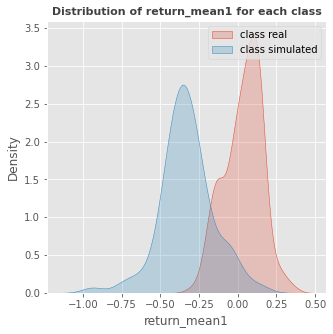

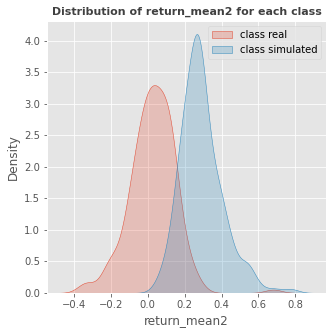

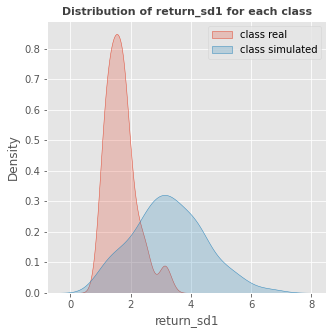

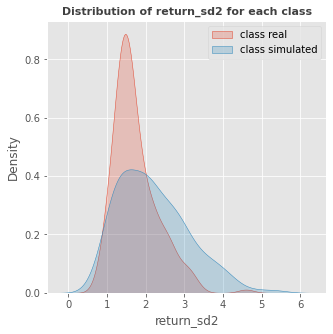

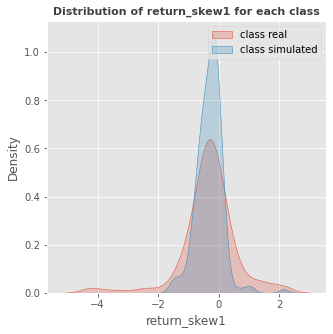

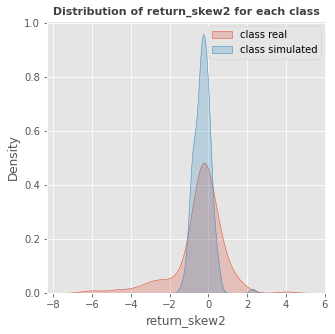

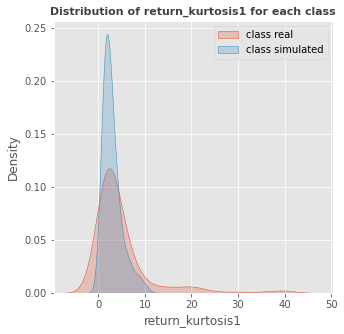

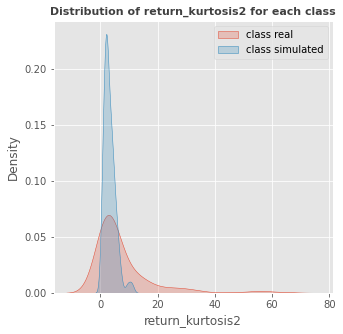

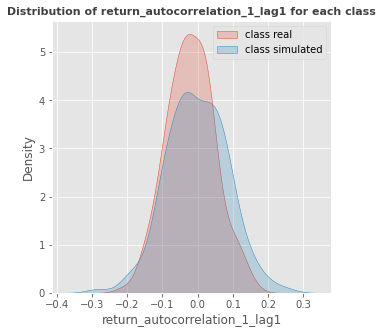

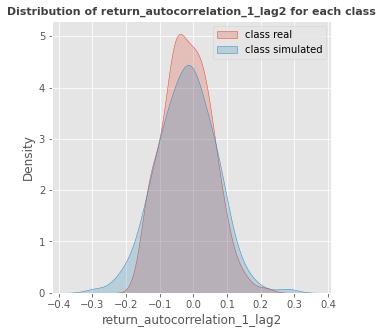

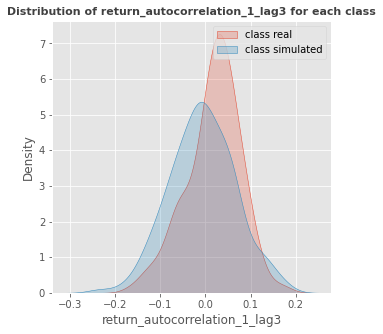

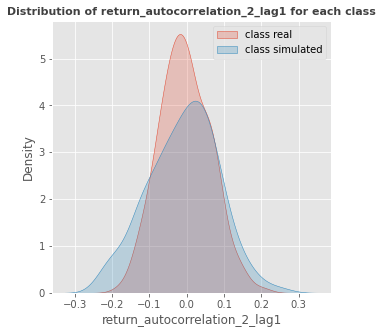

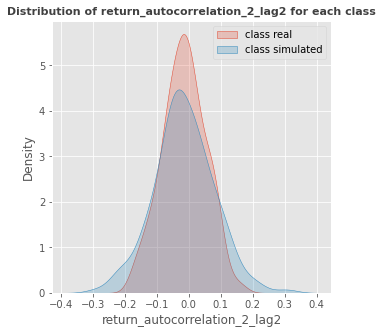

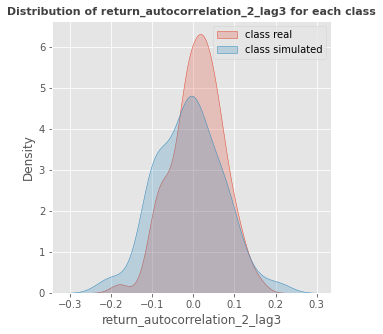

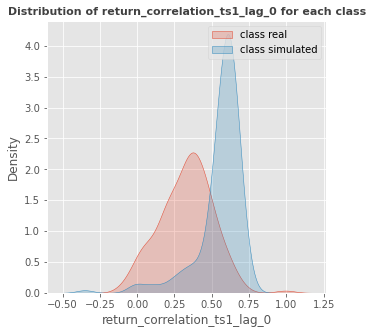

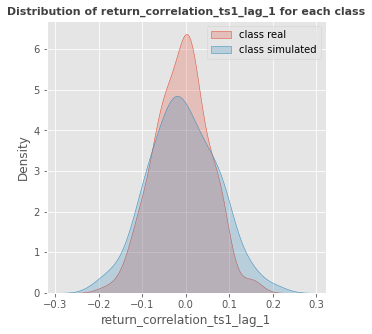

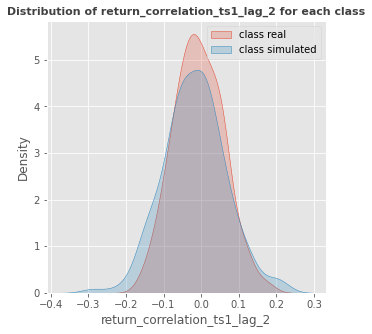

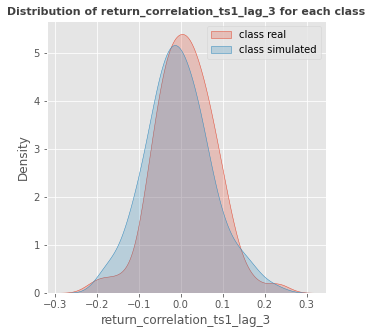

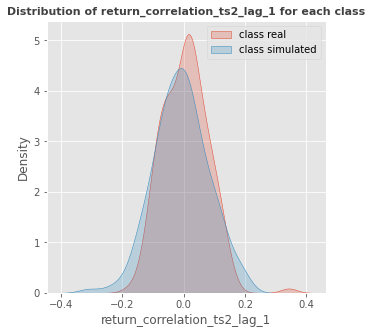

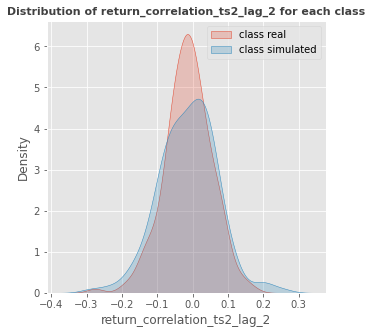

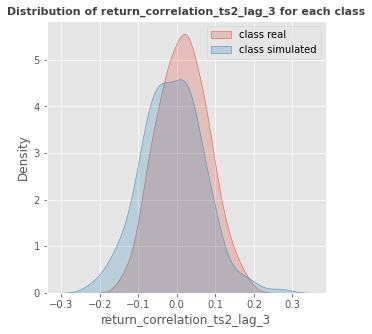

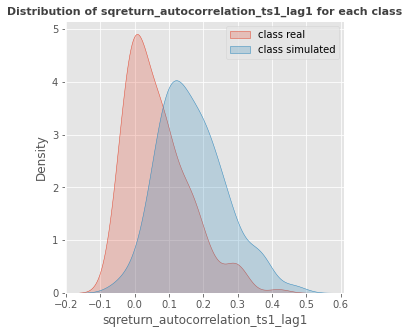

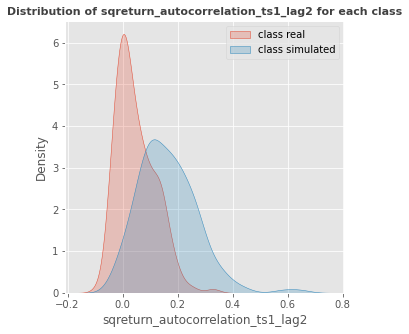

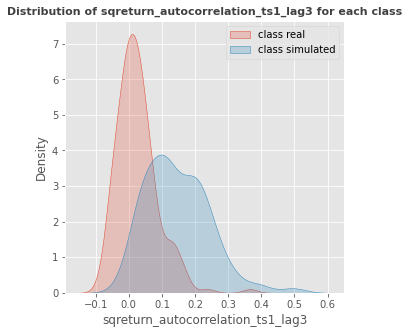

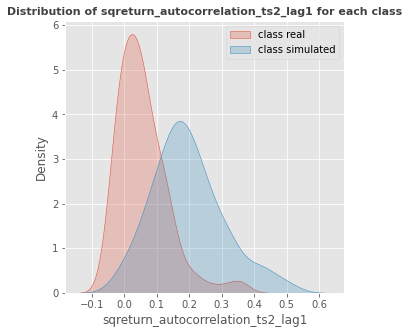

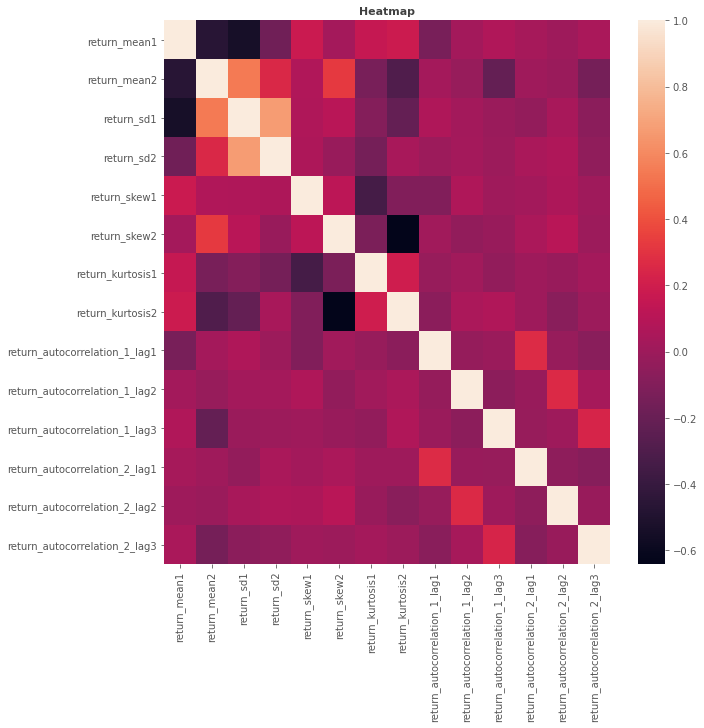

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_log_prices = n_stvol_simulation(
    random_seed=random_seed, num_sim=248,
    mu11=params[0], mu21=params[1], mu22=params[2], 
    mu31=params[3], mu41=params[4], mu42=params[5],  
    sigma11=params[6], sigma12=params[7], sigma13=params[8], sigma14=params[9],
    sigma21=params[10], sigma22=params[11], sigma23=params[12], sigma24=params[13],
    sigma31=params[14], sigma32=params[15], sigma33=params[16], sigma34=params[17],
    sigma41=params[18], sigma42=params[19], sigma43=params[20], sigma44=params[21],
    xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=0, T=1, length=250)
    
    
    n_sim_pair_prices = log_price_to_price(n_log_price=n_sim_log_prices)
    n_sim_pair_returns = price_to_return(n_price=n_sim_pair_prices)
    
    n_sim_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_prices.csv")
    n_sim_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_returns.csv")

   
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)
EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_stvol")

AutoML EDA column limit exceeded! running for first 25 columns


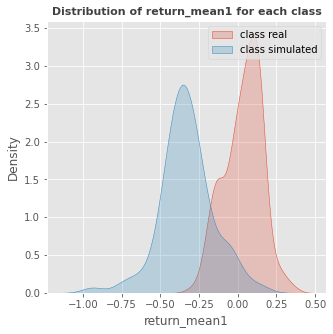

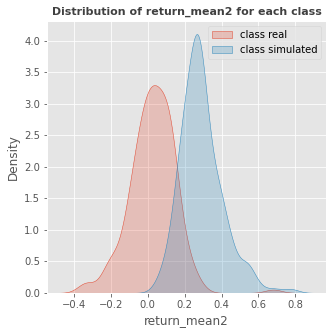

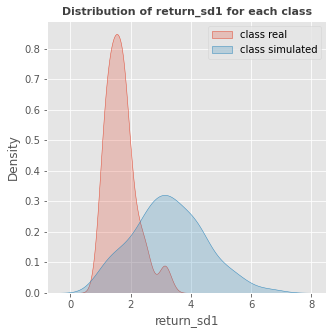

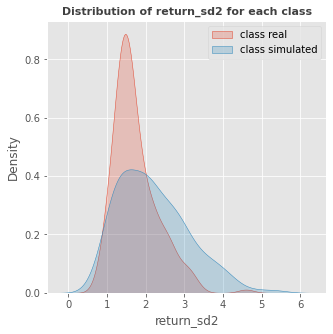

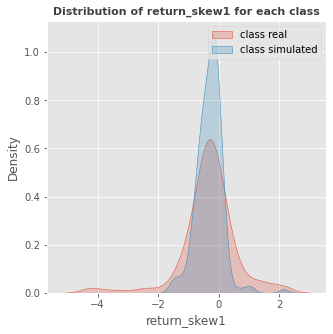

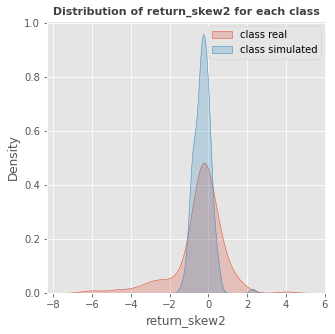

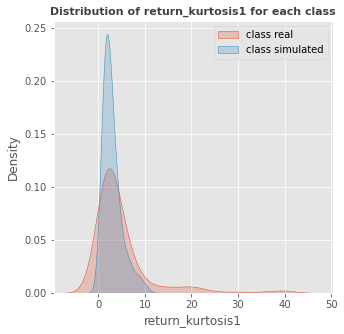

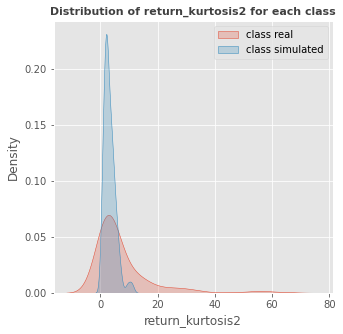

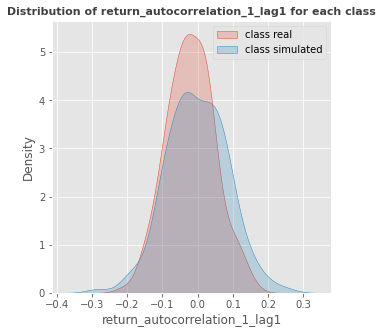

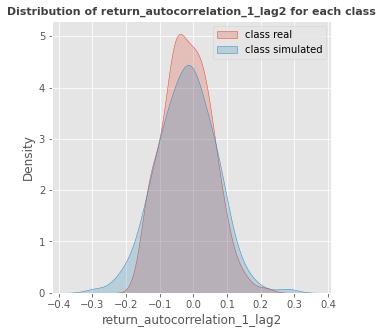

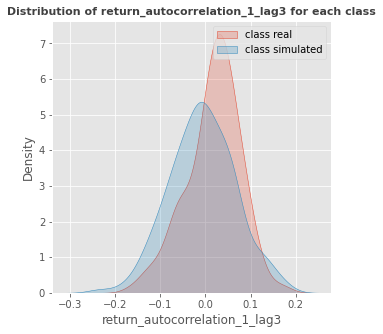

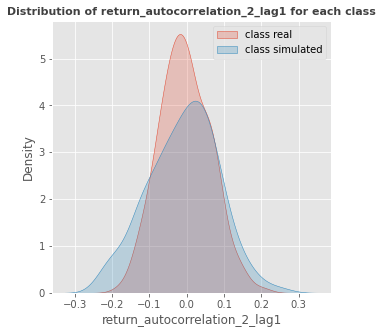

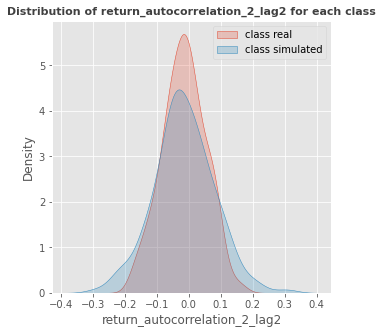

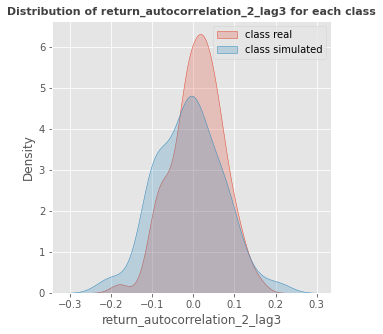

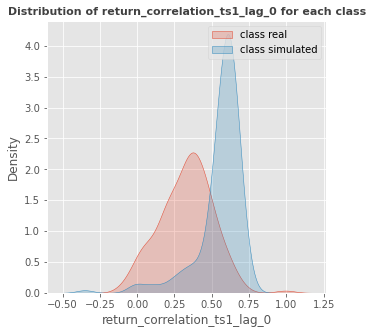

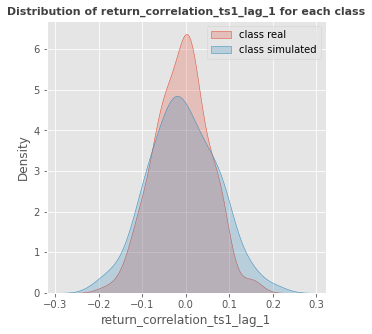

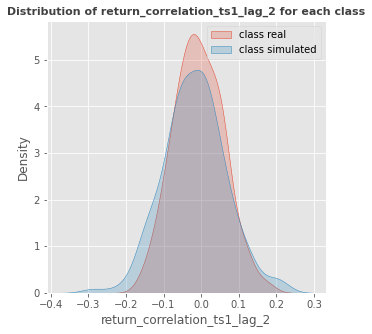

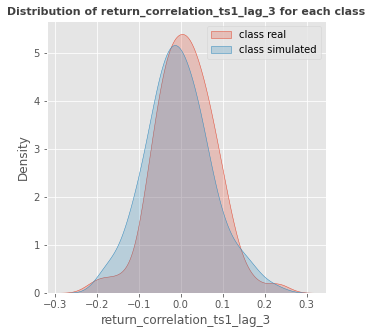

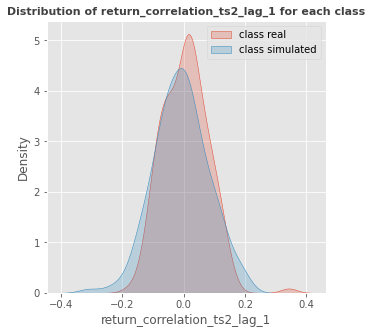

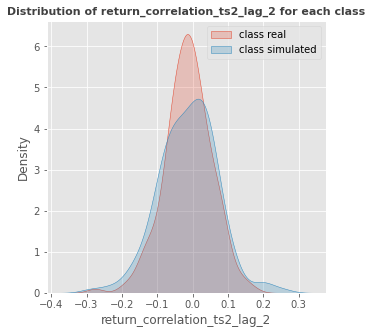

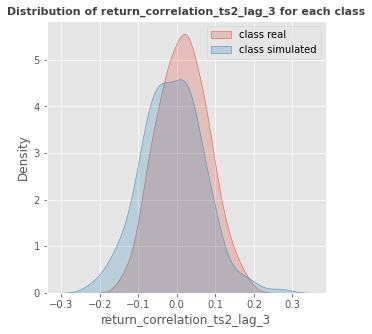

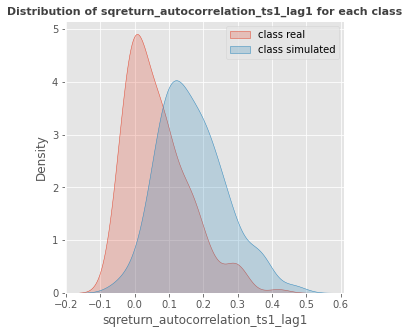

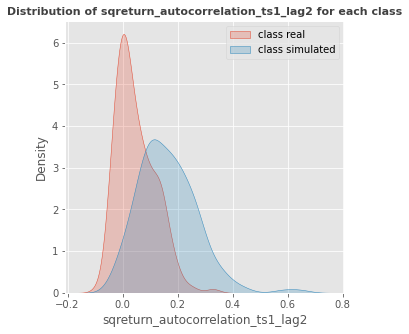

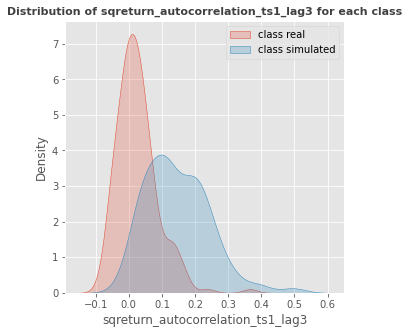

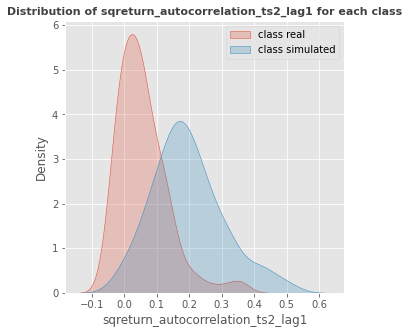

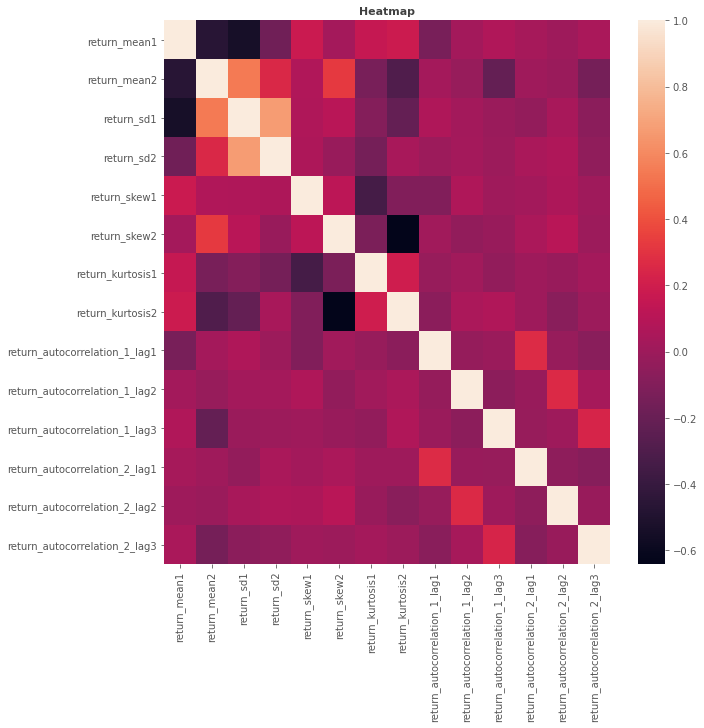

In [6]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_stvol")



In [5]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.959731543624161, 0.9932885906040269, 0.9664429530201343, 0.9865771812080537, 0.9932885906040269]
0.9798657718120806
0.014077971116377885
